# LOAD MODULES

In [1]:
%load_ext autoreload
%autoreload 2
# 2 reloads modules every time a cell is executed

import os, sys#, re,errno, glob, argparse
os.chdir("/home/momoshog/Tornado/tornado_jtti")

from datetime import timedelta, datetime, date, time
from dateutil.parser import parse as parse_date

import xarray as xr
print("xr version", xr.__version__)
import numpy as np
print("np version", np.__version__)
import pandas as pd
print("pd version", pd.__version__)

from netCDF4 import num2date#, Dataset, date2num

from scipy import spatial
from scipy.ndimage import grey_dilation#, uniform_filter, generic_filter, binary_dilation

import wrf #wrf-python=1.3.2.5==py38h0e9072a_0
print("wrf-python version", wrf.__version__)
import metpy
import metpy.calc

#%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib as mpl
#from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.animation import FuncAnimation#, PillowWriter
#from matplotlib import ticker
#import imageio

use_plotly = False
if use_plotly:
    import plotly.express as px
    import plotly.offline as py
    import plotly.graph_objs as go
    from plotly.subplots import make_subplots
    py.init_notebook_mode(connected=True)

#import pickle
from sklearn.metrics import confusion_matrix

import tensorflow as tf
print("tensorflow version", tf.__version__)
from tensorflow import keras
print("keras version", keras.__version__)
from keras_tuner import HyperParameters

# Working directory expected to be tornado_jtti/
sys.path.append("lydia_scripts")
from wofs_ensemble_predictions import select_files#, extract_datetime
from scripts_tensorboard.unet_hypermodel import plot_csi, compute_csi#, compute_sr, compute_pod

#from wofs_raw_predictions import load_wofs_file
sys.path.append("wofs_evaluations")
import wofs_preds_evaluations as wpe

%matplotlib inline

xr version 2023.8.0
np version 1.24.2
pd version 1.5.3
wrf-python version 1.3.4.1


2024-03-15 10:12:34.663868: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


tensorflow version 2.10.0
keras version 2.10.0
np version 1.24.2
pd version 1.5.3
xr version 2023.8.0
xr version 2023.8.0
np version 1.24.2
pd version 1.5.3
wrf-python version 1.3.4.1
tensorflow version 2.10.0
keras version 2.10.0
xr version 2023.8.0
np version 1.24.2
wrf-python version 1.3.4.1


2024-03-15 10:12:45.456936: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-15 10:12:45.466534: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Mixed precision float32 <dtype: 'float32'>
 
 
xr version 2023.8.0
np version 1.24.2
pd version 1.5.3


In [2]:
try:
    import hagelslag 
    import hagelslag.processing.tracker as tracker
    from hagelslag.processing.ObjectMatcher import nonoverlap, centroid_distance
except ImportError:
    print("import hagleslag failed!!!")

In [3]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

## MATPLOTLIB CONFIG

In [4]:
#https://matplotlib.org/stable/tutorials/introductory/customizing.html
plt.rcParams.update({"text.usetex": True})

mpl.rcParams['font.size'] = 18 # default font size
mpl.rcParams['axes.labelsize'] = 18
#mpl.rcParams['axes.labelpad'] = 5
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
#figure.titlesize figure.labelsize axes.titlesize font.size

plt.rcParams["animation.html"] = "html5"

cb_args = {'rotation': 270, 'labelpad': 25}

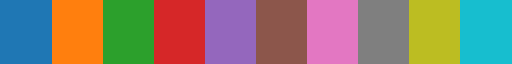

In [5]:
#https://stackoverflow.com/questions/30079590/use-matplotlib-color-map-for-color-cycle
plt.cm.tab10

In [6]:
plt.cm.tab10.colors

((0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529))

In [7]:
mpl.colors.CSS4_COLORS

{'aliceblue': '#F0F8FF',
 'antiquewhite': '#FAEBD7',
 'aqua': '#00FFFF',
 'aquamarine': '#7FFFD4',
 'azure': '#F0FFFF',
 'beige': '#F5F5DC',
 'bisque': '#FFE4C4',
 'black': '#000000',
 'blanchedalmond': '#FFEBCD',
 'blue': '#0000FF',
 'blueviolet': '#8A2BE2',
 'brown': '#A52A2A',
 'burlywood': '#DEB887',
 'cadetblue': '#5F9EA0',
 'chartreuse': '#7FFF00',
 'chocolate': '#D2691E',
 'coral': '#FF7F50',
 'cornflowerblue': '#6495ED',
 'cornsilk': '#FFF8DC',
 'crimson': '#DC143C',
 'cyan': '#00FFFF',
 'darkblue': '#00008B',
 'darkcyan': '#008B8B',
 'darkgoldenrod': '#B8860B',
 'darkgray': '#A9A9A9',
 'darkgreen': '#006400',
 'darkgrey': '#A9A9A9',
 'darkkhaki': '#BDB76B',
 'darkmagenta': '#8B008B',
 'darkolivegreen': '#556B2F',
 'darkorange': '#FF8C00',
 'darkorchid': '#9932CC',
 'darkred': '#8B0000',
 'darksalmon': '#E9967A',
 'darkseagreen': '#8FBC8F',
 'darkslateblue': '#483D8B',
 'darkslategray': '#2F4F4F',
 'darkslategrey': '#2F4F4F',
 'darkturquoise': '#00CED1',
 'darkviolet': '#9400D3

In [8]:
def corrcoef2D(A, B):
    '''
    Each row is an independent variable
    '''
    # Input minus mean of rows input arrays
    A_mA = A - A.mean(axis=1).reshape(-1, 1)
    B_mB = B - B.mean(axis=1).reshape(-1, 1)

    # Sum of squares across rows
    ssA = (A_mA**2).sum(axis=1).reshape(-1, 1)
    ssB = (B_mB**2).sum(axis=1).reshape(-1, 1)

    # Compute corr coeff
    return np.dot(A_mA, B_mB.T) / np.sqrt(np.dot(ssA, ssB.T))

A = np.array([[1, 2, 3, 4, 5], 
              [2, 3, 4, 5, 6], 
              [1, 2, 1, 0, 1]])
corrcoef2D(A, A)

array([[ 1.       ,  1.       , -0.4472136],
       [ 1.       ,  1.       , -0.4472136],
       [-0.4472136, -0.4472136,  1.       ]])

# LOAD DATA

In [9]:
YEAR = 2019
DATE = f'{YEAR}0430'

dir_wofs = f"/ourdisk/hpc/ai2es/wofs/{YEAR}" #f"/ourdisk/hpc/ai2es/tornado/wofs-preds-{YEAR}" #2023

dir_wofs_preds = "/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jtti/wofs_preds"

TUNER = "tor_unet_sample50_50_classweightsNone_hyper"
MODEL = "2023_07_20_20_55_39_hp_model00"
#TUNER="tor_unet_sample50_50_classweights20_80_hyper"
#MODEL="2023_07_21_08_33_57_hp_model00"
#TUNER="tor_unet_sample50_50_classweights50_50_hyper"
#MODEL="2023_07_21_08_33_16_hp_model00"
TUNER="tor_unet_sample90_10_classweights20_80_hyper"
MODEL="2023_07_20_09_32_38_hp_model00"
dir_wofs_preds1 = f"/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jtti/wofs_preds1/{TUNER}"

dir_storm_reports = "/ourdisk/hpc/ai2es/alexnozka/tornado_reports" 

#TODO: IEM polygon storm warnings data

fn_wofs_test = "wrfwof_d01_2019-04-30_23:10:00_predictions.nc"

In [10]:
fmt_dt = '%Y-%m-%d_%H:%M:%S' #'%Y-%m-%d_%H_%M_%S' '%Y-%m-%d_%H_%M_%S'
fmt_re = r'\d{4}-\d{2}-\d{2}_\d{2}(_|:)\d{2}(_|:)\d{2}' #r'\d{4}-\d{2}-\d{2}_\d{2}_\d{2}_\d{2}'

extr_args = {'method': 're', 'fmt_dt': fmt_dt, 'fmt_re': fmt_re}

dir_2019 = os.path.join(dir_wofs_preds, '2019')
rdates = sorted(os.listdir(dir_2019))

all_dfs = []
for _date in rdates:
    _df = wpe.generate_init_times_files_list_all(dir_2019, _date, save_path=None,
                                                 df_index=False, **extr_args)
    all_dfs.append(_df)

df_all_rundate_files = pd.concat(all_dfs, ignore_index=True, verify_integrity=True)
#df_all_files

del all_dfs

In [11]:
wofs_sample = xr.load_dataset('/ourdisk/hpc/ai2es/wofs/2019/20190430/1900/ENS_MEM_1/wrfwof_d01_2019-04-30_23:10:00')
attrs = wofs_sample.attrs
del wofs_sample
attrs

{'TITLE': ' OUTPUT FROM WRF V3.8 MODEL',
 'START_DATE': '2019-04-30_19:00:00',
 'WEST-EAST_GRID_DIMENSION': 301,
 'SOUTH-NORTH_GRID_DIMENSION': 301,
 'BOTTOM-TOP_GRID_DIMENSION': 51,
 'DX': 3000.0,
 'DY': 3000.0,
 'GRIDTYPE': 'C',
 'DIFF_OPT': 1,
 'KM_OPT': 4,
 'DAMP_OPT': 3,
 'DAMPCOEF': 0.2,
 'KHDIF': 0.0,
 'KVDIF': 0.0,
 'MP_PHYSICS': 18,
 'RA_LW_PHYSICS': 1,
 'RA_SW_PHYSICS': 1,
 'SF_SFCLAY_PHYSICS': 1,
 'SF_SURFACE_PHYSICS': 3,
 'BL_PBL_PHYSICS': 1,
 'CU_PHYSICS': 0,
 'SF_LAKE_PHYSICS': 0,
 'SURFACE_INPUT_SOURCE': 1,
 'SST_UPDATE': 0,
 'GRID_FDDA': 0,
 'GFDDA_INTERVAL_M': 0,
 'GFDDA_END_H': 0,
 'GRID_SFDDA': 0,
 'SGFDDA_INTERVAL_M': 0,
 'SGFDDA_END_H': 0,
 'HYPSOMETRIC_OPT': 2,
 'USE_THETA_M': 0,
 'WEST-EAST_PATCH_START_UNSTAG': 1,
 'WEST-EAST_PATCH_END_UNSTAG': 300,
 'WEST-EAST_PATCH_START_STAG': 1,
 'WEST-EAST_PATCH_END_STAG': 301,
 'SOUTH-NORTH_PATCH_START_UNSTAG': 1,
 'SOUTH-NORTH_PATCH_END_UNSTAG': 300,
 'SOUTH-NORTH_PATCH_START_STAG': 1,
 'SOUTH-NORTH_PATCH_END_STAG': 301,
 

In [12]:
_wofs_tmp = xr.load_dataset('/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jtti/wofs_preds1/tor_unet_sample90_10_classweights20_80_hyper/2019/20190429/0030/ENS_MEM_9/wrfout_d01_2019-04-30_00:30:00_predictions.nc')
_wofs_tmp

<xarray.Dataset>
Dimensions:              (Time: 1, south_north: 300, west_east: 300,
                          bottom_top: 50)
Coordinates:
    XLAT                 (Time, south_north, west_east) float32 29.58 ... 37.75
    XLONG                (Time, south_north, west_east) float32 -104.4 ... -9...
  * Time                 (Time) int64 578277000
    XTIME                (Time) datetime64[ns] 2019-04-30T00:30:00
Dimensions without coordinates: south_north, west_east, bottom_top
Data variables:
    ML_PREDICTED_TOR     (Time, south_north, west_east) float64 0.0001908 ......
    COMPOSITE_REFL_10CM  (Time, south_north, west_east) float32 0.0 0.0 ... 0.0
    REFL_10CM            (Time, bottom_top, south_north, west_east) float32 0...
    Times                (Time) |S19 b'2019-04-30_00:30:00'
    UP_HELI_MAX          (Time, south_north, west_east) float32 0.0 0.0 ... 0.0
Attributes: (12/120)
    TITLE:                            OUTPUT FROM WRF V3.8 MODEL
    START_DATE:                      2019-04-30_00:30:00
    SIMULATION_START_DATE:           2019-04-30_00:30:00
    WEST-EAST_GRID_DIMENSION:        301
    SOUTH-NORTH_GRID_DIMENSION:      301
    BOTTOM-TOP_GRID_DIMENSION:       51
    ...                              ...
    ISURBAN:                         13
    ISOILWATER:                      14
    history:                         Wed Jun  3 02:53:00 2020: /scratch/softw...
    NCO:                             4.6.7
    filenamepath:                    /ourdisk/hpc/ai2es/wofs/2019/20190429/00...
    FORECAST_DATETIME:               2019-04-30_00:30:00

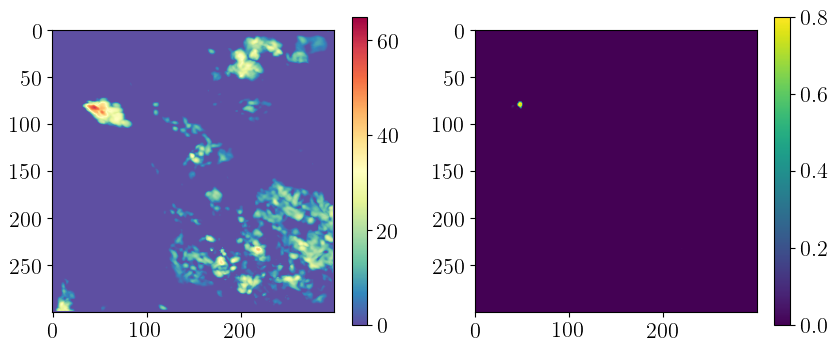

In [13]:
_f, _a = plt.subplots(1, 2, figsize=(10,4))
_a = _a.ravel()

im = _a[0].imshow(_wofs_tmp.COMPOSITE_REFL_10CM[0], 
                  cmap='Spectral_r', vmin=0, vmax=65)
cb = plt.colorbar(im, ax=_a[0])
#cb = _f.colorbar(_a[0].images[-1], ax=_a[0])

im = _a[1].imshow(_wofs_tmp.ML_PREDICTED_TOR[0], vmin=0, vmax=.8)
plt.colorbar(im, ax=_a[1])

In [14]:
_cb = _a[0].images[-1].colorbar

In [15]:
del _f, _a, _cb,  _wofs_tmp

## LOAD STORM REPORTS

In [16]:
files_storm_reports = sorted(os.listdir(dir_storm_reports))
files_storm_reports

['190429_rpts_filtered_torn.csv',
 '190430_rpts_filtered_torn.csv',
 '190501_rpts_filtered_torn.csv',
 '190502_rpts_filtered_torn.csv',
 '190503_rpts_filtered_torn.csv',
 '190504_rpts_filtered_torn.csv',
 '190506_rpts_filtered_torn.csv',
 '190507_rpts_filtered_torn.csv',
 '190508_rpts_filtered_torn.csv',
 '190509_rpts_filtered_torn.csv',
 '190510_rpts_filtered_torn.csv',
 '190511_rpts_filtered_torn.csv',
 '190513_rpts_filtered_torn.csv',
 '190514_rpts_filtered_torn.csv',
 '190515_rpts_filtered_torn.csv',
 '190516_rpts_filtered_torn.csv',
 '190517_rpts_filtered_torn.csv',
 '190518_rpts_filtered_torn.csv',
 '190520_rpts_filtered_torn.csv',
 '190521_rpts_filtered_torn.csv',
 '190522_rpts_filtered_torn.csv',
 '190523_rpts_filtered_torn.csv',
 '190524_rpts_filtered_torn.csv',
 '190525_rpts_filtered_torn.csv',
 '190526_rpts_filtered_torn.csv',
 '190528_rpts_filtered_torn.csv',
 '190529_rpts_filtered_torn.csv',
 '190530_rpts_filtered_torn.csv']

In [17]:
def datestr_to_datetuple(datestr, fmtstr, **kwargs):
    '''
    Convert date string to date tuple (YYYY, month, day)
    Parameters
    ----------
    datestr: str with the date
    fmtstr: str with the format the date string follows
    Returns
    ----------
    tuple (year, month, day)
    '''
    #from dateutil.parser import parse as parse_date
    try:
        dateobj = datetime.strptime(datestr, fmtstr)
    except:
        date_str = '190502_rpts_filtered_torn.csv' #"Mon Feb 15 2010"
        dateobj, residual_str = parse_date(datestr, **kwargs) #, yearfirst=True, fuzzy_with_tokens=True
    return (dateobj.year, dateobj.month, dateobj.day)

datestr_to_datetuple('190503', '%y%m%d')

(2019, 5, 3)

In [18]:
'''
date_str = '190502_rpts_filtered_torn.csv' #"Mon Feb 15 2010"
dtobj, residual_str = parse(date_str, yearfirst=True, fuzzy_with_tokens=True)
print(dtobj, residual_str)  # Output: 2010-02-15 00:00:00

import parsedatetime
cal = parsedatetime.Calendar()
parsed_result, _ = cal.parse("tomorrow")
python_datetime = datetime.datetime(*parsed_result[:6])
'''

kwargs = {'yearfirst': True, 'fuzzy_with_tokens': True}
datestr_to_datetuple('190501_rpts_filtered_torn.csv', '%y%m%d', **kwargs)

(2019, 5, 1)

In [19]:
files_storm_reports[1], files_storm_reports[2]

('190430_rpts_filtered_torn.csv', '190501_rpts_filtered_torn.csv')

In [20]:
fn_storm_report = os.path.join(dir_storm_reports, files_storm_reports[1])
print(fn_storm_report)
#df_storm_report = pd.read_csv(fn_storm_report)
#df_storm_report
df_storm_report_20190430, date_storm_report_20190430 = wpe.load_storm_report(fn_storm_report, 2019, 
                                                           month=4, day=30)
df_storm_report_20190430.shape, date_storm_report_20190430

/ourdisk/hpc/ai2es/alexnozka/tornado_reports/190430_rpts_filtered_torn.csv


((68, 9), datetime.datetime(2019, 4, 30, 0, 0))

### df_storm_report

In [21]:
all_dfs = []
#for file, _date in zip(files_storm_reports, storm_report_dates):
for file in files_storm_reports:
    datestr = file[:6]
    _date = datestr_to_datetuple(datestr, '%y%m%d')
    _fn_storm_report = os.path.join(dir_storm_reports, file)
    print(_date, _fn_storm_report)
    _df, date_storm_report = wpe.load_storm_report(_fn_storm_report, _date[0], #YEAR,
                                                   month=_date[1], day=_date[2])
    all_dfs.append(_df)

df_storm_report = pd.concat(all_dfs, ignore_index=True, verify_integrity=True)

SAVE = False
if SAVE:
    df_storm_report.to_csv('/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jtti/tornado_reports/tornado_reports_2019_spring.csv', header=True)
    print("SAVE.")

df_storm_report.shape

(2019, 4, 29) /ourdisk/hpc/ai2es/alexnozka/tornado_reports/190429_rpts_filtered_torn.csv
(2019, 4, 30) /ourdisk/hpc/ai2es/alexnozka/tornado_reports/190430_rpts_filtered_torn.csv
(2019, 5, 1) /ourdisk/hpc/ai2es/alexnozka/tornado_reports/190501_rpts_filtered_torn.csv
(2019, 5, 2) /ourdisk/hpc/ai2es/alexnozka/tornado_reports/190502_rpts_filtered_torn.csv
(2019, 5, 3) /ourdisk/hpc/ai2es/alexnozka/tornado_reports/190503_rpts_filtered_torn.csv
(2019, 5, 4) /ourdisk/hpc/ai2es/alexnozka/tornado_reports/190504_rpts_filtered_torn.csv
(2019, 5, 6) /ourdisk/hpc/ai2es/alexnozka/tornado_reports/190506_rpts_filtered_torn.csv
(2019, 5, 7) /ourdisk/hpc/ai2es/alexnozka/tornado_reports/190507_rpts_filtered_torn.csv
(2019, 5, 8) /ourdisk/hpc/ai2es/alexnozka/tornado_reports/190508_rpts_filtered_torn.csv
(2019, 5, 9) /ourdisk/hpc/ai2es/alexnozka/tornado_reports/190509_rpts_filtered_torn.csv
(2019, 5, 10) /ourdisk/hpc/ai2es/alexnozka/tornado_reports/190510_rpts_filtered_torn.csv


(2019, 5, 11) /ourdisk/hpc/ai2es/alexnozka/tornado_reports/190511_rpts_filtered_torn.csv
(2019, 5, 13) /ourdisk/hpc/ai2es/alexnozka/tornado_reports/190513_rpts_filtered_torn.csv
(2019, 5, 14) /ourdisk/hpc/ai2es/alexnozka/tornado_reports/190514_rpts_filtered_torn.csv
(2019, 5, 15) /ourdisk/hpc/ai2es/alexnozka/tornado_reports/190515_rpts_filtered_torn.csv
(2019, 5, 16) /ourdisk/hpc/ai2es/alexnozka/tornado_reports/190516_rpts_filtered_torn.csv
(2019, 5, 17) /ourdisk/hpc/ai2es/alexnozka/tornado_reports/190517_rpts_filtered_torn.csv
(2019, 5, 18) /ourdisk/hpc/ai2es/alexnozka/tornado_reports/190518_rpts_filtered_torn.csv
(2019, 5, 20) /ourdisk/hpc/ai2es/alexnozka/tornado_reports/190520_rpts_filtered_torn.csv
(2019, 5, 21) /ourdisk/hpc/ai2es/alexnozka/tornado_reports/190521_rpts_filtered_torn.csv
(2019, 5, 22) /ourdisk/hpc/ai2es/alexnozka/tornado_reports/190522_rpts_filtered_torn.csv
(2019, 5, 23) /ourdisk/hpc/ai2es/alexnozka/tornado_reports/190523_rpts_filtered_torn.csv
(2019, 5, 24) /ourdis

(513, 9)

In [22]:
pd.concat([df_storm_report.head(10), df_storm_report.tail(10)])

Time            DateTime F_Scale               Location     County State    Lat     Lon                                           Comments
0       6 2019-04-30 00:06:00     UNK       5 WSW BRUSHYKNOB    DOUGLAS    MO  36.93  -92.57  NWS STORM SURVEY CONFIRMED AN EF-1 TORNADO WIT...
1      28 2019-04-30 00:28:00     UNK              2 N OZARK  CHRISTIAN    MO  37.07  -93.20  *** 3 INJ *** AN NWS STORM SURVEY CONFIRMED AN...
2      30 2019-04-30 00:30:00     UNK          4 WSW NORWOOD     WRIGHT    MO  37.10  -92.49  A NWS SURVEY TEAM CONFIRMED AN EF-1 TORNADO WH...
3      38 2019-04-30 00:38:00     UNK            6 NW MILLER   LAWRENCE    MO  37.29  -93.91  AN NWS STORM SURVEY CONFIRMED AN EF1 TORNADO T...
4      40 2019-04-30 00:40:00     UNK            1 SW EUDORA       POLK    MO  37.45  -93.56  AN NWS STORM SURVEY CONFIRMED AN EF1 TORNADO T...
5      58 2019-04-30 00:58:00     UNK    4 SW MOUNTAIN GROVE     WRIGHT    MO  37.09  -92.32  A NWS SURVEY TEAM CONFIRMED AN EF-0 TORNADO WH...
6     115 2019-04-30 01:15:00     UNK           2 NW WILLARD     GREENE    MO  37.33  -93.46  CORRECTS PREVIOUS TORNADO REPORT FROM 2 NW WIL...
7     121 2019-04-30 01:21:00     UNK           4 NE WILLARD     GREENE    MO  37.36  -93.39  AN NWS STORM SURVEY CONFIRMED AN EF1 TORNADO T...
8     124 2019-04-30 01:24:00     UNK        1 E ROGERSVILLE    WEBSTER    MO  37.11  -93.04  ROOF TORN OFF; PARTIAL BUILDING COLLAPSE ON EN...
9     128 2019-04-30 01:28:00     UNK              2 N OZARK  CHRISTIAN    MO  37.07  -93.20  *** 3 INJ *** CORRECTS PREVIOUS TORNADO REPORT...
503  2158 2019-05-29 21:58:00     UNK           4 WSW CANTON  VAN ZANDT    TX  32.53  -95.93  MULTI-VORTEX TORNADO WITH DEBRIS NEAR HIGHWAY ...
504  2208 2019-05-29 22:08:00     UNK             1 W CANTON  VAN ZANDT    TX  32.55  -95.88  A TORNADO DEVELOPED NEAR CANTON HIGH SCHOOL TH...
505  2210 2019-05-29 22:10:00     UNK        4 WSW HOCHATOWN  MCCURTAIN    OK  34.18  -94.73  TREES DOWN FROM POSSIBLE TORNADO IN HOCHATOWN ...
506  2215 2019-05-29 22:15:00     UNK                 CANTON  VAN ZANDT    TX  32.55  -95.87              TORNADO CROSSED I-20 NEAR FM 17 (FWD)
507  2231 2019-05-29 22:31:00     UNK           4 ESE BAILEY     FANNIN    TX  33.42  -96.10  DAMAGE CONSISTENT WITH AT LEAST ONE EF-0 TORNA...
508  2322 2019-05-29 23:22:00     UNK          2 SE BRADGATE   HUMBOLDT    IA  42.78  -94.39  CONE TORNADO REPORTED. REPORT VIA SOCIAL MEDIA...
509  2323 2019-05-29 23:23:00     UNK            1 SE VICTOR       IOWA    IA  41.72  -92.27  A BRIEF EF-0 TORNADO WAS CAPTURED BY THE PUBLI...
510  1848 2019-05-30 18:48:00     UNK  3 ENE BALLENGER CREEK  FREDERICK    MD  39.38  -77.38  EF0 TORNADO WITH ESTIMATED PEAK WINDS OF 85 MP...
511  1920 2019-05-30 19:20:00     UNK          2 WSW GLENELG     HOWARD    MD  39.25  -77.03  EF1 TORNADO WITH ESTIMATED PEAK WINDS OF 100 M...
512  1942 2019-05-30 19:42:00     UNK      15 ESE CROWNPOINT   MCKINLEY    NM  35.60 -107.90                           LANDSPOUT TORNADO. (ABQ)

In [23]:
np.quantile(df_storm_report['Lat'], [0,1]), np.quantile(df_storm_report['Lon'], [0,1])

(array([26.75, 47.32]), array([-121.64,  -74.7 ]))

In [24]:
df = df_storm_report.copy()

#d.to_pydatetime() for d in pd.to_datetime(df['DateTime'].values)
df['nDate'] = df['DateTime'].copy()
nDate = []
for i, row in enumerate(df['nDate']):
    nDate.append(pd.to_datetime(row, yearfirst=True).strftime('%Y%m%d'))
#pd.to_datetime(df['DateTime'], yearfirst=True, format='%Y%m%d').strftime('%Y%m%d')
df['nDate'] = np.array([d.to_pydatetime() for d in pd.to_datetime(nDate)])

print(np.unique(df['nDate']))

print(df['nDate'].head(5))

df.head(5)

['2019-04-30T00:00:00.000000000' '2019-05-01T00:00:00.000000000'
 '2019-05-02T00:00:00.000000000' '2019-05-03T00:00:00.000000000'
 '2019-05-04T00:00:00.000000000' '2019-05-06T00:00:00.000000000'
 '2019-05-07T00:00:00.000000000' '2019-05-08T00:00:00.000000000'
 '2019-05-09T00:00:00.000000000' '2019-05-11T00:00:00.000000000'
 '2019-05-13T00:00:00.000000000' '2019-05-16T00:00:00.000000000'
 '2019-05-17T00:00:00.000000000' '2019-05-18T00:00:00.000000000'
 '2019-05-20T00:00:00.000000000' '2019-05-21T00:00:00.000000000'
 '2019-05-22T00:00:00.000000000' '2019-05-23T00:00:00.000000000'
 '2019-05-24T00:00:00.000000000' '2019-05-25T00:00:00.000000000'
 '2019-05-26T00:00:00.000000000' '2019-05-28T00:00:00.000000000'
 '2019-05-29T00:00:00.000000000' '2019-05-30T00:00:00.000000000']
0   2019-04-30
1   2019-04-30
2   2019-04-30
3   2019-04-30
4   2019-04-30
Name: nDate, dtype: datetime64[ns]


Time            DateTime F_Scale          Location     County State    Lat    Lon                                           Comments      nDate
0    6 2019-04-30 00:06:00     UNK  5 WSW BRUSHYKNOB    DOUGLAS    MO  36.93 -92.57  NWS STORM SURVEY CONFIRMED AN EF-1 TORNADO WIT... 2019-04-30
1   28 2019-04-30 00:28:00     UNK         2 N OZARK  CHRISTIAN    MO  37.07 -93.20  *** 3 INJ *** AN NWS STORM SURVEY CONFIRMED AN... 2019-04-30
2   30 2019-04-30 00:30:00     UNK     4 WSW NORWOOD     WRIGHT    MO  37.10 -92.49  A NWS SURVEY TEAM CONFIRMED AN EF-1 TORNADO WH... 2019-04-30
3   38 2019-04-30 00:38:00     UNK       6 NW MILLER   LAWRENCE    MO  37.29 -93.91  AN NWS STORM SURVEY CONFIRMED AN EF1 TORNADO T... 2019-04-30
4   40 2019-04-30 00:40:00     UNK       1 SW EUDORA       POLK    MO  37.45 -93.56  AN NWS STORM SURVEY CONFIRMED AN EF1 TORNADO T... 2019-04-30

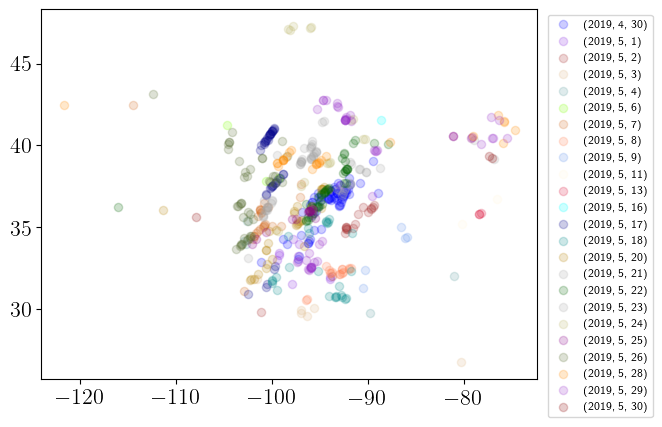

In [25]:
'''
plt.scatter(df_storm_report['Lon'], df_storm_report['Lat'], 
            c=df_storm_report['DateTime'], s=6, marker='o',
            label=df_storm_report['DateTime']) #facecolor=None, alpha=.3
plt.legend(loc='upper left', bbox_to_anchor=(1, 1));

#bar_plt = df.plot(kind="scatter", x='Lon', y='Lat') # ,c='nDate', label=np.unique(df['nDate']))
#bar_plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
'''
#TODO: cartopy

color_options = list(mpl.colors.CSS4_COLORS.keys())[9:] #mpl.cm.tab20.colors 

by = [df['DateTime'].dt.year, df['DateTime'].dt.month, df['DateTime'].dt.day]
date_groups = df['DateTime'].groupby(by).groups

for i, (date_tuple, inds) in enumerate(date_groups.items()):
    #if date_tuple != (2019, 5, 2): continue
    plt.scatter(df['Lon'][inds], df['Lat'][inds], c=color_options[i], s=35,
                label=str(date_tuple), facecolor=None, alpha=.2)
plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1), fontsize=8)

In [26]:
by = [df['DateTime'].dt.year==2019, df['DateTime'].dt.month==5, df['DateTime'].dt.day==2]
df['DateTime'].groupby(by).groups.keys()

dict_keys([(True, False, False), (True, True, False), (True, True, True)])

In [27]:
inds = df['DateTime'].groupby(by).groups[(True, True, True)]
df.iloc[inds]

Time            DateTime F_Scale              Location       County State    Lat     Lon                                           Comments      nDate
77   220 2019-05-02 02:20:00     UNK         9 NE COMSTOCK    VAL VERDE    TX  29.79 -101.09  STORM CHASER REPORTED A TORNADO APPROXIMATELY ... 2019-05-02
78  1208 2019-05-02 12:08:00     UNK   1 N SOUTH MANSFIELD      DE SOTO    LA  32.03  -93.72  THE TORNADO BRIEFLY TOUCHED DOWN NEAR THE INTE... 2019-05-02
79  1739 2019-05-02 17:39:00     UNK       1 WNW MABELVALE      PULASKI    AR  34.66  -92.40  THE SURVEY TEAM HAS CONFIRMED A TORNADO NEAR T... 2019-05-02
80  1815 2019-05-02 18:15:00     UNK          2 SSW GIBSON      PULASKI    AR  34.87  -92.24  NUMEROUS TREES DOWN ALONG PORTIONS OF KELLOGG ... 2019-05-02
81  1820 2019-05-02 18:20:00     UNK          5 N SHERWOOD      PULASKI    AR  34.90  -92.21  A TREE WAS DOWN ON A SHED AT BATESVILLE PIKE A... 2019-05-02
82  1826 2019-05-02 18:26:00     UNK            2 ESE CATO      PULASKI    AR  34.92  -92.24  TREES WERE EITHER UPROOTED OR TREE LIMBS SNAPP... 2019-05-02
83  1835 2019-05-02 18:35:00     UNK        3 NNW OLMSTEAD     FAULKNER    AR  34.98  -92.24  THIS WEAK TORNADO MOVED FROM NE TO SW. TREE LI... 2019-05-02
84  1852 2019-05-02 18:52:00     UNK             2 SW OTTO     FAULKNER    AR  35.02  -92.23                HOUSE REPORTED TO BE DAMAGED. (LZK) 2019-05-02
85  1923 2019-05-02 19:23:00     UNK   2 S FOURMILE CORNER      PRAIRIE    AR  34.95  -91.57  MULTIPLE REPORTS VIA SOCIAL MEDIA... INCLUDING... 2019-05-02
86  1945 2019-05-02 19:45:00     UNK          3 SE SWIFTON      JACKSON    AR  35.80  -91.08             TORNADO REPORTED ON HIGHWAY 226. (LZK) 2019-05-02
87  1957 2019-05-02 19:57:00     UNK            2 SW REVEL     WOODRUFF    AR  35.21  -91.31  BROADCAST MEDIA VIEWER SENT PICTURE OF TORNADO... 2019-05-02
88  2129 2019-05-02 21:29:00     UNK             4 NE LAFE       GREENE    AR  36.25  -90.46  EMERGENCY MANAGER REPORTED TORNADO NEAR KNOB..... 2019-05-02
89  2202 2019-05-02 22:02:00     UNK     1 WNW BLYTHEVILLE  MISSISSIPPI    AR  35.94  -89.95         BRIEF TORNADO REPORTED NEAR GOSNELL. (MEG) 2019-05-02
90  2311 2019-05-02 23:11:00     UNK  4 SSE CARUTHERSVILLE     PEMISCOT    MO  36.13  -89.63  EF-0 TORNADO UPROOTED TREES NEAR COUNTY ROAD 5... 2019-05-02
91  2319 2019-05-02 23:19:00     UNK  2 ENE CARUTHERSVILLE         LAKE    TN  36.20  -89.63     TORNADO REPORTED EAST OF CARUTHERSVILLE. (MEG) 2019-05-02
92  2321 2019-05-02 23:21:00     UNK         3 ESE RIDGELY        OBION    TN  36.24  -89.43  EF-0 TORNADO CAUSED TREE DAMAGE ALONG BLUFF RO... 2019-05-02
93  2343 2019-05-02 23:43:00     UNK        2 WNW HORNBEAK        OBION    TN  36.34  -89.33  BRIEF TORNADO CAUSED TREE DAMAGE ALONG HIGHWAY... 2019-05-02

#### Storm Report Counts by Day

DateTime  DateTime  DateTime
2019      4         30          68
          5         1            9
                    2           17
                    3            6
                    4            5
                    6            4
                    7           24
                    8           16
                    9            5
                    11           2
                    13           3
                    16           1
                    17          39
                    18          28
                    20          35
                    21          41
                    22          43
                    23          19
                    24          16
                    25          17
                    26          42
                    28          26
                    29          44
                    30           3
Name: DateTime, dtype: int64

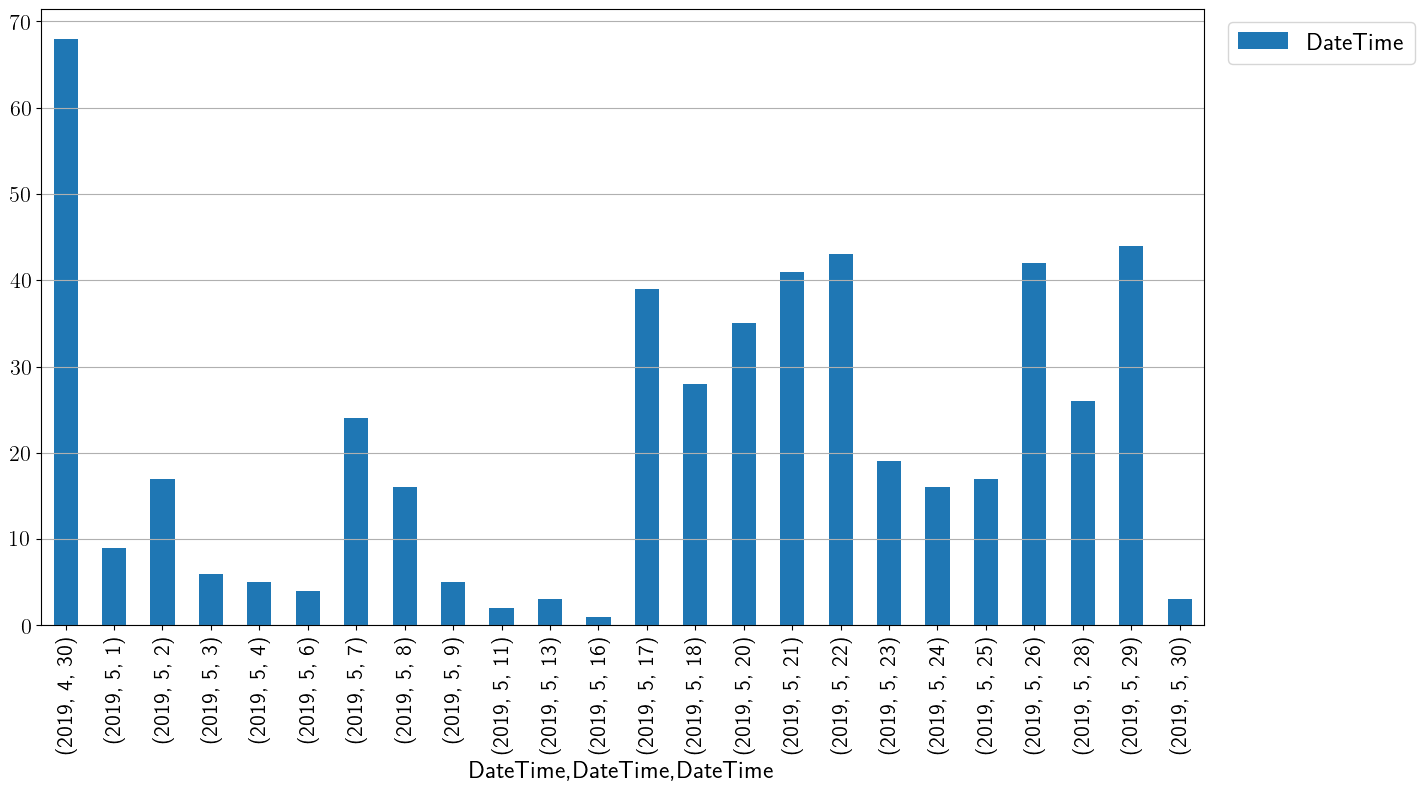

In [28]:
df = df_storm_report.copy()
#df = df.set_index('DateTime')
#['2019-04-28':'2019-06-03']
#df = df.reset_index()

#df['start_datetime_utc'].dt.day_of_year
by = [df['DateTime'].dt.year, df['DateTime'].dt.month, df['DateTime'].dt.day]
bar_plt = df['DateTime'].groupby(by).count().plot(kind="bar", x='DateTime', figsize=(15,8))
bar_plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
#ax.set_axisbelow(True)
plt.rc('axes', axisbelow=True)
plt.grid(axis='y')

df['DateTime'].groupby(by).count()

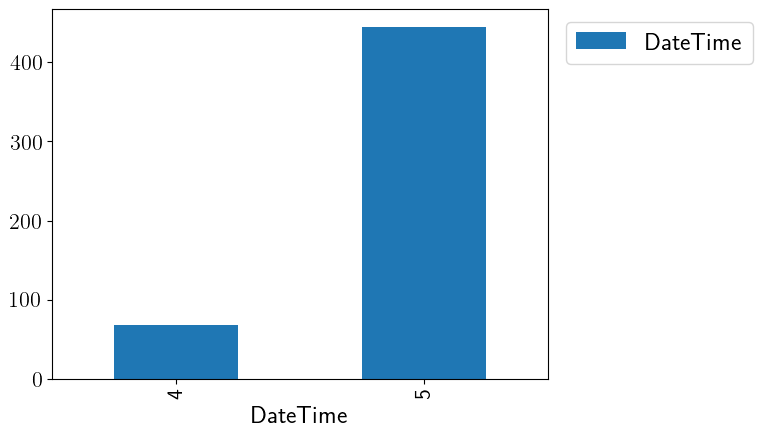

In [29]:
by = [df['DateTime'].dt.month]
bar_plt = df['DateTime'].groupby(by).count().plot(kind="bar", x='DateTime') #, figsize=(15,8))
bar_plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1))

## LOAD WOFS PREDS

In [30]:
os.listdir(dir_wofs_preds)

['2019', '2018', '2023']

In [31]:
#WOFS_REL_PATH = f"{DATE}/{INIT_TIME}/ENS_MEM_{e}"
#_dir_preds = f"{DIR_PREDS}/{YEAR}/{WOFS_REL_PATH}"
_dirpreds = os.path.join(dir_wofs_preds, str(YEAR), DATE)
os.listdir(_dirpreds)

['2030',
 '2330',
 '2230',
 '0100',
 '2130',
 '2100',
 '0030',
 '2200',
 '0130',
 '0200',
 '1900',
 '1930',
 '0300',
 '2000',
 '0000',
 '0230',
 'wofs_preds_files.csv',
 '2300']

In [32]:
_dirpreds

'/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jtti/wofs_preds/2019/20190430'

In [33]:
df_date_files = pd.read_csv(f'{_dirpreds}/wofs_preds_files.csv')
df_date_files.head() #df_date_files.columns

Unnamed: 0  run_date  init_time ensemble_member        forecast_time                                      filename_path
0       13570  20190430          0       ENS_MEM_1  2019-05-01_00:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
1       13560  20190430          0       ENS_MEM_1  2019-05-01_00:05:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
2       13559  20190430          0       ENS_MEM_1  2019-05-01_00:10:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
3       13610  20190430          0       ENS_MEM_1  2019-05-01_00:15:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
4       13558  20190430          0       ENS_MEM_1  2019-05-01_00:20:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...

## ORGANIZE ENSEMBLES

In [34]:
dir_wofs, DATE

('/ourdisk/hpc/ai2es/wofs/2019', '20190430')

In [35]:
#ens_names = glob.glob(os.path.join(_dirpreds, '1900', '*'))
ens_names = sorted(os.listdir(os.path.join(dir_wofs, DATE, '1900')))
ens_names, len(ens_names)

(['ENS_MEM_1',
  'ENS_MEM_10',
  'ENS_MEM_11',
  'ENS_MEM_12',
  'ENS_MEM_13',
  'ENS_MEM_14',
  'ENS_MEM_15',
  'ENS_MEM_16',
  'ENS_MEM_17',
  'ENS_MEM_18',
  'ENS_MEM_2',
  'ENS_MEM_3',
  'ENS_MEM_4',
  'ENS_MEM_5',
  'ENS_MEM_6',
  'ENS_MEM_7',
  'ENS_MEM_8',
  'ENS_MEM_9'],
 18)

In [36]:
init_time = '1900'
_dir = os.path.join(dir_wofs_preds, str(YEAR))
save_path = None #os.path.join(save_path, 'wofs_preds_files.csv')
df_files_ens9 = wpe.generate_ensemble_files_list(_dir, DATE, init_time, 
                                                 'ENS_MEM_9', 
                                                 save_path=save_path, 
                                                 **extr_args)

df_all_files = wpe.generate_ensemble_files_list_all(_dir, DATE, init_time, 
                                                    ens_names=[], 
                                                    save_path=save_path, 
                                                    df_index=False, **extr_args)

print(df_all_files.shape)
df_all_files.head(12)

(1350, 5)


run_date init_time ensemble_member        forecast_time                                      filename_path
0   20190430      1900       ENS_MEM_1  2019-04-30_19:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
1   20190430      1900       ENS_MEM_1  2019-04-30_19:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
2   20190430      1900       ENS_MEM_1  2019-04-30_19:05:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
3   20190430      1900       ENS_MEM_1  2019-04-30_19:10:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
4   20190430      1900       ENS_MEM_1  2019-04-30_19:15:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
5   20190430      1900       ENS_MEM_1  2019-04-30_19:20:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
6   20190430      1900       ENS_MEM_1  2019-04-30_19:25:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
7   20190430      1900       ENS_MEM_1  2019-04-30_19:30:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
8   20190430      1900       ENS_MEM_1  2019-04-30_19:35:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
9   20190430      1900       ENS_MEM_1  2019-04-30_19:40:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
10  20190430      1900       ENS_MEM_1  2019-04-30_19:45:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
11  20190430      1900       ENS_MEM_1  2019-04-30_19:50:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...

In [37]:
df_all_files['filename_path'].iloc[:4].values

array(['/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jtti/wofs_preds/2019/20190430/1900/ENS_MEM_1/wrfout_d01_2019-04-30_19:00:00_predictions.nc',
       '/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jtti/wofs_preds/2019/20190430/1900/ENS_MEM_1/wrfwof_d01_2019-04-30_19:00:00_predictions.nc',
       '/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jtti/wofs_preds/2019/20190430/1900/ENS_MEM_1/wrfwof_d01_2019-04-30_19:05:00_predictions.nc',
       '/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jtti/wofs_preds/2019/20190430/1900/ENS_MEM_1/wrfwof_d01_2019-04-30_19:10:00_predictions.nc'],
      dtype=object)

In [38]:
ftime = '2019-04-30_19:05:00'
_files = select_files(df_all_files, init_time, ftime, emember=None)
_files.shape

(18, 5)

In [39]:
_files.head()

run_date init_time ensemble_member        forecast_time                                      filename_path
2    20190430      1900       ENS_MEM_1  2019-04-30_19:05:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
77   20190430      1900      ENS_MEM_10  2019-04-30_19:05:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
152  20190430      1900      ENS_MEM_11  2019-04-30_19:05:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
227  20190430      1900      ENS_MEM_12  2019-04-30_19:05:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
302  20190430      1900      ENS_MEM_13  2019-04-30_19:05:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...

In [40]:
pd.unique(_files['forecast_time']), pd.unique(_files['ensemble_member'])

(array(['2019-04-30_19:05:00'], dtype=object),
 array(['ENS_MEM_1', 'ENS_MEM_10', 'ENS_MEM_11', 'ENS_MEM_12',
        'ENS_MEM_13', 'ENS_MEM_14', 'ENS_MEM_15', 'ENS_MEM_16',
        'ENS_MEM_17', 'ENS_MEM_18', 'ENS_MEM_2', 'ENS_MEM_3', 'ENS_MEM_4',
        'ENS_MEM_5', 'ENS_MEM_6', 'ENS_MEM_7', 'ENS_MEM_8', 'ENS_MEM_9'],
       dtype=object))

In [41]:
_files = select_files(df_all_files, init_time, None, emember='ENS_MEM_14')
_files.shape

(75, 5)

In [42]:
pd.unique(_files['ensemble_member'])

array(['ENS_MEM_14'], dtype=object)

In [43]:
pd.unique(_files['forecast_time'])

array(['2019-04-30_19:00:00', '2019-04-30_19:05:00',
       '2019-04-30_19:10:00', '2019-04-30_19:15:00',
       '2019-04-30_19:20:00', '2019-04-30_19:25:00',
       '2019-04-30_19:30:00', '2019-04-30_19:35:00',
       '2019-04-30_19:40:00', '2019-04-30_19:45:00',
       '2019-04-30_19:50:00', '2019-04-30_19:55:00',
       '2019-04-30_20:00:00', '2019-04-30_20:05:00',
       '2019-04-30_20:10:00', '2019-04-30_20:15:00',
       '2019-04-30_20:20:00', '2019-04-30_20:25:00',
       '2019-04-30_20:30:00', '2019-04-30_20:35:00',
       '2019-04-30_20:40:00', '2019-04-30_20:45:00',
       '2019-04-30_20:50:00', '2019-04-30_20:55:00',
       '2019-04-30_21:00:00', '2019-04-30_21:05:00',
       '2019-04-30_21:10:00', '2019-04-30_21:15:00',
       '2019-04-30_21:20:00', '2019-04-30_21:25:00',
       '2019-04-30_21:30:00', '2019-04-30_21:35:00',
       '2019-04-30_21:40:00', '2019-04-30_21:45:00',
       '2019-04-30_21:50:00', '2019-04-30_21:55:00',
       '2019-04-30_22:00:00', '2019-04-30_22:0

In [44]:
df_files_ens9.dtypes['init_time'], type(df_files_ens9['init_time'][0]), df_files_ens9['init_time'][0]

(dtype('O'), str, '1900')

In [45]:
df_files_ens9.shape, df_files_ens9['filename_path'].iloc[:4].values

((75, 5),
 array(['/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jtti/wofs_preds/2019/20190430/1900/ENS_MEM_9/wrfout_d01_2019-04-30_19:00:00_predictions.nc',
        '/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jtti/wofs_preds/2019/20190430/1900/ENS_MEM_9/wrfwof_d01_2019-04-30_19:00:00_predictions.nc',
        '/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jtti/wofs_preds/2019/20190430/1900/ENS_MEM_9/wrfwof_d01_2019-04-30_19:05:00_predictions.nc',
        '/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jtti/wofs_preds/2019/20190430/1900/ENS_MEM_9/wrfwof_d01_2019-04-30_19:10:00_predictions.nc'],
       dtype=object))

In [46]:
df_files_ens9.head(6)

run_date init_time ensemble_member        forecast_time                                      filename_path
0  20190430      1900       ENS_MEM_9  2019-04-30_19:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
2  20190430      1900       ENS_MEM_9  2019-04-30_19:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
3  20190430      1900       ENS_MEM_9  2019-04-30_19:05:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
4  20190430      1900       ENS_MEM_9  2019-04-30_19:10:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
5  20190430      1900       ENS_MEM_9  2019-04-30_19:15:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
6  20190430      1900       ENS_MEM_9  2019-04-30_19:20:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...

In [47]:
df_all_files.shape

(1350, 5)

In [48]:
# merge ensembles into dataset for single forecast time
ftime = '2019-04-30_19:05:00'
sel_files_ftime = select_files(df_all_files, init_time, ftime, emember=None)
print(sel_files_ftime.shape)

concat_dim = 'ENS'
_sel_files = list(sel_files_ftime['filename_path'])
wofs_preds = xr.open_mfdataset(_sel_files, concat_dim=concat_dim,
                               combine='nested', decode_times=False)
print(wofs_preds['Time'])
_dtime = num2date(wofs_preds.Time, 'seconds since 2001-01-01')
print("DateTime", _dtime)
wofs_preds.drop_vars('Time')

stat = 'median'
wofs_cZH = {stat: None}
wofs_prob = {stat: None}
wofs_uh = {stat: None}

if stat == 'median':
    wofs_cZH[stat] = wofs_preds['COMPOSITE_REFL_10CM'].median(dim=concat_dim).values[0]
    wofs_prob[stat] = wofs_preds['ML_PREDICTED_TOR'].median(dim=concat_dim).values[0]
    wofs_uh[stat] = wofs_preds['UP_HELI_MAX'].median(dim=concat_dim).values[0]
#getattr(my_instance, method_name)() 'UP_HELI_MAX'
elif stat == 'mean':
    wofs_cZH[stat] = wofs_preds['COMPOSITE_REFL_10CM'].mean(dim=concat_dim).values[0]
    wofs_prob[stat] = wofs_preds['ML_PREDICTED_TOR'].mean(dim=concat_dim).values[0]
    wofs_uh[stat] = wofs_preds['UP_HELI_MAX'].mean(dim=concat_dim).values[0]

#year, date, init, ens, ftime: ml_preds, storm_mask, uh_mask

(18, 5)
<xarray.DataArray 'Time' (Time: 1)>
array([578343900])
Coordinates:
  * Time     (Time) int64 578343900
DateTime [cftime.DatetimeGregorian(2019, 4, 30, 19, 5, 0, 0, has_year_zero=False)]


### def compute_ensemble_stat

In [49]:
def compute_ensemble_stat(stat, df_all_files, init_time, ftime, emember=None, 
                          rdate=None, concat_dim='ENS', DB=False):
    '''
    stat: str. mean|median
    init_time: str
    ftime: str for forecast time following format: 2019-04-30_19:05:00
    '''
    # merge ensembles into dataset for single forecast time
    sel_files_ftime = select_files(df_all_files, init_time, ftime, 
                                   emember=emember, rdate=rdate)

    _sel_files = list(sel_files_ftime['filename_path'])
    wofs_preds = xr.open_mfdataset(_sel_files, concat_dim=concat_dim,
                                   combine='nested', decode_times=False,
                                   coords='minimal')
    dtime = num2date(wofs_preds.Time[0], 'seconds since 2001-01-01')
    nmembers = sel_files_ftime.shape[0]
    if DB or nmembers != 18:
        print(sel_files_ftime.shape)
        print(f"wofs_preds['Time']={wofs_preds['Time']}")
        print("DateTime", dtime)
        print("- - - - - - - - -")
    #dt_objs = num2date(wofs_20190502.Time, 'seconds since 2001-01-01')
    #dtime = dt_objs[ti]
    #print(dtime)
    wofs_preds.drop_vars('Time')

    wofs_cZH = None
    wofs_prob = None
    wofs_uh = None

    if stat == 'median':
        wofs_cZH = wofs_preds['COMPOSITE_REFL_10CM'].median(dim=concat_dim).values[0]
        wofs_prob = wofs_preds['ML_PREDICTED_TOR'].median(dim=concat_dim).values[0]
        wofs_uh = wofs_preds['UP_HELI_MAX'].median(dim=concat_dim).values[0]
    elif stat == 'mean':
        wofs_cZH = wofs_preds['COMPOSITE_REFL_10CM'].mean(dim=concat_dim).values[0]
        wofs_prob = wofs_preds['ML_PREDICTED_TOR'].mean(dim=concat_dim).values[0]
        wofs_uh = wofs_preds['UP_HELI_MAX'].mean(dim=concat_dim).values[0]

    xlats = wofs_preds['XLAT'].values[0]
    xlons = wofs_preds['XLONG'].values[0]

    #year, date, init, ens, ftime: ml_preds, storm_mask, uh_mask
    return {'cZH': wofs_cZH, 'prob': wofs_prob, 'uh': wofs_uh, 
            'datetime': dtime, 'xlat': xlats, 'xlon': xlons, 
            'attrs': wofs_preds.attrs}

In [50]:
# Dialated Probab
ksize = 33 #17
prob_dialated = grey_dilation(wofs_prob[stat], size=(ksize, ksize)) #, footprint=None, structure=None, output=None, mode='reflect', cval=0.0, origin=0)

Qs = [0, .5, .75, .9, .95, 1]

print(np.quantile(wofs_prob[stat], Qs))
print(np.quantile(prob_dialated, Qs))

[0.00000000e+00 4.77335116e-07 9.02878401e-06 5.77881891e-05
 2.15243258e-04 6.43495717e-01]
[2.44254785e-04 1.65265370e-03 5.98383152e-03 3.56835477e-02
 1.47270391e-01 6.43495717e-01]


Text(0.5, 1.0, '[median] Dilated')

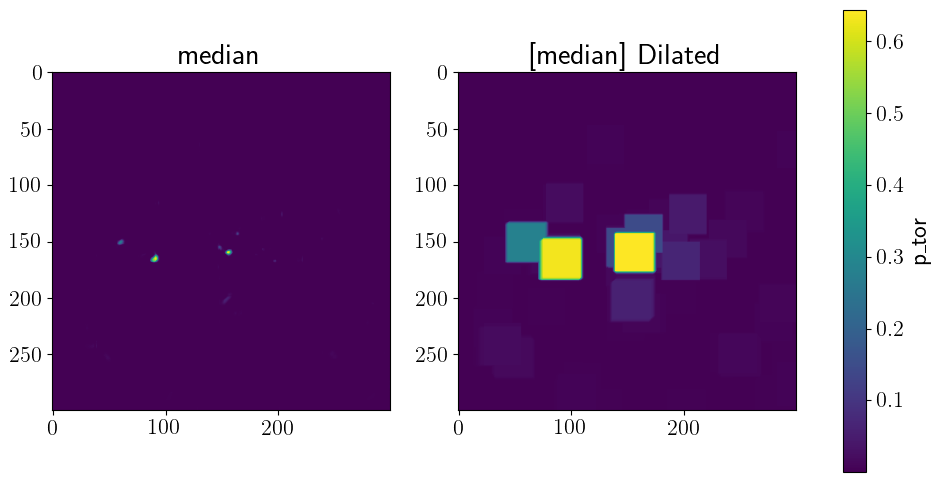

In [51]:
f_, a_ = plt.subplots(1, 2, figsize=(12, 6))
a_.ravel()

im = a_[0].imshow(wofs_prob[stat]) #, cmap='civiridis')
#plt.colorbar(im, ax=a_, label=r'p_{tor}')
a_[0].set_title(stat)

# Dialated Probab                             
im = a_[1].imshow(prob_dialated) #, cmap='civiridis')
plt.colorbar(im, ax=a_, label=r'p_{tor}')
a_[1].set_title(f'[{stat}] Dilated')

In [52]:
del f_, a_, im

## load ...

In [53]:
#fnpath_all_ens = os.path.join(_dirpreds, '1900', 'ENS_MEM_1', '*')
_list = df_all_files['filename_path'].values
xrload_args = {'combine': 'nested', #'concat_dim': 'forecast', 
               'decode_times': False, 'engine': 'netcdf4'}
wofs_test = xr.open_mfdataset(_list[:20], **xrload_args)

In [54]:
wofs_test.coords

xr version 2023.8.0
np version 1.24.2
pd version 1.5.3


Coordinates:
  * Time     (Time) int64 578343600 578343900 578344200 ... 578348700 578349000
    XLAT     (Time, south_north, west_east) float32 dask.array<chunksize=(19, 300, 300), meta=np.ndarray>
    XLONG    (Time, south_north, west_east) float32 dask.array<chunksize=(19, 300, 300), meta=np.ndarray>
    XLAT_U   (Time, south_north, west_east_stag) float32 dask.array<chunksize=(19, 300, 301), meta=np.ndarray>
    XLAT_V   (Time, south_north_stag, west_east) float32 dask.array<chunksize=(19, 301, 300), meta=np.ndarray>
    XLONG_U  (Time, south_north, west_east_stag) float32 dask.array<chunksize=(19, 300, 301), meta=np.ndarray>
    XLONG_V  (Time, south_north_stag, west_east) float32 dask.array<chunksize=(19, 301, 300), meta=np.ndarray>
    XTIME    (Time) float32 dask.array<chunksize=(19,), meta=np.ndarray>

In [55]:
wofs_test.dims

Frozen({'Time': 19, 'south_north': 300, 'west_east': 300, 'bottom_top': 50, 'south_north_stag': 301, 'west_east_stag': 301, 'bottom_top_stag': 51})

In [56]:
wofs_test.attrs

{'TITLE': ' OUTPUT FROM WRF V3.8 MODEL',
 'START_DATE': '2019-04-30_19:00:00',
 'SIMULATION_START_DATE': '2019-04-30_19:00:00',
 'WEST-EAST_GRID_DIMENSION': 301,
 'SOUTH-NORTH_GRID_DIMENSION': 301,
 'BOTTOM-TOP_GRID_DIMENSION': 51,
 'DX': 3000.0,
 'DY': 3000.0,
 'SKEBS_ON': 0,
 'SPEC_BDY_FINAL_MU': 0,
 'USE_Q_DIABATIC': 0,
 'GRIDTYPE': 'C',
 'DIFF_OPT': 1,
 'KM_OPT': 4,
 'DAMP_OPT': 3,
 'DAMPCOEF': 0.2,
 'KHDIF': 0.0,
 'KVDIF': 0.0,
 'MP_PHYSICS': 18,
 'RA_LW_PHYSICS': 1,
 'RA_SW_PHYSICS': 1,
 'SF_SFCLAY_PHYSICS': 1,
 'SF_SURFACE_PHYSICS': 3,
 'BL_PBL_PHYSICS': 1,
 'CU_PHYSICS': 0,
 'SF_LAKE_PHYSICS': 0,
 'SURFACE_INPUT_SOURCE': 1,
 'SST_UPDATE': 0,
 'GRID_FDDA': 0,
 'GFDDA_INTERVAL_M': 0,
 'GFDDA_END_H': 0,
 'GRID_SFDDA': 0,
 'SGFDDA_INTERVAL_M': 0,
 'SGFDDA_END_H': 0,
 'HYPSOMETRIC_OPT': 2,
 'USE_THETA_M': 0,
 'SF_URBAN_PHYSICS': 0,
 'SHCU_PHYSICS': 0,
 'MFSHCONV': 0,
 'FEEDBACK': 0,
 'SMOOTH_OPTION': 0,
 'SWRAD_SCAT': 1.0,
 'W_DAMPING': 1,
 'RADT': 5.0,
 'BLDT': 0.0,
 'CUDT': 0.0,
 

In [57]:
wofs_test.data_vars

Data variables:
    ML_PREDICTED_TOR     (Time, south_north, west_east) float64 dask.array<chunksize=(19, 300, 300), meta=np.ndarray>
    Times                (Time) object dask.array<chunksize=(19,), meta=np.ndarray>
    V                    (Time, bottom_top, south_north_stag, west_east) float32 dask.array<chunksize=(19, 50, 301, 300), meta=np.ndarray>
    U                    (Time, bottom_top, south_north, west_east_stag) float32 dask.array<chunksize=(19, 50, 300, 301), meta=np.ndarray>
    UP_HELI_MAX          (Time, south_north, west_east) float32 dask.array<chunksize=(19, 300, 300), meta=np.ndarray>
    PB                   (Time, bottom_top, south_north, west_east) float32 dask.array<chunksize=(19, 50, 300, 300), meta=np.ndarray>
    PH                   (Time, bottom_top_stag, south_north, west_east) float32 dask.array<chunksize=(19, 51, 300, 300), meta=np.ndarray>
    HGT                  (Time, south_north, west_east) float32 dask.array<chunksize=(19, 300, 300), meta=np.ndar

In [58]:
'''
wofs_test.attrs['FORECAST_DATETIME']
wofs_test.START_DATE

datetime_forecast_str = wofs.Times.data[0].decode('ascii') # decode from binary str to regular text str
datetime_forecast = datetime.fromisoformat(datetime_forecast_str)
datetime_init = datetime.fromisoformat(wofs.START_DATE) 

datetime_int = num2date(wofs.time.values[0], seconds_since) #
forecast_time = np.datetime64(datetime_int)
'''
wofs_test.Times.values

array([b'2019-04-30_19:00:00', b'2019-04-30_19:05:00',
       b'2019-04-30_19:10:00', b'2019-04-30_19:15:00',
       b'2019-04-30_19:20:00', b'2019-04-30_19:25:00',
       b'2019-04-30_19:30:00', b'2019-04-30_19:35:00',
       b'2019-04-30_19:40:00', b'2019-04-30_19:45:00',
       b'2019-04-30_19:50:00', b'2019-04-30_19:55:00',
       b'2019-04-30_20:00:00', b'2019-04-30_20:05:00',
       b'2019-04-30_20:10:00', b'2019-04-30_20:15:00',
       b'2019-04-30_20:20:00', b'2019-04-30_20:25:00',
       b'2019-04-30_20:30:00'], dtype=object)

In [59]:
# Decode from binary string to text
[t.decode('ascii') for t in wofs_test.Times.values]
#wofs_test.Times.values[0].decode('ascii')

['2019-04-30_19:00:00',
 '2019-04-30_19:05:00',
 '2019-04-30_19:10:00',
 '2019-04-30_19:15:00',
 '2019-04-30_19:20:00',
 '2019-04-30_19:25:00',
 '2019-04-30_19:30:00',
 '2019-04-30_19:35:00',
 '2019-04-30_19:40:00',
 '2019-04-30_19:45:00',
 '2019-04-30_19:50:00',
 '2019-04-30_19:55:00',
 '2019-04-30_20:00:00',
 '2019-04-30_20:05:00',
 '2019-04-30_20:10:00',
 '2019-04-30_20:15:00',
 '2019-04-30_20:20:00',
 '2019-04-30_20:25:00',
 '2019-04-30_20:30:00']

In [60]:
wofs_test = wofs_test.sortby("Time") 
wofs_test.Time

<xarray.DataArray 'Time' (Time: 19)>
array([578343600, 578343900, 578344200, 578344500, 578344800, 578345100,
       578345400, 578345700, 578346000, 578346300, 578346600, 578346900,
       578347200, 578347500, 578347800, 578348100, 578348400, 578348700,
       578349000])
Coordinates:
  * Time     (Time) int64 578343600 578343900 578344200 ... 578348700 578349000
    XTIME    (Time) float32 dask.array<chunksize=(19,), meta=np.ndarray>

In [61]:
dt_objs = num2date(wofs_test.Time, 'seconds since 2001-01-01')
dt_objs

array([cftime.DatetimeGregorian(2019, 4, 30, 19, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2019, 4, 30, 19, 5, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2019, 4, 30, 19, 10, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2019, 4, 30, 19, 15, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2019, 4, 30, 19, 20, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2019, 4, 30, 19, 25, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2019, 4, 30, 19, 30, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2019, 4, 30, 19, 35, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2019, 4, 30, 19, 40, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2019, 4, 30, 19, 45, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2019, 4, 30, 19, 50, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2019, 4, 30, 19, 55, 0, 0, has_year_zero=False),
       cftime.DatetimeGregoria

In [62]:
dt_objs[1] - dt_objs[0]

datetime.timedelta(seconds=300)

In [63]:
forecast_times = [np.datetime64(d) for d in dt_objs]
forecast_times

[numpy.datetime64('2019-04-30T19:00:00.000000'),
 numpy.datetime64('2019-04-30T19:05:00.000000'),
 numpy.datetime64('2019-04-30T19:10:00.000000'),
 numpy.datetime64('2019-04-30T19:15:00.000000'),
 numpy.datetime64('2019-04-30T19:20:00.000000'),
 numpy.datetime64('2019-04-30T19:25:00.000000'),
 numpy.datetime64('2019-04-30T19:30:00.000000'),
 numpy.datetime64('2019-04-30T19:35:00.000000'),
 numpy.datetime64('2019-04-30T19:40:00.000000'),
 numpy.datetime64('2019-04-30T19:45:00.000000'),
 numpy.datetime64('2019-04-30T19:50:00.000000'),
 numpy.datetime64('2019-04-30T19:55:00.000000'),
 numpy.datetime64('2019-04-30T20:00:00.000000'),
 numpy.datetime64('2019-04-30T20:05:00.000000'),
 numpy.datetime64('2019-04-30T20:10:00.000000'),
 numpy.datetime64('2019-04-30T20:15:00.000000'),
 numpy.datetime64('2019-04-30T20:20:00.000000'),
 numpy.datetime64('2019-04-30T20:25:00.000000'),
 numpy.datetime64('2019-04-30T20:30:00.000000')]

In [64]:
forecast_times[1] - forecast_times[0]

numpy.timedelta64(300000000,'us')

In [65]:
np.quantile(wofs_test['XLAT'].values, [0,1]), np.quantile(wofs_test['XLONG'].values, [0,1])

(array([31.894531, 40.25494 ], dtype=float32),
 array([-101.79907,  -90.91565], dtype=float32))

In [66]:
np.quantile(wofs_test['XLAT'].values, [0,1]), np.quantile(wofs_test['XLONG'].values, [0,1])

(array([31.894531, 40.25494 ], dtype=float32),
 array([-101.79907,  -90.91565], dtype=float32))

In [67]:
wofs_test['XLAT'].values[:2, :4, :4]

array([[[31.894531, 31.896152, 31.89777 , 31.89936 ],
        [31.92168 , 31.923302, 31.924911, 31.926517],
        [31.948833, 31.95045 , 31.952065, 31.953663],
        [31.975983, 31.977608, 31.979221, 31.980824]],

       [[31.894531, 31.896152, 31.89777 , 31.89936 ],
        [31.92168 , 31.923302, 31.924911, 31.926517],
        [31.948833, 31.95045 , 31.952065, 31.953663],
        [31.975983, 31.977608, 31.979221, 31.980824]]], dtype=float32)

In [68]:
np.diff(wofs_test['XLAT'].values[:2, :4, :4], n=1, axis=1)

array([[[0.0271492 , 0.0271492 , 0.02714157, 0.02715683],
        [0.02715302, 0.0271492 , 0.02715302, 0.02714539],
        [0.0271492 , 0.02715683, 0.02715683, 0.02716064]],

       [[0.0271492 , 0.0271492 , 0.02714157, 0.02715683],
        [0.02715302, 0.0271492 , 0.02715302, 0.02714539],
        [0.0271492 , 0.02715683, 0.02715683, 0.02716064]]], dtype=float32)

In [69]:
diffs_xlat = np.diff(wofs_test['XLAT'].values[0, :4, :4], n=1, axis=0)
diffs_xlat.mean()

0.027151743

In [70]:
wofs_test['XLONG'].values[:2, :4, :4]

array([[[-101.14868 , -101.1167  , -101.08475 , -101.052765],
        [-101.150604, -101.11862 , -101.08664 , -101.05463 ],
        [-101.15253 , -101.120514, -101.08853 , -101.05652 ],
        [-101.15445 , -101.12244 , -101.09042 , -101.05841 ]],

       [[-101.14868 , -101.1167  , -101.08475 , -101.052765],
        [-101.150604, -101.11862 , -101.08664 , -101.05463 ],
        [-101.15253 , -101.120514, -101.08853 , -101.05652 ],
        [-101.15445 , -101.12244 , -101.09042 , -101.05841 ]]],
      dtype=float32)

In [71]:
np.diff(wofs_test['XLONG'].values[:2, :4, :4], n=1, axis=2)

array([[[0.03198242, 0.0319519 , 0.03198242],
        [0.03198242, 0.03198242, 0.03201294],
        [0.03201294, 0.03198242, 0.03201294],
        [0.03201294, 0.03201294, 0.03201294]],

       [[0.03198242, 0.0319519 , 0.03198242],
        [0.03198242, 0.03198242, 0.03201294],
        [0.03201294, 0.03198242, 0.03201294],
        [0.03201294, 0.03201294, 0.03201294]]], dtype=float32)

In [72]:
diffs_xlons = np.diff(wofs_test['XLONG'].values[:2, :4, :4], n=1, axis=2)
diffs_xlons.mean()

0.031995136

In [73]:
diffs_xlons = np.diff(wofs_test['XLONG'].values[0, :4, :4], n=1, axis=1)
diffs_xlons.mean()

0.031995136

# GENERATE STORM REPORT MASKS

In [74]:
GRIDSIZE = 3 # km
thres_dist = 50. # km
thres_time = 20 # min

In [75]:
init_time

'1900'

In [76]:
# Set reports to index by DateTime for convenience
_storm_reports = df_storm_report.copy()
_storm_reports = _storm_reports.set_index('DateTime')

In [77]:
_storm_reports['2019-05-02 19:00':'2019-05-03']

Time F_Scale                 Location       County State    Lat     Lon                                           Comments
DateTime                                                                                                                                       
2019-05-02 19:23:00  1923     UNK      2 S FOURMILE CORNER      PRAIRIE    AR  34.95  -91.57  MULTIPLE REPORTS VIA SOCIAL MEDIA... INCLUDING...
2019-05-02 19:45:00  1945     UNK             3 SE SWIFTON      JACKSON    AR  35.80  -91.08             TORNADO REPORTED ON HIGHWAY 226. (LZK)
2019-05-02 19:57:00  1957     UNK               2 SW REVEL     WOODRUFF    AR  35.21  -91.31  BROADCAST MEDIA VIEWER SENT PICTURE OF TORNADO...
2019-05-02 21:29:00  2129     UNK                4 NE LAFE       GREENE    AR  36.25  -90.46  EMERGENCY MANAGER REPORTED TORNADO NEAR KNOB.....
2019-05-02 22:02:00  2202     UNK        1 WNW BLYTHEVILLE  MISSISSIPPI    AR  35.94  -89.95         BRIEF TORNADO REPORTED NEAR GOSNELL. (MEG)
2019-05-02 23:11:00  2311     UNK     4 SSE CARUTHERSVILLE     PEMISCOT    MO  36.13  -89.63  EF-0 TORNADO UPROOTED TREES NEAR COUNTY ROAD 5...
2019-05-02 23:19:00  2319     UNK     2 ENE CARUTHERSVILLE         LAKE    TN  36.20  -89.63     TORNADO REPORTED EAST OF CARUTHERSVILLE. (MEG)
2019-05-02 23:21:00  2321     UNK            3 ESE RIDGELY        OBION    TN  36.24  -89.43  EF-0 TORNADO CAUSED TREE DAMAGE ALONG BLUFF RO...
2019-05-02 23:43:00  2343     UNK           2 WNW HORNBEAK        OBION    TN  36.34  -89.33  BRIEF TORNADO CAUSED TREE DAMAGE ALONG HIGHWAY...
2019-05-03 13:20:00  1320     UNK           6 ENE FLATONIA      FAYETTE    TX  29.73  -97.01  CONFIRMED VIA FAYETTE COUNTY LAW ENFORCEMENT. ...
2019-05-03 14:07:00  1407     UNK          5 WNW LA GRANGE      FAYETTE    TX  29.92  -96.95  REPORTS OF DAMAGE TO MULTIPLE INDUSTRIAL BUILD...
2019-05-03 18:23:00  1823     UNK      2 W RAYNER JUNCTION     COLORADO    TX  29.55  -96.36  REPORT OF TORNADO TOUCH DOWN IN FIELD. VIDEO O...
2019-05-03 19:00:00  1900     UNK                 TREICHEL       HARRIS    TX  30.08  -95.65  TRAINED SPOTTER VIDEO OF BRIEF TOUCHDOWN SOUTH...
2019-05-03 20:50:00  2050     UNK  3 NNE LION COUNTRY SAFA   PALM BEACH    FL  26.75  -80.35  NWS STORM SURVEY OF THE LOXAHATCHEE AREA FOUND...
2019-05-03 23:34:00  2334     UNK         7 N ST. LAWRENCE    Glasscock    TX  31.80 -101.54                                              (MAF)

## May 2 2019

In [78]:
# May 2 2019
_df_files_20190502 = wpe.generate_ensemble_files_list_all(_dir, date='20190502', 
                                                          itime=init_time, 
                                                          ens_names=[], 
                                                          save_path=None, 
                                                          df_index=False, 
                                                          **extr_args)
_list = _df_files_20190502['filename_path'].values
_list

array(['/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jtti/wofs_preds/2019/20190502/1900/ENS_MEM_1/wrfout_d01_2019-05-02_19:00:00_predictions.nc',
       '/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jtti/wofs_preds/2019/20190502/1900/ENS_MEM_1/wrfwof_d01_2019-05-02_19:00:00_predictions.nc',
       '/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jtti/wofs_preds/2019/20190502/1900/ENS_MEM_1/wrfwof_d01_2019-05-02_19:05:00_predictions.nc',
       ...,
       '/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jtti/wofs_preds/2019/20190502/1900/ENS_MEM_9/wrfwof_d01_2019-05-03_00:55:00_predictions.nc',
       '/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jtti/wofs_preds/2019/20190502/1900/ENS_MEM_9/wrfout_d01_2019-05-03_01:00:00_predictions.nc',
       '/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jtti/wofs_preds/2019/20190502/1900/ENS_MEM_9/wrfwof_d01_2019-05-03_01:00:00_predictions.nc'],
      dtype=object)

In [79]:
_df_files_20190502.shape

(1350, 5)

In [80]:
_df_files_20190502.head(9)

run_date init_time ensemble_member        forecast_time                                      filename_path
0  20190502      1900       ENS_MEM_1  2019-05-02_19:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
1  20190502      1900       ENS_MEM_1  2019-05-02_19:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
2  20190502      1900       ENS_MEM_1  2019-05-02_19:05:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
3  20190502      1900       ENS_MEM_1  2019-05-02_19:10:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
4  20190502      1900       ENS_MEM_1  2019-05-02_19:15:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
5  20190502      1900       ENS_MEM_1  2019-05-02_19:20:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
6  20190502      1900       ENS_MEM_1  2019-05-02_19:25:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
7  20190502      1900       ENS_MEM_1  2019-05-02_19:30:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
8  20190502      1900       ENS_MEM_1  2019-05-02_19:35:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...

In [81]:
ti = 8
ftime = _df_files_20190502['forecast_time'][ti]
print(f"Forecast Time {ftime} ({ti})")
wofs_mean_20190502 = compute_ensemble_stat('mean', _df_files_20190502, 
                                           init_time, ftime=ftime, 
                                           concat_dim='ENS', DB=True)
#{'cZH': wofs_cZH, 'prob': wofs_prob, 'uh': wofs_uh, 'datetime': dtime}

Forecast Time 2019-05-02_19:35:00 (8)


(18, 5)
wofs_preds['Time']=<xarray.DataArray 'Time' (Time: 1)>
array([578518500])
Coordinates:
  * Time     (Time) int64 578518500
DateTime 2019-05-02 19:35:00
- - - - - - - - -


In [82]:
df_all_files['run_date'].unique()

array(['20190430'], dtype=object)

In [156]:
# All storms on day
by = [df_storm_report['DateTime'].dt.year==2019, 
      df_storm_report['DateTime'].dt.month==5, 
      df_storm_report['DateTime'].dt.day==2]
inds = df_storm_report['DateTime'].groupby(by).groups[(True, True, True)]
df_storm_report_20190502 = df.iloc[inds]
df_storm_report_20190502

Time            DateTime F_Scale              Location       County State    Lat     Lon                                           Comments
77   220 2019-05-02 02:20:00     UNK         9 NE COMSTOCK    VAL VERDE    TX  29.79 -101.09  STORM CHASER REPORTED A TORNADO APPROXIMATELY ...
78  1208 2019-05-02 12:08:00     UNK   1 N SOUTH MANSFIELD      DE SOTO    LA  32.03  -93.72  THE TORNADO BRIEFLY TOUCHED DOWN NEAR THE INTE...
79  1739 2019-05-02 17:39:00     UNK       1 WNW MABELVALE      PULASKI    AR  34.66  -92.40  THE SURVEY TEAM HAS CONFIRMED A TORNADO NEAR T...
80  1815 2019-05-02 18:15:00     UNK          2 SSW GIBSON      PULASKI    AR  34.87  -92.24  NUMEROUS TREES DOWN ALONG PORTIONS OF KELLOGG ...
81  1820 2019-05-02 18:20:00     UNK          5 N SHERWOOD      PULASKI    AR  34.90  -92.21  A TREE WAS DOWN ON A SHED AT BATESVILLE PIKE A...
82  1826 2019-05-02 18:26:00     UNK            2 ESE CATO      PULASKI    AR  34.92  -92.24  TREES WERE EITHER UPROOTED OR TREE LIMBS SNAPP...
83  1835 2019-05-02 18:35:00     UNK        3 NNW OLMSTEAD     FAULKNER    AR  34.98  -92.24  THIS WEAK TORNADO MOVED FROM NE TO SW. TREE LI...
84  1852 2019-05-02 18:52:00     UNK             2 SW OTTO     FAULKNER    AR  35.02  -92.23                HOUSE REPORTED TO BE DAMAGED. (LZK)
85  1923 2019-05-02 19:23:00     UNK   2 S FOURMILE CORNER      PRAIRIE    AR  34.95  -91.57  MULTIPLE REPORTS VIA SOCIAL MEDIA... INCLUDING...
86  1945 2019-05-02 19:45:00     UNK          3 SE SWIFTON      JACKSON    AR  35.80  -91.08             TORNADO REPORTED ON HIGHWAY 226. (LZK)
87  1957 2019-05-02 19:57:00     UNK            2 SW REVEL     WOODRUFF    AR  35.21  -91.31  BROADCAST MEDIA VIEWER SENT PICTURE OF TORNADO...
88  2129 2019-05-02 21:29:00     UNK             4 NE LAFE       GREENE    AR  36.25  -90.46  EMERGENCY MANAGER REPORTED TORNADO NEAR KNOB.....
89  2202 2019-05-02 22:02:00     UNK     1 WNW BLYTHEVILLE  MISSISSIPPI    AR  35.94  -89.95         BRIEF TORNADO REPORTED NEAR GOSNELL. (MEG)
90  2311 2019-05-02 23:11:00     UNK  4 SSE CARUTHERSVILLE     PEMISCOT    MO  36.13  -89.63  EF-0 TORNADO UPROOTED TREES NEAR COUNTY ROAD 5...
91  2319 2019-05-02 23:19:00     UNK  2 ENE CARUTHERSVILLE         LAKE    TN  36.20  -89.63     TORNADO REPORTED EAST OF CARUTHERSVILLE. (MEG)
92  2321 2019-05-02 23:21:00     UNK         3 ESE RIDGELY        OBION    TN  36.24  -89.43  EF-0 TORNADO CAUSED TREE DAMAGE ALONG BLUFF RO...
93  2343 2019-05-02 23:43:00     UNK        2 WNW HORNBEAK        OBION    TN  36.34  -89.33  BRIEF TORNADO CAUSED TREE DAMAGE ALONG HIGHWAY...

In [175]:
by = [df_storm_report['DateTime'].dt.strftime('%Y%m%d')=='20190502']
inds = df_storm_report['DateTime'].groupby(by).groups[True]
df_storm_report_20190502 = df.iloc[inds]
df_storm_report_20190502

Time            DateTime F_Scale              Location       County State    Lat     Lon                                           Comments
77   220 2019-05-02 02:20:00     UNK         9 NE COMSTOCK    VAL VERDE    TX  29.79 -101.09  STORM CHASER REPORTED A TORNADO APPROXIMATELY ...
78  1208 2019-05-02 12:08:00     UNK   1 N SOUTH MANSFIELD      DE SOTO    LA  32.03  -93.72  THE TORNADO BRIEFLY TOUCHED DOWN NEAR THE INTE...
79  1739 2019-05-02 17:39:00     UNK       1 WNW MABELVALE      PULASKI    AR  34.66  -92.40  THE SURVEY TEAM HAS CONFIRMED A TORNADO NEAR T...
80  1815 2019-05-02 18:15:00     UNK          2 SSW GIBSON      PULASKI    AR  34.87  -92.24  NUMEROUS TREES DOWN ALONG PORTIONS OF KELLOGG ...
81  1820 2019-05-02 18:20:00     UNK          5 N SHERWOOD      PULASKI    AR  34.90  -92.21  A TREE WAS DOWN ON A SHED AT BATESVILLE PIKE A...
82  1826 2019-05-02 18:26:00     UNK            2 ESE CATO      PULASKI    AR  34.92  -92.24  TREES WERE EITHER UPROOTED OR TREE LIMBS SNAPP...
83  1835 2019-05-02 18:35:00     UNK        3 NNW OLMSTEAD     FAULKNER    AR  34.98  -92.24  THIS WEAK TORNADO MOVED FROM NE TO SW. TREE LI...
84  1852 2019-05-02 18:52:00     UNK             2 SW OTTO     FAULKNER    AR  35.02  -92.23                HOUSE REPORTED TO BE DAMAGED. (LZK)
85  1923 2019-05-02 19:23:00     UNK   2 S FOURMILE CORNER      PRAIRIE    AR  34.95  -91.57  MULTIPLE REPORTS VIA SOCIAL MEDIA... INCLUDING...
86  1945 2019-05-02 19:45:00     UNK          3 SE SWIFTON      JACKSON    AR  35.80  -91.08             TORNADO REPORTED ON HIGHWAY 226. (LZK)
87  1957 2019-05-02 19:57:00     UNK            2 SW REVEL     WOODRUFF    AR  35.21  -91.31  BROADCAST MEDIA VIEWER SENT PICTURE OF TORNADO...
88  2129 2019-05-02 21:29:00     UNK             4 NE LAFE       GREENE    AR  36.25  -90.46  EMERGENCY MANAGER REPORTED TORNADO NEAR KNOB.....
89  2202 2019-05-02 22:02:00     UNK     1 WNW BLYTHEVILLE  MISSISSIPPI    AR  35.94  -89.95         BRIEF TORNADO REPORTED NEAR GOSNELL. (MEG)
90  2311 2019-05-02 23:11:00     UNK  4 SSE CARUTHERSVILLE     PEMISCOT    MO  36.13  -89.63  EF-0 TORNADO UPROOTED TREES NEAR COUNTY ROAD 5...
91  2319 2019-05-02 23:19:00     UNK  2 ENE CARUTHERSVILLE         LAKE    TN  36.20  -89.63     TORNADO REPORTED EAST OF CARUTHERSVILLE. (MEG)
92  2321 2019-05-02 23:21:00     UNK         3 ESE RIDGELY        OBION    TN  36.24  -89.43  EF-0 TORNADO CAUSED TREE DAMAGE ALONG BLUFF RO...
93  2343 2019-05-02 23:43:00     UNK        2 WNW HORNBEAK        OBION    TN  36.34  -89.33  BRIEF TORNADO CAUSED TREE DAMAGE ALONG HIGHWAY...

In [157]:
print(f"Forecast Time {ftime} ({ti})")
wofs_mean_20190502 = compute_ensemble_stat('mean', df_all_rundate_files, 
                                           init_time, ftime=ftime, 
                                           concat_dim='ENS', DB=True)

Forecast Time 2019-05-02_19:35:00 (8)


(18, 5)
wofs_preds['Time']=<xarray.DataArray 'Time' (Time: 1)>
array([578518500])
Coordinates:
  * Time     (Time) int64 578518500
DateTime 2019-05-02 19:35:00
- - - - - - - - -


In [158]:
np.quantile(wofs_mean_20190502['prob'], [0, .1, .25, .5, .9, .95, .99, 1])

array([0.00000000e+00, 1.14545236e-07, 3.94034487e-07, 4.32632611e-07,
       3.68258152e-05, 1.54806328e-04, 1.09376019e-02, 3.40636900e-01])

In [159]:
np.quantile(wofs_mean_20190502['xlat'], [0,1]), np.quantile(wofs_mean_20190502['xlon'], [0,1])

(array([27.059399, 35.273872], dtype=float32),
 array([-103.25452,  -93.19299], dtype=float32))

In [160]:
np.quantile(df_storm_report_20190502['Lat'], [0,1]), np.quantile(df_storm_report_20190502['Lon'], [0,1])

(array([29.79, 36.34]), array([-101.09,  -89.33]))

In [161]:
np.diff(wofs_mean_20190502['xlat'], n=1, axis=0).mean(), np.diff(wofs_mean_20190502['xlon'], n=1, axis=1).mean()

(0.027081253, 0.03170069)

xr version 2023.8.0
np version 1.24.2
pd version 1.5.3
netCDF4 version 1.6.3


/home/momoshog/Tornado/tornado_jtti/wofs_evaluations/wofs_preds_evaluations.py:535: RuntimeWarning: Mean of empty slice.
  delta_lat = np.diff(lats, n=1, axis=0).mean()
/home/momoshog/miniconda3/envs/tf_haggelslag/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


# Storms 0


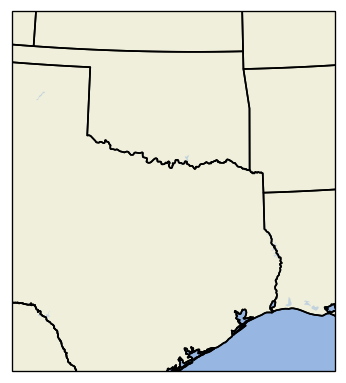

In [168]:
#TODO TODO
wofs_sample = xr.load_dataset('/ourdisk/hpc/ai2es/wofs/2019/20190502/1900/ENS_MEM_1/wrfwof_d01_2019-05-02_21:05:00')
wofs_sample = xr.load_dataset('/ourdisk/hpc/ai2es/wofs/2019/20190430/1900/ENS_MEM_1/wrfwof_d01_2019-04-30_19:10:00')

# WoFS Space
xlats = wofs_sample['XLAT'].values 
xlons = wofs_sample['XLONG'].values 

# Storm Space
lats_storm = df_storm_report['Lat'].values 
lons_storm = df_storm_report['Lon'].values
times_storms = np.array([d.to_pydatetime() for d in pd.to_datetime(df_storm_report['DateTime'].values)])

_mask, _, _ = wpe.create_storm_mask(xlats, xlons, None, 
                                    lats_storm, lons_storm, 
                                    times_storms, GRIDSIZE,
                                    thres_dist=thres_dist, 
                                    thres_time=thres_time)
print('# Storms', np.count_nonzero(_mask))

'''[wofs.attrs]
'CEN_LAT': 36.11251,
'CEN_LON': -96.35736,
'TRUELAT1': 30.0,
'TRUELAT2': 60.0,
'''
proj_dict = {'lon_0': wofs_sample.CEN_LON, 'lat_0': wofs_sample.CEN_LAT,
             'lat_1': wofs_sample.TRUELAT1, 'lat_2': wofs_sample.TRUELAT2,
             'R': 6371229 # earth radius
            }

lcc = ccrs.LambertConformal(central_longitude=proj_dict["lon_0"], 
                            central_latitude=proj_dict["lat_0"], 
                            standard_parallels=(proj_dict["lat_1"], proj_dict["lat_2"]),
                            globe=ccrs.Globe(semimajor_axis=proj_dict["R"], 
                                             semiminor_axis=proj_dict["R"]))

_f = plt.figure(figsize=(6,3), dpi=120)
_a = _f.add_axes([1, 1, 1, 1], projection=lcc)

wpe._add_cartopy(figaxs=(_f, _a))

_a.set_extent((-102, -92, 28, 38)) #-105, -90, 25, 40
#colors = mpl.cm.tab10.colors
#transform=ccrs.PlateCarree())

del wofs_sample, _f, _a

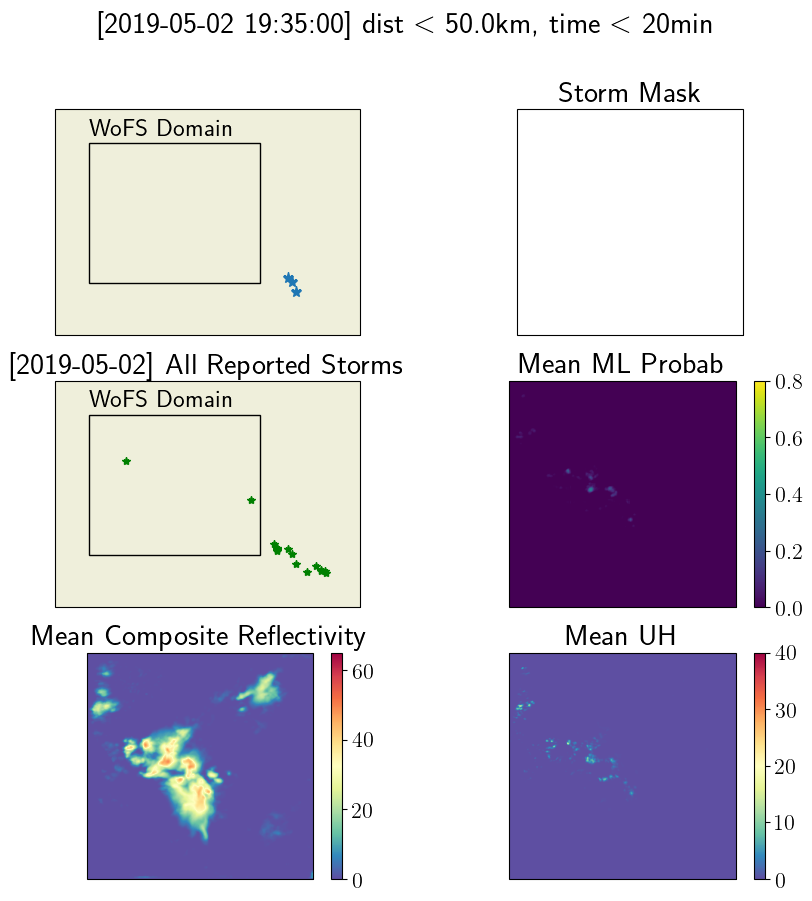

In [94]:
# May 2 2019
# Storm Reports
lats_storm = df_storm_report['Lat'].values 
lons_storm = df_storm_report['Lon'].values
times_storms = np.array([d.to_pydatetime() for d in pd.to_datetime(df_storm_report['DateTime'].values)])
#pd.to_datetime(df_storm_report['DateTime'])[0].to_pydatetime()

# WoFS Space
xlats = wofs_mean_20190502['xlat']
xlons = wofs_mean_20190502['xlon']
dtime = wofs_mean_20190502['datetime']

mask, sel_storms, tree = wpe.create_storm_mask(xlats, xlons, None, lats_storm, 
                                               lons_storm, times_storms, GRIDSIZE, 
                                               thres_dist=thres_dist, 
                                               thres_time=thres_time, kdworkers=-1)

figsize = (10, 10)
fig, axs = plt.subplots(3, 2, figsize=figsize, 
                        subplot_kw={'projection': lcc}) # ccrs.PlateCarree()
axs = axs.ravel()
figax = (fig, axs[:2])

# Add cartopy
proj_dict = {'lon_0': wofs_mean_20190502['attrs']['CEN_LON'], 
             'lat_0': wofs_mean_20190502['attrs']['CEN_LAT'],
             'lat_1': wofs_mean_20190502['attrs']['TRUELAT1'], 
             'lat_2': wofs_mean_20190502['attrs']['TRUELAT2'],
             'R': 6371229 # earth radius
            }
lcc = ccrs.LambertConformal(central_longitude=proj_dict["lon_0"], 
                            central_latitude=proj_dict["lat_0"], 
                            standard_parallels=(proj_dict["lat_1"], proj_dict["lat_2"]),
                            globe=ccrs.Globe(semimajor_axis=proj_dict["R"], 
                                             semiminor_axis=proj_dict["R"]))
wpe._add_cartopy((fig, axs), ax_projection=lcc, border_ls='--', lake_alpha=.5)


all_lats = np.append(xlats.ravel(), df_storm_report_20190502['Lat'].ravel())
all_lons = np.append(xlons.ravel(), df_storm_report_20190502['Lon'].ravel())
ylims = np.quantile(all_lats, [0, 1]) + [-2, 2]
xlims = np.quantile(all_lons, [0, 1]) + [-2, 2]

figax_storms = wpe.plot_storms(mask, lons_storm[sel_storms], lats_storm[sel_storms], 
                               figax=figax, figsize=figsize, xlims=xlims, ylims=ylims, 
                               invert_yaxis=True, 
                               bcmap=mpl.colors.ListedColormap(['w', 'blue']))


#_a = figax_storms[1][0]
#wpe._add_cartopy(figaxs=(figax_storms[0], _a))

# WoFS Domain box
xlat_range = np.quantile(xlats, [0, 1]) #
xlon_range = np.quantile(xlons, [0, 1]) #
width = np.diff(xlon_range)[0]
height = np.diff(xlat_range)[0]
rect = Rectangle((xlon_range[0], xlat_range[0]), width, height, 
                 facecolor='none', edgecolor='k')
axs[0].add_patch(rect)
axs[0].text(xlon_range[0], xlat_range[0]-.5, 'WoFS Domain')
axs[0].set_aspect("equal")

# All storms on day
axs[2].plot(df_storm_report_20190502['Lon'], df_storm_report_20190502['Lat'],
            'g*')
rect = Rectangle((xlon_range[0], xlat_range[0]), width, height, 
                 facecolor='none', edgecolor='k')
axs[2].add_patch(rect)
axs[2].text(xlon_range[0], xlat_range[0]-.5, 'WoFS Domain')
axs[2].set(xlim=xlims, ylim=ylims)
axs[2].set_title('[2019-05-02] All Reported Storms') #, pad=20)
axs[2].set_aspect("equal")
axs[2].invert_yaxis()

# Mean ML prob
im = axs[3].imshow(wofs_mean_20190502['prob'], vmin=0, vmax=.8)
axs[3].set_title('Mean ML Probab')
plt.colorbar(im, ax=axs[3])

im = axs[4].imshow(wofs_mean_20190502['cZH'], vmin=0, vmax=65, cmap='Spectral_r')
axs[4].set_title('Mean Composite Reflectivity')
plt.colorbar(im, ax=axs[4])

im = axs[5].imshow(wofs_mean_20190502['uh'], vmin=0, vmax=40, cmap='Spectral_r')
axs[5].set_title('Mean UH')
plt.colorbar(im, ax=axs[5])

figax_storms[0].suptitle(rf'[{dtime}] dist $<$ {thres_dist}km, time $<$ {thres_time}min');

nframe = 73
    Time            DateTime F_Scale              Location       County State    Lat     Lon                                           Comments
77   220 2019-05-02 02:20:00     UNK         9 NE COMSTOCK    VAL VERDE    TX  29.79 -101.09  STORM CHASER REPORTED A TORNADO APPROXIMATELY ...
78  1208 2019-05-02 12:08:00     UNK   1 N SOUTH MANSFIELD      DE SOTO    LA  32.03  -93.72  THE TORNADO BRIEFLY TOUCHED DOWN NEAR THE INTE...
79  1739 2019-05-02 17:39:00     UNK       1 WNW MABELVALE      PULASKI    AR  34.66  -92.40  THE SURVEY TEAM HAS CONFIRMED A TORNADO NEAR T...
80  1815 2019-05-02 18:15:00     UNK          2 SSW GIBSON      PULASKI    AR  34.87  -92.24  NUMEROUS TREES DOWN ALONG PORTIONS OF KELLOGG ...
81  1820 2019-05-02 18:20:00     UNK          5 N SHERWOOD      PULASKI    AR  34.90  -92.21  A TREE WAS DOWN ON A SHED AT BATESVILLE PIKE A...
82  1826 2019-05-02 18:26:00     UNK            2 ESE CATO      PULASKI    AR  34.92  -92.24  TREES WERE EITHER UPROOTED OR 

Forecast Time 2019-05-02_19:00:00 (0)


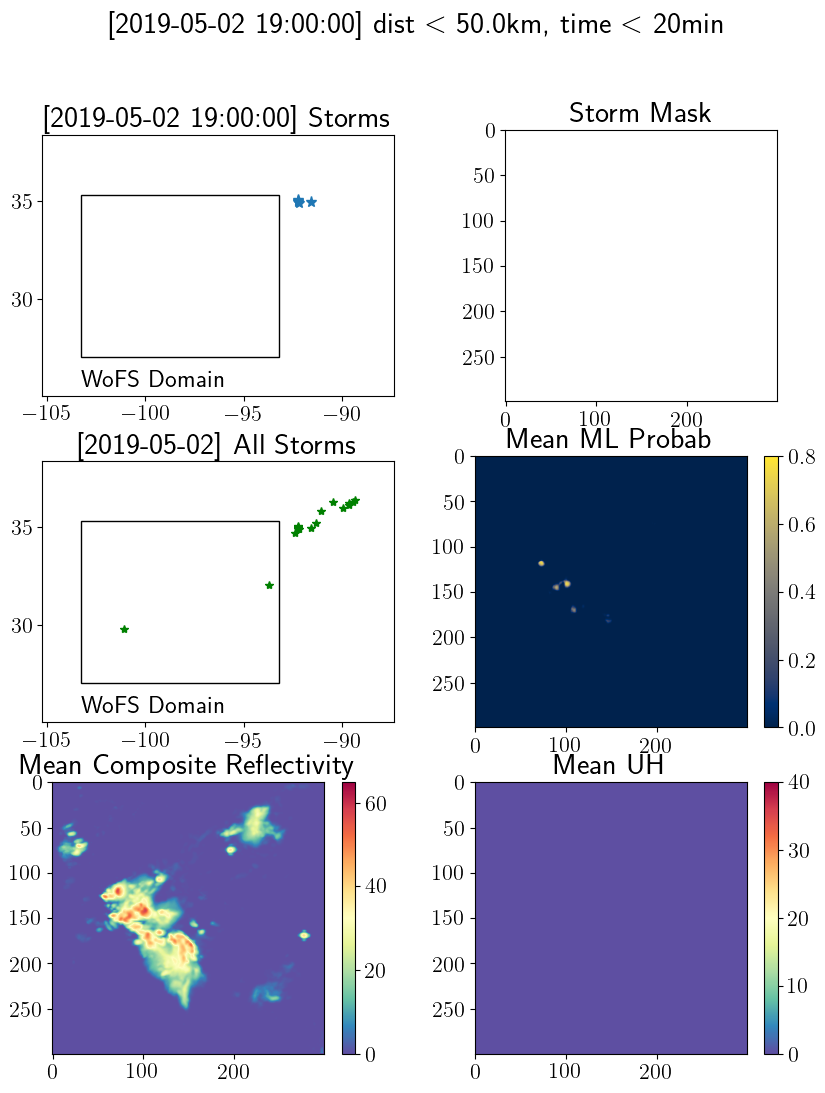

In [105]:
#{'cZH': wofs_cZH, 'prob': wofs_prob, 'uh': wofs_uh, 'datetime': dtime}
#TODO: adjust init time and space domain rendered

all_ftimes = np.unique(_df_files_20190502['forecast_time'])
nframes = len(all_ftimes)
print(f"nframe = {nframes}")

interval = 250
invert_yaxis = False

stat = 'mean'
itime = '1900'

figsize = (10, 12)
fig, axs = plt.subplots(3, 2, figsize=figsize)
axs = axs.ravel()
figax = (fig, axs[:2])

cvars = {'prob': {'ax': axs[3], 'vmin': 0, 'vmax': .8, 'cmap': 'cividis', #viridis
                    'title': 'Mean ML Probab'},
            'cZH': {'ax': axs[4], 'vmin': 0, 'vmax': 65, 'cmap': 'Spectral_r',
                    'title': 'Mean Composite Reflectivity'},
            'uh': {'ax': axs[5], 'vmin': 0, 'vmax': 40,  'cmap': 'Spectral_r',
                    'title': 'Mean UH'}}

def draw_storm_frame(pi):
    '''
    Draw a frame
    @param pi: index (aka frame index)
    '''
    axs[0].clear()

    ftime = _df_files_20190502['forecast_time'][pi] #np.unique()
    print(f"Forecast Time {ftime} ({pi})")
    wofs_mean_20190502 = compute_ensemble_stat(stat, df_all_rundate_files, #_df_files_20190502
                                               itime, ftime=ftime, 
                                               concat_dim='ENS')

    # Mean ML prob
    #im = axs[3].imshow(wofs_mean_20190502['prob'], vmin=0, vmax=.8)
    #axs[3].set_title('Mean ML Probab')
    
    # Mean ML prob, UH, cZH
    for key, val in cvars.items():
        _ax = val['ax']
        vmin = val['vmin']
        vmax = val['vmax']
        im = _ax.imshow(wofs_mean_20190502[key], vmin=vmin, vmax=vmax, 
                        cmap=val['cmap'])
        _ax.set_title(val['title'])
        #plt.colorbar(im, ax=_ax)
    
    xlats = wofs_mean_20190502['xlat']
    xlons = wofs_mean_20190502['xlon']
    dtime = wofs_mean_20190502['datetime']

    # Storm reports
    mask, sel_storms, tree = wpe.create_storm_mask(xlats, xlons, dtime, lats_storm, 
                                                lons_storm, times_storms, GRIDSIZE, 
                                                thres_dist=thres_dist, 
                                                thres_time=thres_time, kdworkers=-1)
    # WoFS Domain box
    xlat_range = np.quantile(xlats, [0, 1])
    xlon_range = np.quantile(xlons, [0, 1])
    width = np.diff(xlon_range)[0]
    height = np.diff(xlat_range)[0]

    all_lats = np.append(xlats.ravel(), df_storm_report_20190502['Lat'].ravel()) #lats_storm
    all_lons = np.append(xlons.ravel(), df_storm_report_20190502['Lon'].ravel()) #lons_storm
    ylims = np.quantile(all_lats, [0, 1]) + [-2, 2]
    xlims = np.quantile(all_lons, [0, 1]) + [-2, 2]

    rect = Rectangle((xlon_range[0], xlat_range[0]), width, height, 
                    facecolor='none', edgecolor='k')
    axs[0].add_patch(rect)
    axs[0].text(xlon_range[0], xlat_range[0]-1.5, 'WoFS Domain')
    axs[0].set(xlim=xlims, ylim=ylims, title=f'[{dtime}] Storms')
    axs[0].set_aspect("equal")

    # Storm reports
    wpe.plot_storms(mask, lons_storm[sel_storms], lats_storm[sel_storms], 
                    figax=figax, figsize=figsize, xlims=xlims, ylims=ylims, 
                    invert_yaxis=invert_yaxis, 
                    bcmap=mpl.colors.ListedColormap(['w', 'blue']))

    figax[0].suptitle(rf'[{dtime}] dist $<$ {thres_dist}km, time $<$ {thres_time}min')


# All storms on day
print(df_storm_report_20190502)
axs[2].plot(df_storm_report_20190502['Lon'], df_storm_report_20190502['Lat'],
            'g*')
xlat_range = np.quantile(wofs_mean_20190502['xlat'], [0, 1])
xlon_range = np.quantile(wofs_mean_20190502['xlon'], [0, 1])
width = np.diff(xlon_range)[0]
height = np.diff(xlat_range)[0]
rect = Rectangle((xlon_range[0], xlat_range[0]), width, height, 
                facecolor='none', edgecolor='k')
axs[2].add_patch(rect)
axs[2].text(xlon_range[0], xlat_range[0]-1.5, 'WoFS Domain')
axs[2].set_title('[2019-05-02] All Storms')
axs[2].set_aspect("equal")
if invert_yaxis: axs[2].invert_yaxis()

all_lats = np.append(xlat_range.ravel(), df_storm_report_20190502['Lat'].ravel()) #lats_storm
all_lons = np.append(xlon_range.ravel(), df_storm_report_20190502['Lon'].ravel()) #lons_storm
ylims = np.quantile(all_lats, [0, 1]) + [-2, 2]
xlims = np.quantile(all_lons, [0, 1]) + [-2, 2]
axs[2].set(xlim=xlims, ylim=ylims)

#im = axs[3].imshow(wofs_mean_20190502['prob'], vmin=0, vmax=.8)
#plt.colorbar(im, ax=axs[3])
# Mean ML prob, UH, cZH
for key, val in cvars.items():
    _ax = val['ax']
    vmin = val['vmin']
    vmax = val['vmax']
    im = _ax.imshow(wofs_mean_20190502[key], vmin=vmin, vmax=vmax, 
                    cmap=val['cmap'])
    _ax.set_title(val['title'])
    plt.colorbar(im, ax=_ax)

animator = FuncAnimation(fig, draw_storm_frame, frames=nframes, 
                         interval=interval, repeat=True) #, **kwargs)

#plt.show()

animator

In [79]:
_df = df_all_rundate_files.iloc[:100].sort_values(['run_date', 'init_time', 'forecast_time', 
                                  'ensemble_member', 'filename_path'], inplace=False)

_df.head(36)

run_date init_time ensemble_member        forecast_time                                      filename_path
0   20190429      1900       ENS_MEM_1  2019-04-29_19:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
1   20190429      1900      ENS_MEM_10  2019-04-29_19:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
2   20190429      1900      ENS_MEM_11  2019-04-29_19:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
3   20190429      1900      ENS_MEM_12  2019-04-29_19:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
4   20190429      1900      ENS_MEM_13  2019-04-29_19:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
5   20190429      1900      ENS_MEM_14  2019-04-29_19:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
6   20190429      1900      ENS_MEM_15  2019-04-29_19:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
7   20190429      1900      ENS_MEM_16  2019-04-29_19:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
8   20190429      1900      ENS_MEM_17  2019-04-29_19:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
9   20190429      1900      ENS_MEM_18  2019-04-29_19:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
10  20190429      1900       ENS_MEM_2  2019-04-29_19:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
11  20190429      1900       ENS_MEM_3  2019-04-29_19:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
12  20190429      1900       ENS_MEM_4  2019-04-29_19:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
13  20190429      1900       ENS_MEM_5  2019-04-29_19:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
14  20190429      1900       ENS_MEM_6  2019-04-29_19:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
15  20190429      1900       ENS_MEM_7  2019-04-29_19:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
16  20190429      1900       ENS_MEM_8  2019-04-29_19:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
17  20190429      1900       ENS_MEM_9  2019-04-29_19:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
18  20190429      1900       ENS_MEM_1  2019-04-29_19:05:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
19  20190429      1900      ENS_MEM_10  2019-04-29_19:05:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
20  20190429      1900      ENS_MEM_11  2019-04-29_19:05:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
21  20190429      1900      ENS_MEM_12  2019-04-29_19:05:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
22  20190429      1900      ENS_MEM_13  2019-04-29_19:05:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
23  20190429      1900      ENS_MEM_14  2019-04-29_19:05:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
24  20190429      1900      ENS_MEM_15  2019-04-29_19:05:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
25  20190429      1900      ENS_MEM_16  2019-04-29_19:05:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
26  20190429      1900      ENS_MEM_17  2019-04-29_19:05:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
27  20190429      1900      ENS_MEM_18  2019-04-29_19:05:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
28  20190429      1900       ENS_MEM_2  2019-04-29_19:05:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
29  20190429      1900       ENS_MEM_3  2019-04-29_19:05:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
30  20190429      1900       ENS_MEM_4  2019-04-29_19:05:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
31  20190429      1900       ENS_MEM_5  2019-04-29_19:05:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
32  20190429      1900       ENS_MEM_6  2019-04-29_19:05:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
33  20190429      1900       ENS_MEM_7  2019-04-29_19:05:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
34  20190429      1900       ENS_MEM_8  2019-04-29_19:05:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
35  2019

In [81]:
_df = df_all_rundate_files.iloc[:100].sort_values(['run_date', 'ensemble_member', 
                                  'forecast_time', 'init_time', 'filename_path'], 
                                  inplace=False)

_df.head(36)

run_date init_time ensemble_member        forecast_time                                      filename_path
0   20190429      1900       ENS_MEM_1  2019-04-29_19:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
18  20190429      1900       ENS_MEM_1  2019-04-29_19:05:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
36  20190429      1900       ENS_MEM_1  2019-04-29_19:10:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
54  20190429      1900       ENS_MEM_1  2019-04-29_19:15:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
71  20190429      1900       ENS_MEM_1  2019-04-29_19:20:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
89  20190429      1900       ENS_MEM_1  2019-04-29_19:25:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
1   20190429      1900      ENS_MEM_10  2019-04-29_19:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
19  20190429      1900      ENS_MEM_10  2019-04-29_19:05:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
37  20190429      1900      ENS_MEM_10  2019-04-29_19:10:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
55  20190429      1900      ENS_MEM_10  2019-04-29_19:15:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
72  20190429      1900      ENS_MEM_10  2019-04-29_19:20:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
90  20190429      1900      ENS_MEM_10  2019-04-29_19:25:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
2   20190429      1900      ENS_MEM_11  2019-04-29_19:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
20  20190429      1900      ENS_MEM_11  2019-04-29_19:05:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
38  20190429      1900      ENS_MEM_11  2019-04-29_19:10:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
56  20190429      1900      ENS_MEM_11  2019-04-29_19:15:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
73  20190429      1900      ENS_MEM_11  2019-04-29_19:20:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
91  20190429      1900      ENS_MEM_11  2019-04-29_19:25:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
3   20190429      1900      ENS_MEM_12  2019-04-29_19:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
21  20190429      1900      ENS_MEM_12  2019-04-29_19:05:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
39  20190429      1900      ENS_MEM_12  2019-04-29_19:10:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
57  20190429      1900      ENS_MEM_12  2019-04-29_19:15:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
74  20190429      1900      ENS_MEM_12  2019-04-29_19:20:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
92  20190429      1900      ENS_MEM_12  2019-04-29_19:25:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
4   20190429      1900      ENS_MEM_13  2019-04-29_19:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
22  20190429      1900      ENS_MEM_13  2019-04-29_19:05:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
40  20190429      1900      ENS_MEM_13  2019-04-29_19:10:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
58  20190429      1900      ENS_MEM_13  2019-04-29_19:15:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
75  20190429      1900      ENS_MEM_13  2019-04-29_19:20:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
93  20190429      1900      ENS_MEM_13  2019-04-29_19:25:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
5   20190429      1900      ENS_MEM_14  2019-04-29_19:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
23  20190429      1900      ENS_MEM_14  2019-04-29_19:05:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
41  20190429      1900      ENS_MEM_14  2019-04-29_19:10:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
59  20190429      1900      ENS_MEM_14  2019-04-29_19:15:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
76  20190429      1900      ENS_MEM_14  2019-04-29_19:20:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
94  2019

In [85]:
df_all_rundate_files.head(10)

run_date init_time ensemble_member        forecast_time                                      filename_path
0    20190429      1900       ENS_MEM_1  2019-04-29_19:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
18   20190429      1900       ENS_MEM_1  2019-04-29_19:05:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
36   20190429      1900       ENS_MEM_1  2019-04-29_19:10:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
54   20190429      1900       ENS_MEM_1  2019-04-29_19:15:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
71   20190429      1900       ENS_MEM_1  2019-04-29_19:20:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
89   20190429      1900       ENS_MEM_1  2019-04-29_19:25:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
107  20190429      1900       ENS_MEM_1  2019-04-29_19:30:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
125  20190429      1930       ENS_MEM_1  2019-04-29_19:30:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
143  20190429      1900       ENS_MEM_1  2019-04-29_19:35:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
161  20190429      1930       ENS_MEM_1  2019-04-29_19:35:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...

# Frames 37
nframe = [50080 50081 50082 50083 50084 50085 50086 50087 50088 50089 50090 50091
 50092 50093 50094 50095 50096 50097 50098 50099 50100 50101 50102 50103
 50104 50105 50106 50107 50108 50109 50110 50111 50112 50113 50114 50115
 50116]
[1900] Forecast Time 2019-05-02_19:00:00 (50080)
[1900] Forecast Time 2019-05-02_19:00:00 (50080)
[1900] Forecast Time 2019-05-02_19:05:00 (50081)
[1900] Forecast Time 2019-05-02_19:10:00 (50082)
[1900] Forecast Time 2019-05-02_19:15:00 (50083)
[1900] Forecast Time 2019-05-02_19:20:00 (50084)
[1900] Forecast Time 2019-05-02_19:25:00 (50085)
[1900] Forecast Time 2019-05-02_19:30:00 (50086)
[1930] Forecast Time 2019-05-02_19:30:00 (50087)
[1900] Forecast Time 2019-05-02_19:35:00 (50088)
[1930] Forecast Time 2019-05-02_19:35:00 (50089)
[1900] Forecast Time 2019-05-02_19:40:00 (50090)
[1930] Forecast Time 2019-05-02_19:40:00 (50091)
[1900] Forecast Time 2019-05-02_19:45:00 (50092)
[1930] Forecast Time 2019-05-02_19:45:00 (50093)
[1900] Forecast T

[1900] Forecast Time 2019-05-02_19:00:00 (50080)


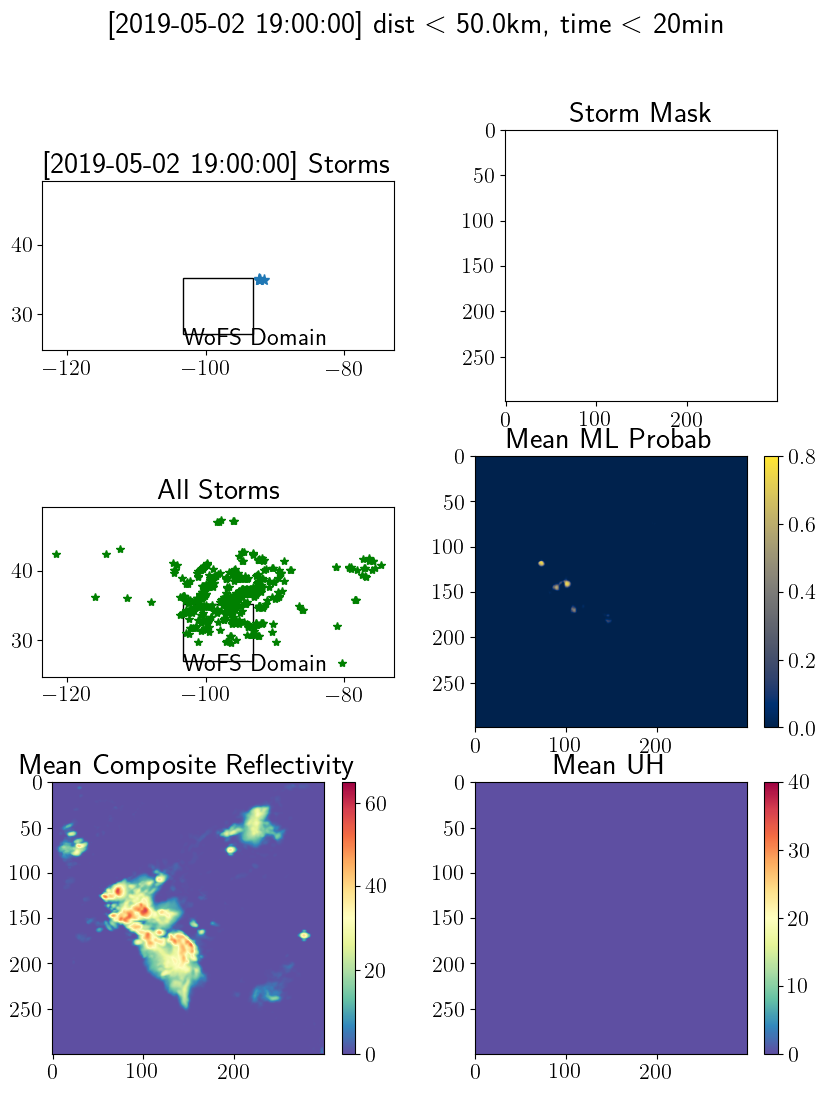

In [91]:
def generate_storm_gif(df_files, df_storm_reports, frames=None, stat='mean', 
                       storm_mask_args={'gridsize': 3, 'thres_dist': 50, 'thres_time': 20},
                       fig_ax=None, figsize=(10, 12), invert_yaxis=False, interval=250):
    '''
    df_files: pd.DataFrame with the wofs prediction files
    df_storm_reports: pd.DataFrame with the storm reports 
    frames: int or list of ints with the frame indicies 
    stat: str. statistic to compute mean or median 
    storm_mask_args: arguments for create_storm_mask()

    '''
    p0 = 0
    if frames is None:
        frames = df_files.shape[0]   
    elif isinstance(frames, (list, tuple, np.ndarray)): 
        p0 = frames[0]
        print("# Frames", len(frames))
    print(f"nframe = {frames}")

    # Storm Reports
    lats_storm = df_storm_reports['Lat'].values 
    lons_storm = df_storm_reports['Lon'].values
    times_storms = np.array([d.to_pydatetime() for d in pd.to_datetime(df_storm_reports['DateTime'].values)])

    #itime = '1900'

    fig = None
    axs = None
    if fig_ax:
        fig, axs = fig_ax
    else:
        fig, axs = plt.subplots(3, 2, figsize=figsize)
        axs = axs.ravel()
        
    figax = (fig, axs[:2])

    # Dict to help with plotting
    cvars = {'prob': {'ax': axs[3], 'vmin': 0, 'vmax': .8, 'cmap': 'cividis', #viridis
                        'title': 'Mean ML Probab'},
                'cZH': {'ax': axs[4], 'vmin': 0, 'vmax': 65, 'cmap': 'Spectral_r',
                        'title': 'Mean Composite Reflectivity'},
                'uh': {'ax': axs[5], 'vmin': 0, 'vmax': 40,  'cmap': 'Spectral_r',
                        'title': 'Mean UH'}}

    def draw_storm_frame(pi):
        '''
        Draw a frame
        @param pi: index (aka frame index)
        '''
        axs[0].clear()

        itime = df_files['init_time'].values[pi]
        ftime = df_files['forecast_time'].values[pi]
        print(f"[{itime}] Forecast Time {ftime} ({pi})")
        _wofs_stat = compute_ensemble_stat(stat, df_files, #df_all_rundate_files
                                           itime, ftime=ftime, 
                                           concat_dim='ENS')

        # Mean ML prob, UH, cZH
        for key, val in cvars.items():
            _ax = val['ax']
            vmin = val['vmin']
            vmax = val['vmax']
            im = _ax.imshow(_wofs_stat[key], vmin=vmin, vmax=vmax, 
                            cmap=val['cmap'])
            _ax.set_title(val['title'])
            #plt.colorbar(im, ax=_ax)
        
        xlats = _wofs_stat['xlat']
        xlons = _wofs_stat['xlon']
        dtime = _wofs_stat['datetime']

        # Storm reports
        mask, sel_storms, tree = wpe.create_storm_mask(xlats, xlons, dtime, lats_storm, 
                                                    lons_storm, times_storms, 
                                                    **storm_mask_args, kdworkers=-1)
        # WoFS Domain box
        xlat_range = np.quantile(xlats, [0, 1])
        xlon_range = np.quantile(xlons, [0, 1])
        width = np.diff(xlon_range)[0]
        height = np.diff(xlat_range)[0]

        all_lats = np.append(xlats.ravel(), df_storm_reports['Lat'].ravel()) #lats_storm
        all_lons = np.append(xlons.ravel(), df_storm_reports['Lon'].ravel()) #lons_storm
        ylims = np.quantile(all_lats, [0, 1]) + [-2, 2]
        xlims = np.quantile(all_lons, [0, 1]) + [-2, 2]

        rect = Rectangle((xlon_range[0], xlat_range[0]), width, height, 
                        facecolor='none', edgecolor='k')
        axs[0].add_patch(rect)
        axs[0].text(xlon_range[0], xlat_range[0]-1.5, 'WoFS Domain')
        axs[0].set(xlim=xlims, ylim=ylims, title=f'[{dtime}] Storms')
        axs[0].set_aspect("equal")

        # Storm reports
        wpe.plot_storms(mask, lons_storm[sel_storms], lats_storm[sel_storms], 
                        figax=figax, figsize=figsize, xlims=xlims, ylims=ylims, 
                        invert_yaxis=invert_yaxis, 
                        bcmap=mpl.colors.ListedColormap(['w', 'blue']))

        figax[0].suptitle(rf'[{dtime}] dist $<$ {thres_dist}km, time $<$ {thres_time}min')


    # All storms
    itime = df_files['init_time'][p0]
    ftime = df_files['forecast_time'][p0]
    _wofs_stat = compute_ensemble_stat(stat, df_files,
                                        itime, ftime=ftime, 
                                        concat_dim='ENS')
    axs[2].plot(df_storm_reports['Lon'], df_storm_reports['Lat'], 'g*')
    xlat_range = np.quantile(_wofs_stat['xlat'], [0, 1])
    xlon_range = np.quantile(_wofs_stat['xlon'], [0, 1])
    width = np.diff(xlon_range)[0]
    height = np.diff(xlat_range)[0]
    rect = Rectangle((xlon_range[0], xlat_range[0]), width, height, 
                    facecolor='none', edgecolor='k')
    axs[2].add_patch(rect)
    axs[2].text(xlon_range[0], xlat_range[0]-1.5, 'WoFS Domain')
    axs[2].set_title('All Storms')
    axs[2].set_aspect("equal")
    if invert_yaxis: axs[2].invert_yaxis()
    # All storms on day
    '''
    print(df_storm_report_20190502)
    axs[2].plot(df_storm_report_20190502['Lon'], df_storm_report_20190502['Lat'],
                'g*')
    xlat_range = np.quantile(wofs_mean_20190502['xlat'], [0, 1])
    xlon_range = np.quantile(wofs_mean_20190502['xlon'], [0, 1])
    width = np.diff(xlon_range)[0]
    height = np.diff(xlat_range)[0]
    rect = Rectangle((xlon_range[0], xlat_range[0]), width, height, 
                    facecolor='none', edgecolor='k')
    axs[2].add_patch(rect)
    axs[2].text(xlon_range[0], xlat_range[0]-1.5, 'WoFS Domain')
    axs[2].set_title('[2019-05-02] All Storms')
    axs[2].set_aspect("equal")
    if invert_yaxis: axs[2].invert_yaxis()
    '''

    all_lats = np.append(xlat_range.ravel(), df_storm_reports['Lat'].ravel()) 
    all_lons = np.append(xlon_range.ravel(), df_storm_reports['Lon'].ravel())
    ylims = np.quantile(all_lats, [0, 1]) + [-2, 2]
    xlims = np.quantile(all_lons, [0, 1]) + [-2, 2]
    axs[2].set(xlim=xlims, ylim=ylims)

    # Mean ML prob, UH, cZH
    for key, val in cvars.items():
        _ax = val['ax']
        vmin = val['vmin']
        vmax = val['vmax']
        im = _ax.imshow(_wofs_stat[key], vmin=vmin, vmax=vmax, 
                        cmap=val['cmap'])
        _ax.set_title(val['title'])
        plt.colorbar(im, ax=_ax)

    animator = FuncAnimation(fig, draw_storm_frame, frames=frames,
                             interval=interval, repeat=True) #, **kwargs)

    animator

    return animator


sel_files, sel_mask = select_files(df_all_rundate_files, itime=None, ftime=None, #df_all_files
                                   emember=None, rdate='20190502', return_mask=True)
frames = np.where(sel_mask)[0][:37] #[:(74*5):74] #np.arange(5, 10)
storm_mask_args = {'gridsize': GRIDSIZE, 'thres_dist': thres_dist, 'thres_time': thres_time}
generate_storm_gif(df_all_rundate_files, df_storm_report, frames=frames, stat='mean', 
                   storm_mask_args=storm_mask_args, fig_ax=None, figsize=(10, 12), 
                   invert_yaxis=False, interval=250)

In [108]:
sel_files, sel_mask = select_files(df_all_rundate_files, itime=None, ftime=None, #df_all_files
                                   emember=None, rdate='20190502', return_mask=True)
sel_files.head(5)

run_date init_time ensemble_member        forecast_time                                      filename_path
50080  20190502      0000       ENS_MEM_1  2019-05-03_00:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
50081  20190502      0000       ENS_MEM_1  2019-05-03_00:10:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
50082  20190502      0000       ENS_MEM_1  2019-05-03_00:15:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
50083  20190502      0000       ENS_MEM_1  2019-05-03_00:20:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
50084  20190502      0000       ENS_MEM_1  2019-05-03_00:25:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...

## April 30 2019

In [ ]:
num2date(wofs_test.Time, 'seconds since 2001-01-01')

array([cftime.DatetimeGregorian(2019, 4, 30, 19, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2019, 4, 30, 19, 5, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2019, 4, 30, 19, 10, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2019, 4, 30, 19, 15, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2019, 4, 30, 19, 20, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2019, 4, 30, 19, 25, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2019, 4, 30, 19, 30, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2019, 4, 30, 19, 35, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2019, 4, 30, 19, 40, 0, 0, has_year_zero=False)],
      dtype=object)

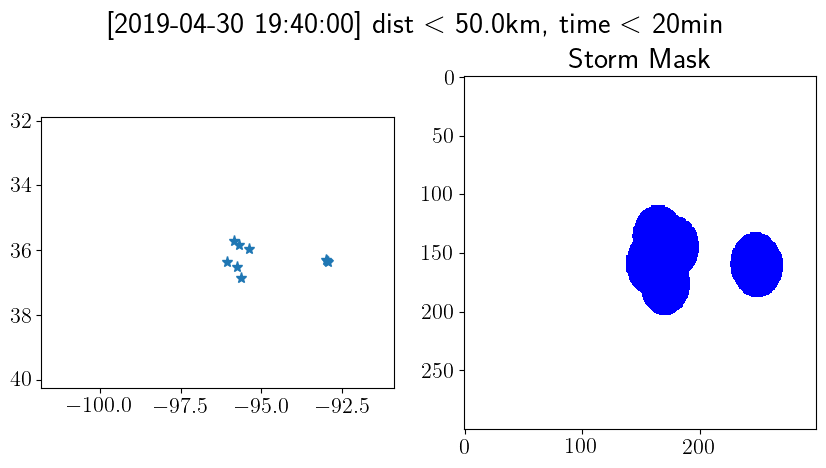

In [ ]:
# April 30 2019
# WoFS Space
ti = 8
xlats = wofs_test['XLAT'].values[ti]
xlons = wofs_test['XLONG'].values[ti]
dt_objs = num2date(wofs_test.Time, 'seconds since 2001-01-01')
dtime = dt_objs[ti]

# Storm Reports
lats_storm = df_storm_report['Lat'].values 
lons_storm = df_storm_report['Lon'].values
times_storms = np.array([d.to_pydatetime() for d in pd.to_datetime(df_storm_report['DateTime'].values)])
#pd.to_datetime(df_storm_report['DateTime'])[0].to_pydatetime()

mask, sel_storms, tree = wpe.create_storm_mask(xlats, xlons, dtime, lats_storm, 
                                               lons_storm, times_storms, GRIDSIZE, 
                                               thres_dist=thres_dist, 
                                               thres_time=thres_time, kdworkers=-1)

ylims = np.quantile(wofs_test['XLAT'].values, [0, 1])
xlims = np.quantile(wofs_test['XLONG'].values, [0, 1])

figax_storms = wpe.plot_storms(mask, lons_storm[sel_storms], lats_storm[sel_storms], 
                               figax=None, figsize=(10, 5), xlims=xlims, ylims=ylims, 
                               invert_yaxis=True, 
                               bcmap=mpl.colors.ListedColormap(['w', 'blue']))
figax_storms[0].suptitle(rf'[{dtime}] dist $<$ {thres_dist}km, time $<$ {thres_time}min');

In [ ]:
# April 30 2019
_df_files_20190430 = wpe.generate_ensemble_files_list_all(_dir, date='20190430', 
                                                     itime=init_time, ens_names=[], 
                                                     save_path=None, 
                                                     df_index=False, **extr_args)
_list = _df_files_20190430['filename_path'].values
_list

array(['/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jtti/wofs_preds/2019/20190430/1900/ENS_MEM_1/wrfout_d01_2019-04-30_19:00:00_predictions.nc',
       '/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jtti/wofs_preds/2019/20190430/1900/ENS_MEM_1/wrfwof_d01_2019-04-30_19:00:00_predictions.nc',
       '/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jtti/wofs_preds/2019/20190430/1900/ENS_MEM_1/wrfwof_d01_2019-04-30_19:05:00_predictions.nc',
       ...,
       '/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jtti/wofs_preds/2019/20190430/1900/ENS_MEM_9/wrfwof_d01_2019-05-01_00:55:00_predictions.nc',
       '/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jtti/wofs_preds/2019/20190430/1900/ENS_MEM_9/wrfout_d01_2019-05-01_01:00:00_predictions.nc',
       '/ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jtti/wofs_preds/2019/20190430/1900/ENS_MEM_9/wrfwof_d01_2019-05-01_01:00:00_predictions.nc'],
      dtype=object)

In [ ]:
_df = select_files(_df_files_20190430, '1900', '2019-05-01_01:00:00', emember=None)
_df.shape

(36, 5)

In [ ]:
_df

run_date init_time ensemble_member        forecast_time                                      filename_path
73    20190430      1900       ENS_MEM_1  2019-05-01_01:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
74    20190430      1900       ENS_MEM_1  2019-05-01_01:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
148   20190430      1900      ENS_MEM_10  2019-05-01_01:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
149   20190430      1900      ENS_MEM_10  2019-05-01_01:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
223   20190430      1900      ENS_MEM_11  2019-05-01_01:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
224   20190430      1900      ENS_MEM_11  2019-05-01_01:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
298   20190430      1900      ENS_MEM_12  2019-05-01_01:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
299   20190430      1900      ENS_MEM_12  2019-05-01_01:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
373   20190430      1900      ENS_MEM_13  2019-05-01_01:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
374   20190430      1900      ENS_MEM_13  2019-05-01_01:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
448   20190430      1900      ENS_MEM_14  2019-05-01_01:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
449   20190430      1900      ENS_MEM_14  2019-05-01_01:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
523   20190430      1900      ENS_MEM_15  2019-05-01_01:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
524   20190430      1900      ENS_MEM_15  2019-05-01_01:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
598   20190430      1900      ENS_MEM_16  2019-05-01_01:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
599   20190430      1900      ENS_MEM_16  2019-05-01_01:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
673   20190430      1900      ENS_MEM_17  2019-05-01_01:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
674   20190430      1900      ENS_MEM_17  2019-05-01_01:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
748   20190430      1900      ENS_MEM_18  2019-05-01_01:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
749   20190430      1900      ENS_MEM_18  2019-05-01_01:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
823   20190430      1900       ENS_MEM_2  2019-05-01_01:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
824   20190430      1900       ENS_MEM_2  2019-05-01_01:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
898   20190430      1900       ENS_MEM_3  2019-05-01_01:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
899   20190430      1900       ENS_MEM_3  2019-05-01_01:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
973   20190430      1900       ENS_MEM_4  2019-05-01_01:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
974   20190430      1900       ENS_MEM_4  2019-05-01_01:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
1048  20190430      1900       ENS_MEM_5  2019-05-01_01:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
1049  20190430      1900       ENS_MEM_5  2019-05-01_01:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
1123  20190430      1900       ENS_MEM_6  2019-05-01_01:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
1124  20190430      1900       ENS_MEM_6  2019-05-01_01:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
1198  20190430      1900       ENS_MEM_7  2019-05-01_01:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
1199  20190430      1900       ENS_MEM_7  2019-05-01_01:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
1273  20190430      1900       ENS_MEM_8  2019-05-01_01:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
1274  20190430      1900       ENS_MEM_8  2019-05-01_01:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
1348  20190430      1900       ENS_MEM_9  2019-05-0

(36, 5)
wofs_preds['Time']=<xarray.DataArray 'Time' (Time: 1)>
array([578343600])
Coordinates:
  * Time     (Time) int64 578343600
    XTIME    (Time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
DateTime 2019-04-30 19:00:00
- - - - - - - - -
 n fig axes 9
(36, 5)
wofs_preds['Time']=<xarray.DataArray 'Time' (Time: 1)>
array([578343600])
Coordinates:
  * Time     (Time) int64 578343600
    XTIME    (Time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
DateTime 2019-04-30 19:00:00
- - - - - - - - -
(36, 5)
wofs_preds['Time']=<xarray.DataArray 'Time' (Time: 1)>
array([578343600])
Coordinates:
  * Time     (Time) int64 578343600
    XTIME    (Time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
DateTime 2019-04-30 19:00:00
- - - - - - - - -


(36, 5)
wofs_preds['Time']=<xarray.DataArray 'Time' (Time: 1)>
array([578343600])
Coordinates:
  * Time     (Time) int64 578343600
    XTIME    (Time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
DateTime 2019-04-30 19:00:00
- - - - - - - - -


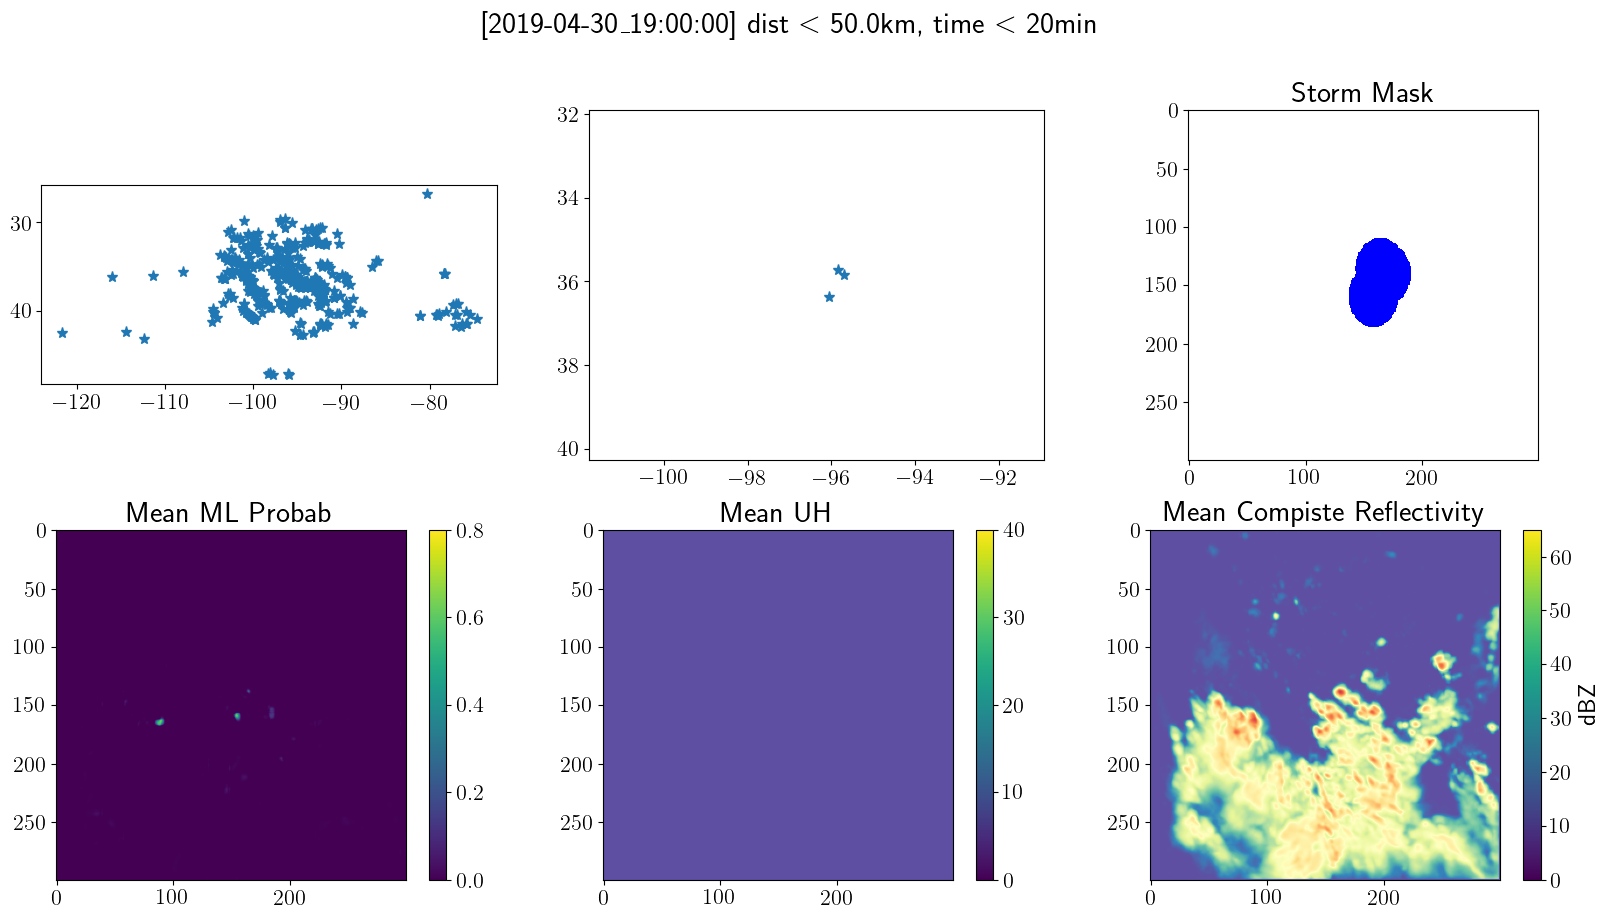

In [ ]:
ftimes = np.unique(df_all_files['forecast_time'].values)
n_ftimes = 10 #np.unique(ftimes).size

all_ftimes = _df_files_20190430['forecast_time'].values #df_all_files
ftimes = np.unique(all_ftimes)
n_all_ftimes = all_ftimes.size

def create_storms_gif(df_all_files,
    lats_storm, lons_storm, times_storms, gridsize, 
    thres_dist=thres_dist, 
    thres_time=thres_time, invert_yaxis=False, figsize=(20, 10), 
    nframes=None, interval=50, **kwargs):

    '''
    Create a .gif or movie file of the storm data
    matplotlib documentation 
    https://www.c-sharpcorner.com/article/create-animated-gif-using-python-matplotlib/

    '''
    fig = None
    axs = None
    fig, axs = plt.subplots(2, 3, figsize=figsize)
    axs = axs.ravel()

    # Plot all storm reports
    axs[0].plot(lons_storm, lats_storm, '*', ms=8)
    axs[0].set_aspect('equal')
    if invert_yaxis:
        axs[0].invert_yaxis()


    def draw_storm_frame(pi):
        '''
        Draw a patch as a single frame
        @param pi: patch index (aka draw frame index)
        '''
        if isinstance(axs, list) or isinstance(axs, np.ndarray):
            for a in axs[1:]: a.clear()
        else: axs.clear()

        # Load all ensembles for the forecast time
        wofs_mean_20190430 = compute_ensemble_stat('mean', _df_files_20190430, #df_all_files
                                                   init_time, ftime=ftimes[pi], #TODO: args.init_time,
                                                   concat_dim='ENS')
        
        dtime = wofs_mean_20190430['datetime']
        xlats = wofs_mean_20190430['xlat']
        xlons = wofs_mean_20190430['xlon']

        # Mean ML prob
        im = axs[3].imshow(wofs_mean_20190430['prob'], vmin=0, vmax=.8)
        axs[3].set_title('Mean ML Probab')

        # Mean UH
        im = axs[4].imshow(wofs_mean_20190430['uh'], vmin=0, vmax=40, cmap='Spectral_r')
        axs[4].set_title('Mean UH')

        # Mean Composite Refelctivity
        im = axs[5].imshow(wofs_mean_20190430['cZH'], vmin=0, vmax=65, cmap='Spectral_r')
        axs[5].set_title('Mean Compiste Reflectivity')

        ylims = np.quantile(xlats, [0, 1])
        xlims = np.quantile(xlons, [0, 1])

        mask, sel_storms, _ = wpe.create_storm_mask(xlats, xlons, dtime, #ftimes[pi], 
                                                    lats_storm, lons_storm, 
                                                    times_storms, gridsize, 
                                                    thres_dist=thres_dist,
                                                    thres_time=thres_time, 
                                                    kdworkers=-1)

        _ = wpe.plot_storms(mask, lons_storm[sel_storms], lats_storm[sel_storms], 
                                    figax=(fig, axs[1:3]), figsize=figsize, 
                                    xlims=xlims, ylims=ylims, 
                                    invert_yaxis=invert_yaxis, 
                                    bcmap=mpl.colors.ListedColormap(['w', 'blue']))
        fig.suptitle(rf'[{ftimes[pi]}] dist $<$ {thres_dist}km, time $<$ {thres_time}min')

        fig.canvas.draw() # draw the canvas, cache renderer
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        WIDTH, HEIGHT = fig.canvas.get_width_height()
        image = image.reshape(HEIGHT, WIDTH, 3) # 3 for RGB
        return image


    # Plot first frame to get colorbar to render properly
    wofs_mean_20190430 = compute_ensemble_stat('mean', _df_files_20190430, 
                                                   init_time, ftime=ftimes[0],
                                                   concat_dim='ENS')
    im = axs[3].imshow(wofs_mean_20190430['prob'], vmin=0, vmax=.8)
    plt.colorbar(im, ax=axs[3])
    im = axs[4].imshow(wofs_mean_20190430['uh'], vmin=0, vmax=40)
    plt.colorbar(im, ax=axs[4])
    im = axs[5].imshow(wofs_mean_20190430['cZH'], vmin=0, vmax=65)
    plt.colorbar(im, ax=axs[5], label='dBZ')

    #fname = os.path.basename(wofs.filenamepath) + f'__{suffix}.gif'
    animator = FuncAnimation(fig, draw_storm_frame, frames=nframes, 
                             interval=interval, **kwargs)
    print(" n fig axes", len(fig.axes)) #fig.delaxes(fig.axes[-1])

    return fig, animator

#plt.rcParams["animation.html"] = "jshtml"

fig, ani = create_storms_gif(df_all_files, lats_storm, 
    lons_storm, times_storms, GRIDSIZE, 
    thres_dist=thres_dist, thres_time=thres_time, 
    invert_yaxis=True, figsize=(20, 10), 
    nframes=n_ftimes, interval=800) #, **kwargs) #interval delay in milliseconds

#ani.save('_storm_reports.gif', dpi=200) #, writer=writer)
ani

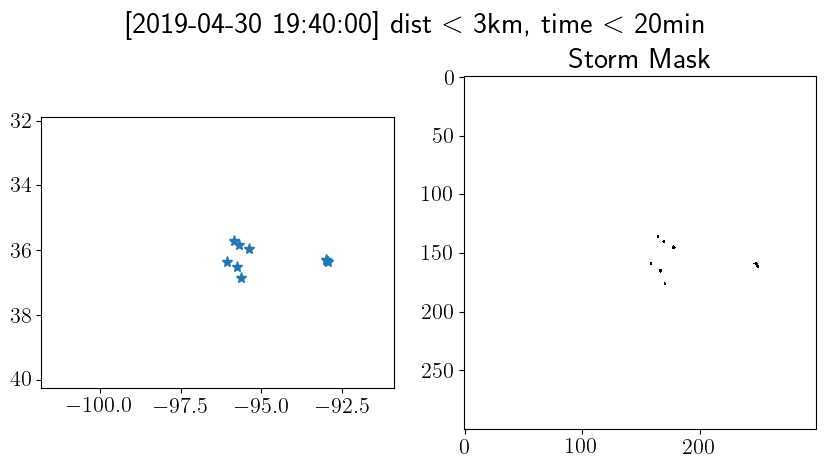

In [ ]:
mask_, sel_, tree_ = wpe.create_storm_mask(xlats, xlons, dtime, lats_storm, 
                                           lons_storm, times_storms, 
                                           GRIDSIZE, thres_dist=3, 
                                           thres_time=thres_time, kdworkers=-1)

ylims = np.quantile(wofs_test['XLAT'].values, [0, 1])
xlims = np.quantile(wofs_test['XLONG'].values, [0, 1])

figax_storms = wpe.plot_storms(mask_, lons_storm[sel_], lats_storm[sel_], 
                               figax=None, figsize=(10, 5), xlims=xlims, 
                               ylims=ylims, invert_yaxis=True, 
                               bcmap=mpl.colors.ListedColormap(['w', 'k']))
figax_storms[0].suptitle(rf'[{dtime}] dist $<$ 3km, time $<$ {thres_time}min');

Text(0.5, 0.98, '[2019-04-30 19:40:00] dist $<$ 10km, time $<$ 20min')

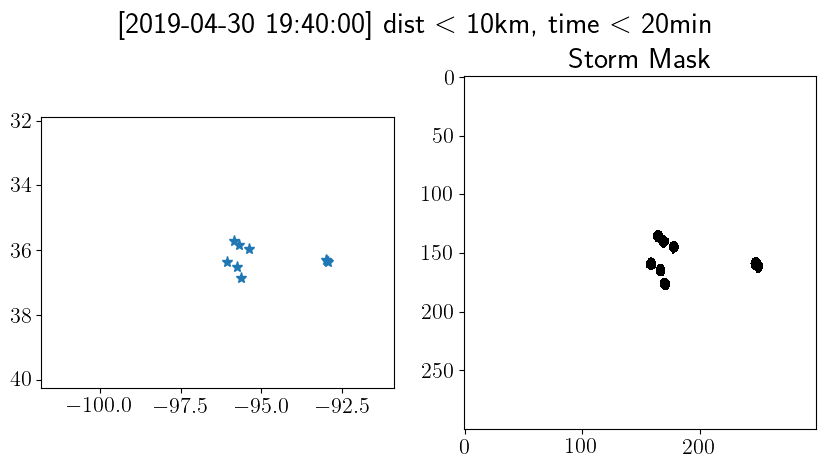

In [ ]:
mask_, sel_, tree_ = wpe.create_storm_mask(xlats, xlons, dtime, lats_storm, lons_storm, 
                                    times_storms, GRIDSIZE, thres_dist=10, 
                                    thres_time=thres_time, kdworkers=-1)

figax_storms = wpe.plot_storms(mask_, lons_storm[sel_], lats_storm[sel_], 
                               figax=None, figsize=(10, 5), xlims=xlims, 
                               ylims=ylims, invert_yaxis=True, 
                               bcmap=mpl.colors.ListedColormap(['w', 'k']))
figax_storms[0].suptitle(rf'[{dtime}] dist $<$ 10km, time $<$ {thres_time}min')

# GENERATE UH MASKS

In [ ]:
def create_uh_mask(uh, thres_uh=50, quantile=False):
    """ 
    Create masks from UH
    Parameters
    ----------
    uh:
    thres_uh: greater than 
    quantile: bool. whether thres_uh is a quantile between 0 and 1
    """
    if quantile:
        thres_uh = np.quantile(uh, thres_uh)

    mask = uh > thres_uh
    return mask, thres_uh

thres_uh_Q = .98
QUANTILE = True

print(ti)
print(wofs_test['UP_HELI_MAX'].shape)
uh = wofs_test['UP_HELI_MAX'].values[ti]

mask_uh, uh_thres = create_uh_mask(uh, thres_uh=thres_uh_Q, quantile=QUANTILE)

8
(9, 300, 300)


In [ ]:
uh.shape

(300, 300)

In [ ]:
np.nanquantile(wofs_test['UP_HELI_MAX'], [0, thres_uh_Q, 1])

array([  0.        ,   0.5842334 , 113.18749237])

In [ ]:
np.nanquantile(wofs_test['UP_HELI_MAX'][ti], [0, thres_uh_Q, 1])

array([  0.        ,   0.81646478, 113.18749237])

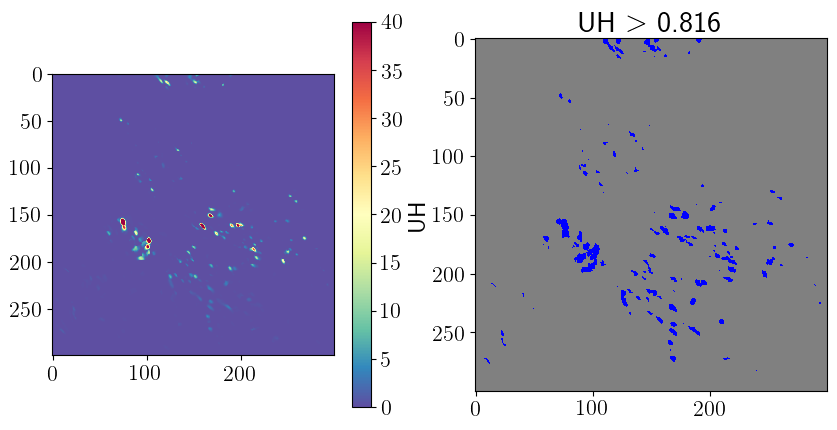

In [ ]:
figax_uh = wpe.plot_uh(uh, mask_uh, uh_thres, figax=None, figsize=(10, 5), 
                       vrange=[0, 40], bcmap=mpl.colors.ListedColormap(['gray', 'blue']))

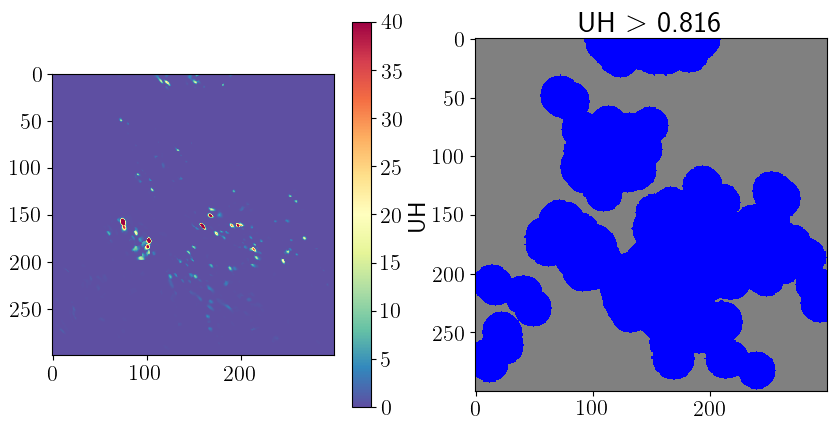

In [ ]:
Y, X = np.ogrid[:ksize, :ksize]
dist_from_center = np.sqrt((X - ksize/2+1)**2 + (Y - ksize/2+1)**2)
footprint = dist_from_center <= ksize/2

fp = wpe._create_round_kernel(ksize)
mask_uh_dilated = grey_dilation(mask_uh, footprint=fp) #, size=(ksize, ksize)

figax_uh = wpe.plot_uh(uh, mask_uh_dilated, uh_thres, figax=None, figsize=(10, 5), 
                       vrange=[0, 40], bcmap=mpl.colors.ListedColormap(['gray', 'blue']))

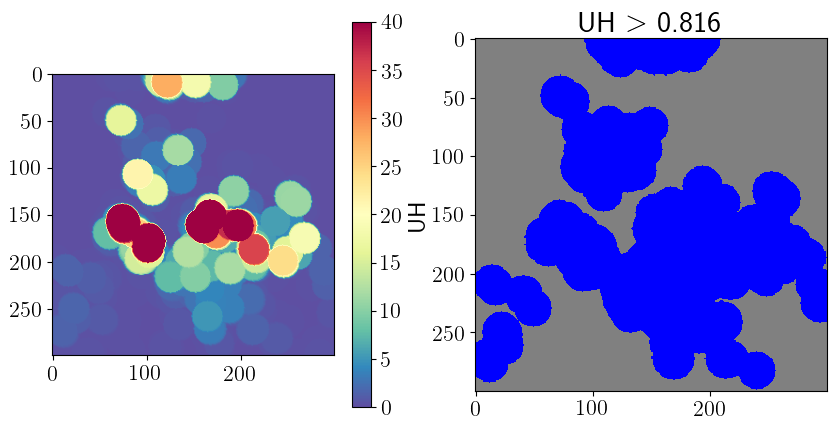

In [ ]:
uh_dilated = grey_dilation(uh, footprint=fp) #, size=(ksize, ksize)

figax_uh = wpe.plot_uh(uh_dilated, mask_uh_dilated, uh_thres, figax=None, figsize=(10, 5), 
                       vrange=[0, 40], bcmap=mpl.colors.ListedColormap(['gray', 'blue']))

(1, 17) (17, 1) (17, 17)


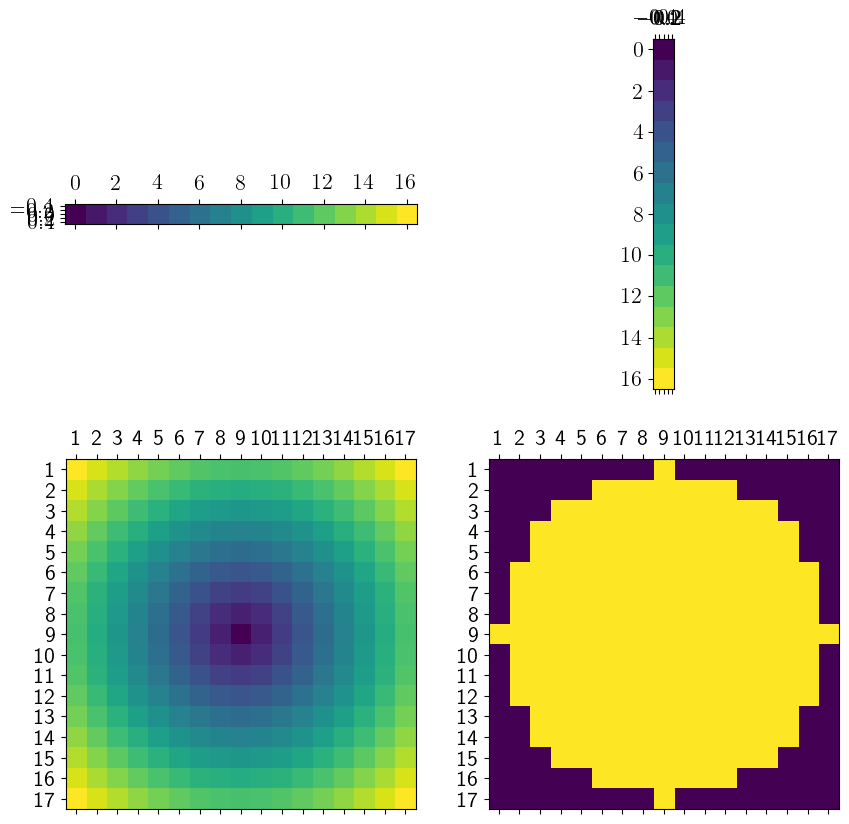

In [ ]:
ks = 17
_Y, _X = np.ogrid[:ks, :ks]
isodd = ks % 2
dist_from_center = np.sqrt((_X - (ks-1) / 2 )**2 + (_Y - (ks-1) / 2 )**2)
testprint = dist_from_center <= (ks - isodd) / 2 #+ isodd

print(_X.shape, _Y.shape, testprint.shape)

_f, _a = plt.subplots(2, 2, figsize=(10, 10))

_a[0,0].matshow(_X)
_a[0,1].matshow(_Y)

_a[1,0].matshow(dist_from_center)
_a[1,1].matshow(testprint)

_xt = np.linspace(0, ks-1, ks, dtype=int)
for a in _a[1]:
    a.set_xticks(_xt, _xt+1)
    a.set_yticks(_xt, _xt+1)

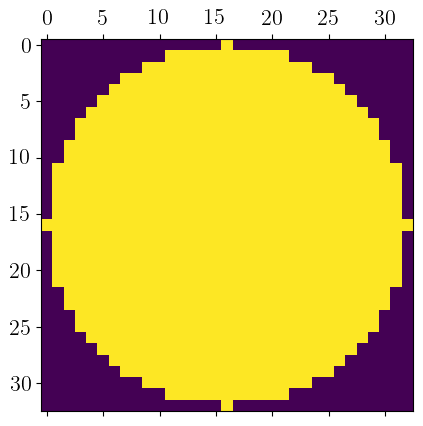

In [ ]:
fp = wpe._create_round_kernel(ksize)
plt.matshow(fp)

# ALL VIZ

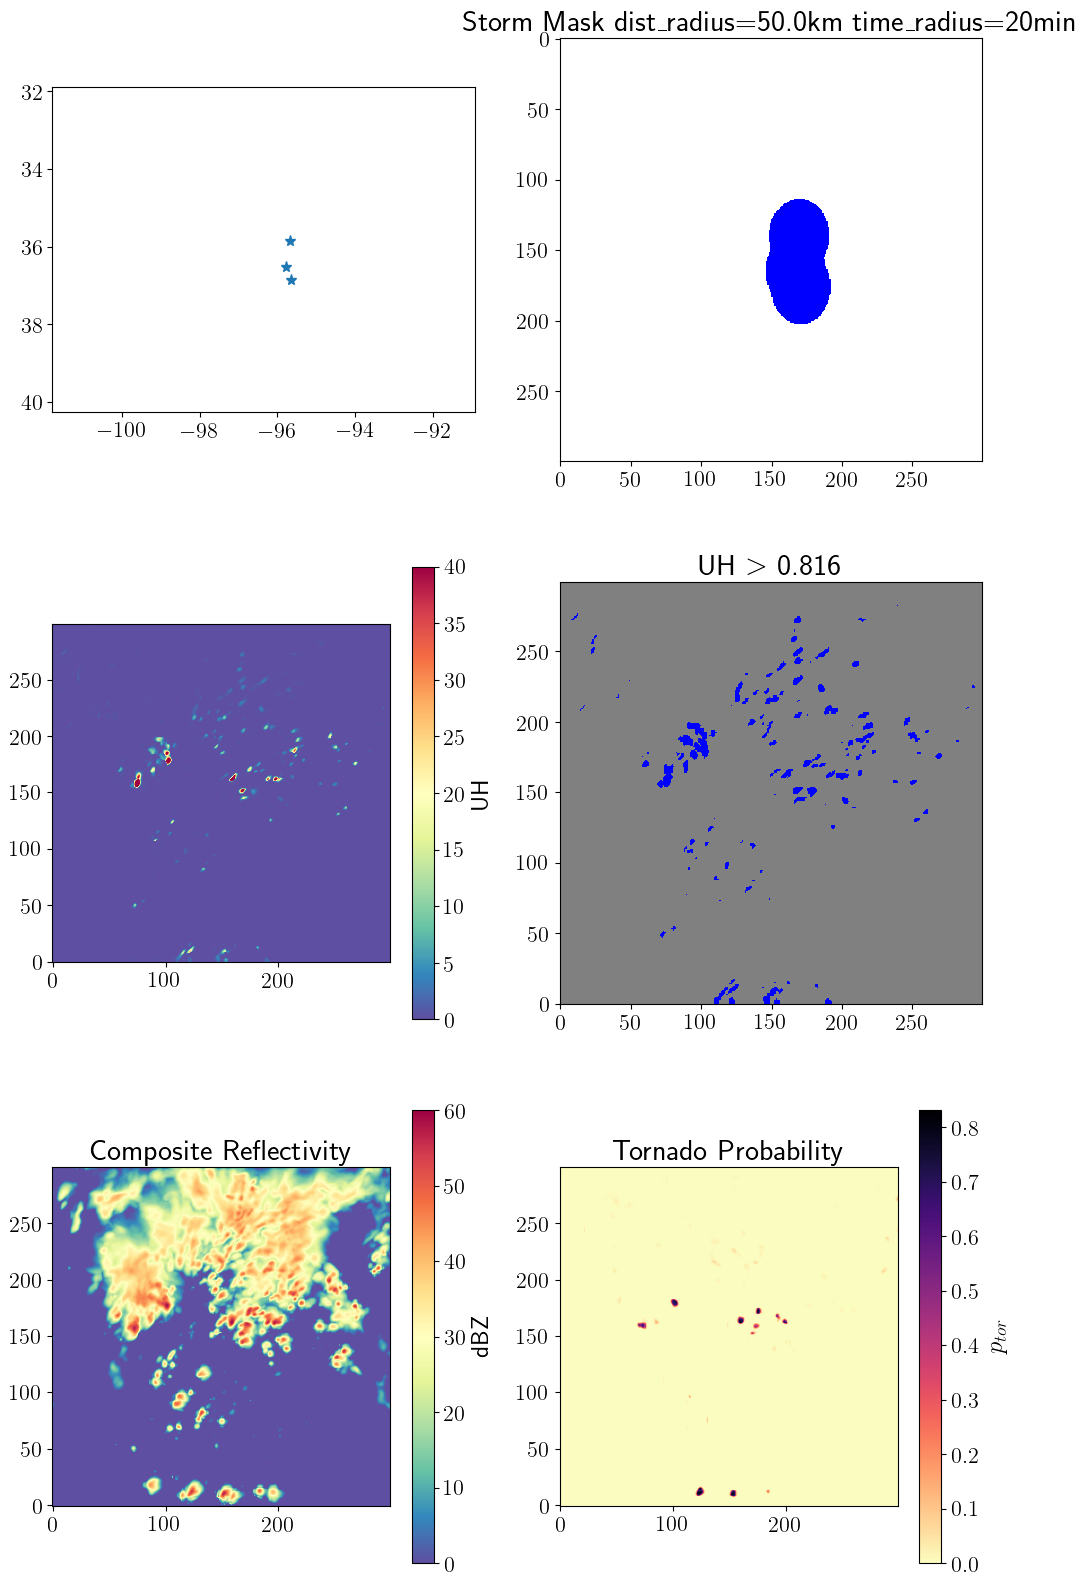

In [ ]:
f_, a_ = plt.subplots(3, 2, figsize=(12,20))
a_ = a_.ravel()

invert_y = True

_, _ax_storm = wpe.plot_storms(mask, lons_storm[sel_storms], lats_storm[sel_storms], 
                               thres_dist=thres_dist, thres_time=thres_time, 
                               figax=(f_, a_[:2]), xlims=xlims, ylims=ylims, 
                               invert_yaxis=invert_y, 
                               bcmap=mpl.colors.ListedColormap(['w', 'b']))

_, _ax_uh = wpe.plot_uh(uh, mask_uh, uh_thres=uh_thres, figax=(f_, a_[2:4]), 
                        invert_yaxis=invert_y, vrange=[0, 40], 
                        bcmap=mpl.colors.ListedColormap(['gray', 'blue']))

ZH = wofs_test['COMPOSITE_REFL_10CM'].values[ti]
ml_preds = wofs_test['ML_PREDICTED_TOR'].values[ti]
_, ax_zh_p = wpe.plot_zh_n_probs(ZH, ml_preds, thres_prob=None, figax=(f_, a_[4:]), 
                                 invert_yaxis=invert_y, zrange=[0, 60], #prange=[0,1],
                                 zhcmap='Spectral_r', pcmap='magma_r')

# GENERATE CONFUSION MATRIX

In [ ]:
#ML_PREDICTED_TOR     (Time, south_north, west_east) float64 dask.array<chunksize=(10, 300, 300), meta=np.ndarray>
#REFL_10CM            (Time, bottom_top, south_north, west_east) float32 dask.array<chunksize=(10, 50, 300, 300), meta=np.ndarray>
#COMPOSITE_REFL_10CM
ml_preds = wofs_test['ML_PREDICTED_TOR'].values[ti] > .1
cmtx_uh = confusion_matrix(mask_uh.ravel(), ml_preds.ravel()) #tn, fp, fn, tp
#TN: c00, FN c10, TP c11, FP c01 
cmtx_uh

array([[88064,   136],
       [ 1667,   133]])

In [ ]:
ml_preds = wofs_test['ML_PREDICTED_TOR'].values[ti] > .5
cmtx_uh = confusion_matrix(mask_uh.ravel(), ml_preds.ravel())
#TN: c00, FN c10, TP c11, FP c01 
cmtx_uh

array([[88160,    40],
       [ 1729,    71]])

In [ ]:
tps = cmtx_uh[1, 1]
fns = cmtx_uh[1, 0]
fps = cmtx_uh[0, 1]
compute_csi(tps, fns, fps)

0.03858695652173913

Max CSI: 0.07. SR=0.426. POD=0.083


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


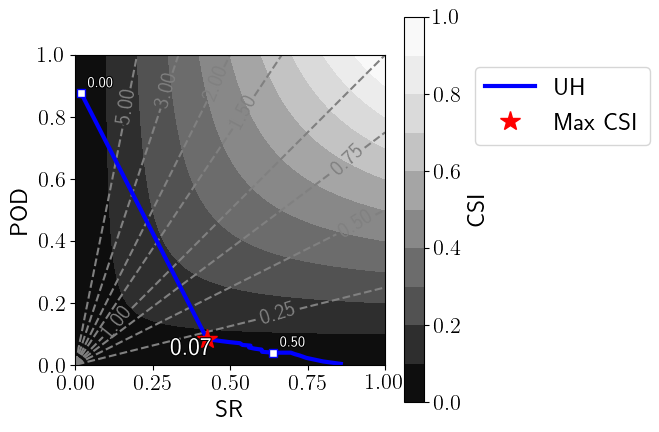

In [ ]:
# compute CSI
csithreshs = np.linspace(0, 1, 21)
fname = "" #os.path.join(dirpath, f"{FN_PREFIX}_csi_train_val.png")
fig, ax, scores = plot_csi(mask_uh.ravel(), wofs_test['ML_PREDICTED_TOR'].values[ti].ravel(), 
                 fname, threshs=csithreshs, label='UH', color='blue', save=False, 
                 return_scores=True, fig_ax=None, figsize=(5, 5))

posx and posy should be finite values


2019-04-30_19:05:00 median
Max CSI: 0.02. SR=0.020. POD=0.891


posx and posy should be finite values
posx and posy should be finite values


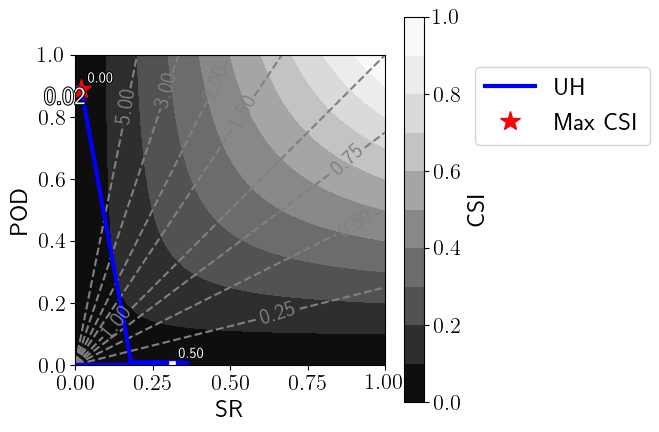

In [ ]:
#wofs_prob[stat][0] ftime = '2019-04-30_19:05:00'
print(ftime, stat)
fname = "" #os.path.join(dirpath, f"{FN_PREFIX}_csi_train_val.png")
fig, ax, scores = plot_csi(mask_uh.ravel(), wofs_prob[stat].ravel(), 
                 fname, threshs=csithreshs, label='UH', color='blue', save=False, 
                 return_scores=True, fig_ax=None, figsize=(5, 5))

posx and posy should be finite values


Max CSI: 0.04. SR=0.036. POD=0.875


posx and posy should be finite values
posx and posy should be finite values


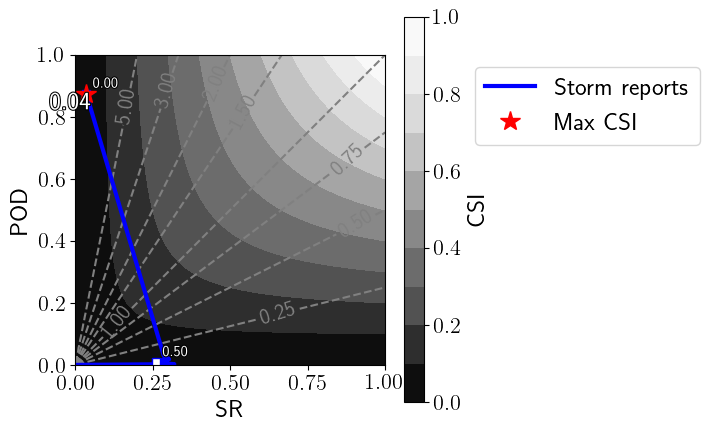

In [ ]:
fname = "" #os.path.join(dirpath, f"{FN_PREFIX}_csi_train_val.png")
figax = plot_csi(mask.ravel(), wofs_test['ML_PREDICTED_TOR'].values[ti].ravel(), 
                 fname, threshs=csithreshs, label='Storm reports', color='blue', 
                 save=False, fig_ax=None, figsize=(5, 5))

In [ ]:
np.quantile(wofs_prob[stat], [0, .5, .75, .9, .95, 1])

array([0.00000000e+00, 4.77335116e-07, 9.02878401e-06, 5.77881891e-05,
       2.15243258e-04, 6.43495717e-01])

posx and posy should be finite values


2019-04-30_19:05:00 median
Max CSI: 0.04. SR=0.038. POD=0.921


posx and posy should be finite values


posx and posy should be finite values


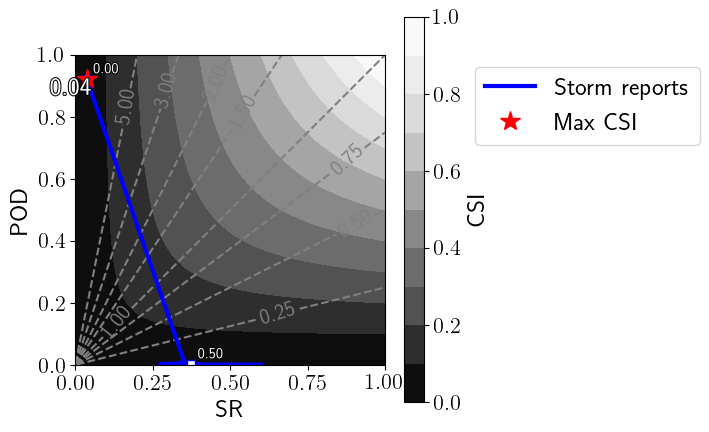

In [ ]:
print(ftime, stat)
fname = "" #os.path.join(dirpath, f"{FN_PREFIX}_csi_train_val.png")
fig, ax, scores = plot_csi(mask.ravel(), wofs_prob[stat].ravel(), 
                 fname, threshs=csithreshs, label='Storm reports', color='blue', 
                 save=False, return_scores=True, fig_ax=None, figsize=(5, 5))

In [ ]:
def min_max_scale(data, min=None, max=None):
    min_val = np.min(data) if min is not None  else 0
    max_val = np.max(data) if max is not None  else 1
    return (data - min_val) / (max_val - min_val)

from sklearn.preprocessing import normalize, Normalizer, MinMaxScaler

In [ ]:
np.quantile(wofs_uh[stat].ravel(), [0, .9, .95, .98, 1])

array([0.00000000e+00, 2.42504101e-02, 1.07881920e-01, 4.56484317e-01,
       2.73242188e+01])

2019-04-30_19:05:00 median
Max CSI: 0.08. SR=0.109. POD=0.197


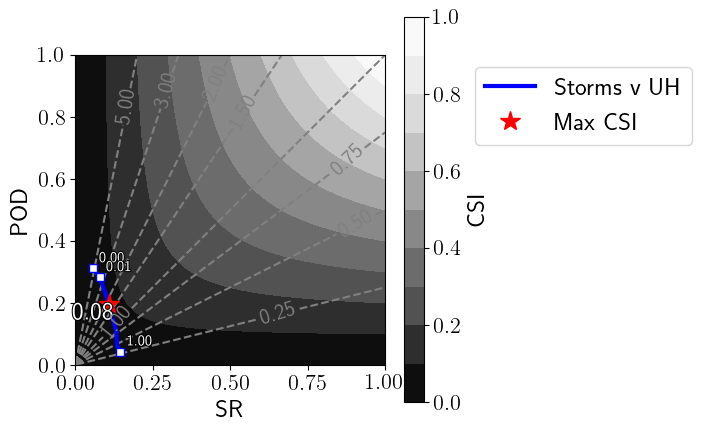

In [ ]:
print(ftime, stat)
fname = "" #os.path.join(dirpath, f"{FN_PREFIX}_csi_train_val.png")

uh_min = wofs_uh[stat].min()
uh_max = wofs_uh[stat].max()
uhthreshs = np.logspace(-4, 0, 21, base=10)
fig, ax, scores = plot_csi(mask.ravel(), wofs_uh[stat].ravel(), #wofs_test['UP_HELI_MAX'][ti].ravel(), 
                           fname, threshs=uhthreshs, label='Storms v UH', #threshs=csithreshs
                           color='blue', save=False, return_scores=True, 
                           fig_ax=None, figsize=(5, 5))

In [ ]:
np.logspace(-3, 0, 21, base=10)

array([0.001     , 0.00141254, 0.00199526, 0.00281838, 0.00398107,
       0.00562341, 0.00794328, 0.01122018, 0.01584893, 0.02238721,
       0.03162278, 0.04466836, 0.06309573, 0.08912509, 0.12589254,
       0.17782794, 0.25118864, 0.35481339, 0.50118723, 0.70794578,
       1.        ])

In [ ]:
np.append(np.array([0]), np.logspace(-4, 0, 20, base=10))

array([0.00000000e+00, 1.00000000e-04, 1.62377674e-04, 2.63665090e-04,
       4.28133240e-04, 6.95192796e-04, 1.12883789e-03, 1.83298071e-03,
       2.97635144e-03, 4.83293024e-03, 7.84759970e-03, 1.27427499e-02,
       2.06913808e-02, 3.35981829e-02, 5.45559478e-02, 8.85866790e-02,
       1.43844989e-01, 2.33572147e-01, 3.79269019e-01, 6.15848211e-01,
       1.00000000e+00])

posx and posy should be finite values


2019-04-30_19:05:00 median
Max CSI: 0.08. SR=0.110. POD=0.191


posx and posy should be finite values
posx and posy should be finite values


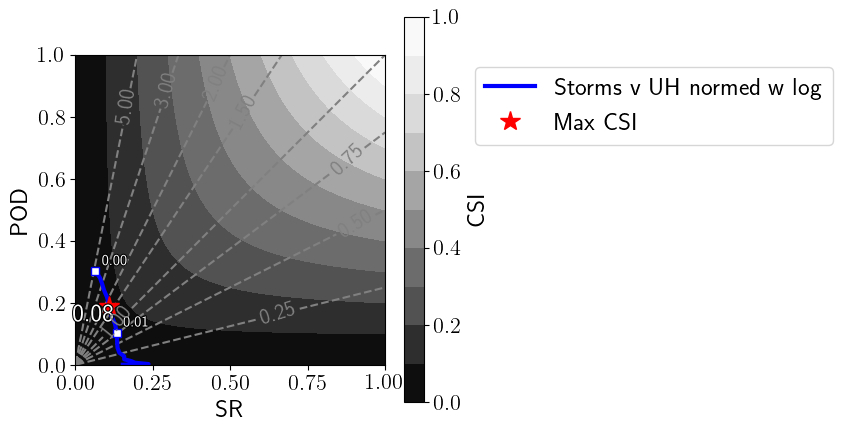

In [ ]:
print(ftime, stat)
fname = "" #os.path.join(dirpath, f"{FN_PREFIX}_csi_train_val.png")
uh_norm = normalize(wofs_uh[stat].reshape(-1, 1), norm='max', axis=0)
uhthreshs = np.logspace(-4, 0, 21, base=10)
fig, ax, scores = plot_csi(mask.ravel(), uh_norm.ravel(), #wofs_uh[stat].ravel() #wofs_test['UP_HELI_MAX'][ti].ravel(), 
                           fname, threshs=uhthreshs, label='Storms v UH normed w log', #threshs=csithreshs
                           color='blue', save=False, return_scores=True, 
                           fig_ax=None, figsize=(5, 5))

posx and posy should be finite values


2019-04-30_19:05:00 median
Max CSI: 0.05. SR=0.056. POD=0.312


posx and posy should be finite values
posx and posy should be finite values


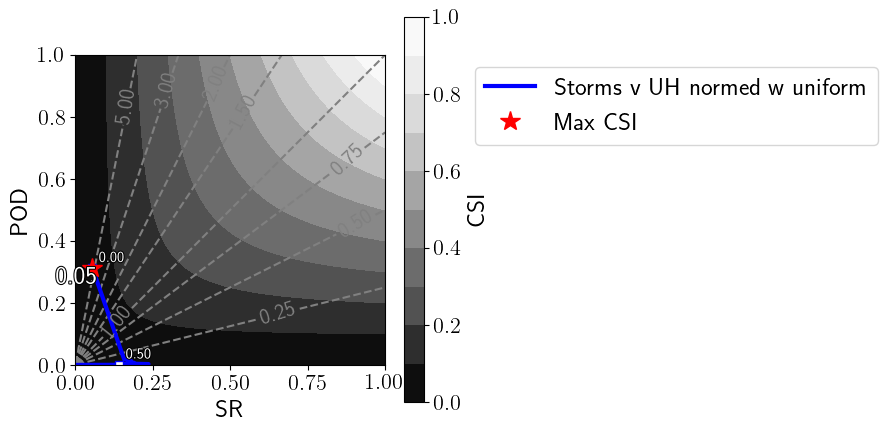

In [ ]:
print(ftime, stat)
fname = "" #os.path.join(dirpath, f"{FN_PREFIX}_csi_train_val.png")
uh_norm = normalize(wofs_uh[stat].reshape(-1, 1), norm='max', axis=0)
fig, ax, scores = plot_csi(mask.ravel(), uh_norm.ravel(), #wofs_uh[stat].ravel() #wofs_test['UP_HELI_MAX'][ti].ravel(), 
                           fname, threshs=csithreshs, label='Storms v UH normed w uniform', #threshs=csithreshs
                           color='blue', save=False, return_scores=True, 
                           fig_ax=None, figsize=(5, 5))

In [ ]:
uh_qs = np.linspace(0, 1, num=41) #, endpoint=True, base=10)
uh_threshs = np.quantile(wofs_uh[stat], uh_qs)

for i, (q, u) in enumerate(zip(uh_qs, uh_threshs)):
    print(f"[{i}] {q:.05f}: \t{u:.06f}")

[0] 0.00000: 	0.000000
[1] 0.02500: 	0.000000
[2] 0.05000: 	0.000000
[3] 0.07500: 	0.000000
[4] 0.10000: 	0.000000
[5] 0.12500: 	0.000000
[6] 0.15000: 	0.000000
[7] 0.17500: 	0.000000
[8] 0.20000: 	0.000000
[9] 0.22500: 	0.000000
[10] 0.25000: 	0.000000
[11] 0.27500: 	0.000000
[12] 0.30000: 	0.000000
[13] 0.32500: 	0.000000
[14] 0.35000: 	0.000000
[15] 0.37500: 	0.000000
[16] 0.40000: 	0.000000
[17] 0.42500: 	0.000000
[18] 0.45000: 	0.000000
[19] 0.47500: 	0.000000
[20] 0.50000: 	0.000000
[21] 0.52500: 	0.000000
[22] 0.55000: 	0.000000
[23] 0.57500: 	0.000000
[24] 0.60000: 	0.000000
[25] 0.62500: 	0.000000
[26] 0.65000: 	0.000000
[27] 0.67500: 	0.000000
[28] 0.70000: 	0.000000
[29] 0.72500: 	0.000000
[30] 0.75000: 	0.000000
[31] 0.77500: 	0.000000
[32] 0.80000: 	0.000247
[33] 0.82500: 	0.002129
[34] 0.85000: 	0.005862
[35] 0.87500: 	0.012262
[36] 0.90000: 	0.024250
[37] 0.92500: 	0.048684
[38] 0.95000: 	0.107882
[39] 0.97500: 	0.331303
[40] 1.00000: 	27.324219


2019-04-30_19:05:00 median
Max CSI: 0.30. SR=0.250. POD=0.800


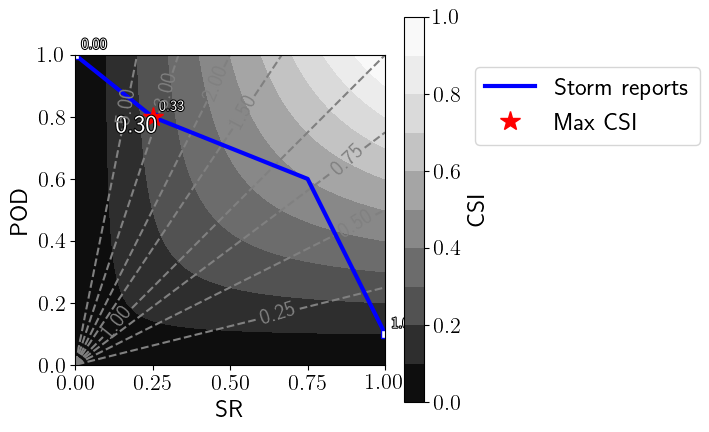

In [ ]:
print(ftime, stat)
fname = "" #os.path.join(dirpath, f"{FN_PREFIX}_csi_train_val.png")
figax = plot_csi(mask.ravel(), np.array([0, 1]), #wofs_prob[stat].ravel(), 
                 fname, threshs=np.linspace(0, 1, 4), label='Storm reports', color='blue', 
                 save=False, srs_pods_csis=(np.array([0, .25, .75, 1]), np.array([1, .8, .6, .1]), np.array([.1, .3, .2, .1])), 
                 return_scores=False, fig_ax=None, 
                 figsize=(5, 5))

/home/momoshog/Tornado/tornado_jtti/lydia_scripts/scripts_tensorboard/unet_hypermodel.py:1075: RuntimeWarning:

invalid value encountered in divide



Max CSI: 0.08. SR=0.105. POD=0.211


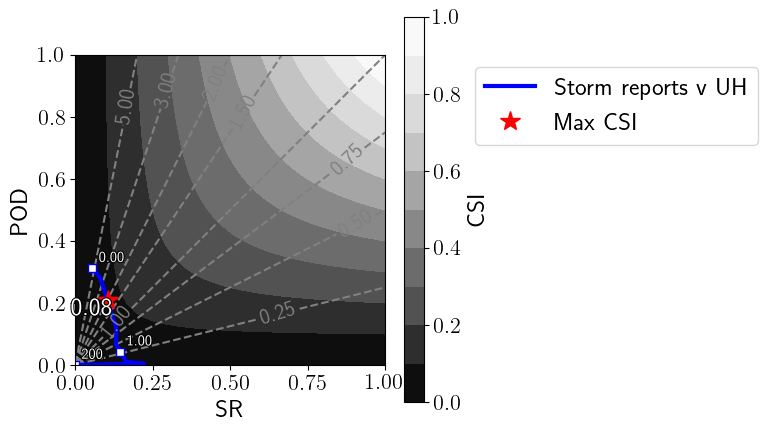

In [ ]:
#uh_qs = np.linspace(0, 1, num=21) #, endpoint=True, base=10)
uh_threshs = np.array([0, .01, .02, .025, .05, .1, .2, .25, .5, 1, 5, 10, 20, 25, 40, 50, 80, 100, 200]) #np.quantile(wofs_uh[stat], uh_qs)
results = wpe.compute_performance(mask, wofs_uh[stat], uh_threshs, compute_sr_pod_csi=True)

fname = "" #os.path.join(dirpath, f"{FN_PREFIX}_csi_train_val.png")
figax = plot_csi(mask.ravel(), wofs_uh[stat].ravel(), 
                 fname, threshs=uh_threshs, label='Storm reports v UH', color='blue', 
                 save=False, srs_pods_csis=(results['srs'], results['pods'], results['csis']), 
                 return_scores=False, fig_ax=None, 
                 figsize=(5, 5))

In [ ]:
np.nanquantile(wofs_uh[stat], [0, 1])

array([ 0.      , 27.324219], dtype=float32)

Max CSI: 0.08. SR=0.105. POD=0.211


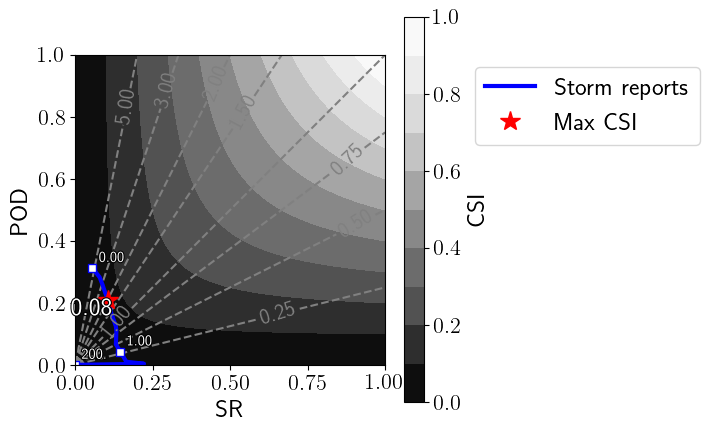

In [ ]:
fname = "" #os.path.join(dirpath, f"{FN_PREFIX}_csi_train_val.png")
figax = plot_csi(mask.ravel(), wofs_uh[stat].ravel(), 
                 fname, threshs=uh_threshs, label='Storm reports', color='blue', 
                 save=False, srs_pods_csis=(results['srs'], results['pods'], results['csis']), 
                 return_scores=False, fig_ax=None, 
                 figsize=(5, 5))

In [ ]:
confusion_matrix([0, 1, 0, 0, 1], [0, 0, 0, 0, 0])

array([[3, 0],
       [2, 0]])

# NATE ENSEMBLE MEAN/MEDIAN

In [96]:
_tmp = xr.load_dataset('/ourdisk/hpc/ai2es/nsnook/WoFS_summary_data_2019/summary_data_2019-05-18_23:00:00.netcdf')
_tmp

<xarray.Dataset>
Dimensions:                          (member: 18, t_fcst: 37, y: 300, x: 300)
Coordinates:
    latitude                         (y, x) float32 29.61 29.61 ... 37.78 37.78
    longitude                        (y, x) float32 -100.6 -100.6 ... -90.69
Dimensions without coordinates: member, t_fcst, y, x
Data variables:
    ML_probability                   (member, t_fcst, y, x) float32 0.0 ... 0...
    UH                               (member, t_fcst, y, x) float32 0.0 ... 0.0
    COMPOSITE_REFL                   (member, t_fcst, y, x) float32 0.0 ... 0.0
    ens_mean_ML_probability          (t_fcst, y, x) float32 0.0 0.0 ... 0.005859
    ens_mean_UH                      (t_fcst, y, x) float32 0.0 0.0 ... 0.0 0.0
    ens_median_ML_probability        (t_fcst, y, x) float32 0.0 0.0 ... 0.003906
    ens_median_UH                    (t_fcst, y, x) float32 0.0 0.0 ... 0.0 0.0
    ens_percentile90_ML_probability  (t_fcst, y, x) float32 0.0 0.0 ... 0.01172
    ens_percentile90_UH              (t_fcst, y, x) float32 0.0 0.0 ... 0.0 0.0
Attributes:
    description:  WoFS ML tornado forecast summary file
    valid_time:   2019-05-18_23:00:00

In [97]:
sorted(os.listdir('/ourdisk/hpc/ai2es/nsnook/WoFS_summary_data_2019'))

['README.txt',
 'summary_data_2019-04-29_19:00:00.netcdf',
 'summary_data_2019-04-29_19:30:00.netcdf',
 'summary_data_2019-04-29_20:00:00.netcdf',
 'summary_data_2019-04-29_20:30:00.netcdf',
 'summary_data_2019-04-29_21:00:00.netcdf',
 'summary_data_2019-04-29_21:30:00.netcdf',
 'summary_data_2019-04-29_22:00:00.netcdf',
 'summary_data_2019-04-29_22:30:00.netcdf',
 'summary_data_2019-04-29_23:00:00.netcdf',
 'summary_data_2019-04-29_23:30:00.netcdf',
 'summary_data_2019-04-30_00:00:00.netcdf',
 'summary_data_2019-04-30_00:30:00.netcdf',
 'summary_data_2019-04-30_01:00:00.netcdf',
 'summary_data_2019-04-30_01:30:00.netcdf',
 'summary_data_2019-04-30_02:00:00.netcdf',
 'summary_data_2019-04-30_02:30:00.netcdf',
 'summary_data_2019-04-30_03:00:00.netcdf',
 'summary_data_2019-04-30_19:00:00.netcdf',
 'summary_data_2019-04-30_19:30:00.netcdf',
 'summary_data_2019-04-30_20:00:00.netcdf',
 'summary_data_2019-04-30_20:30:00.netcdf',
 'summary_data_2019-04-30_21:00:00.netcdf',
 'summary_data_20

In [98]:
_tmp = xr.load_dataset('/ourdisk/hpc/ai2es/nsnook/WoFS_summary_data_2019/summary_data_2019-05-02_19:00:00.netcdf')

[Text(0.5, 1.0, 'ENS Mean UH')]

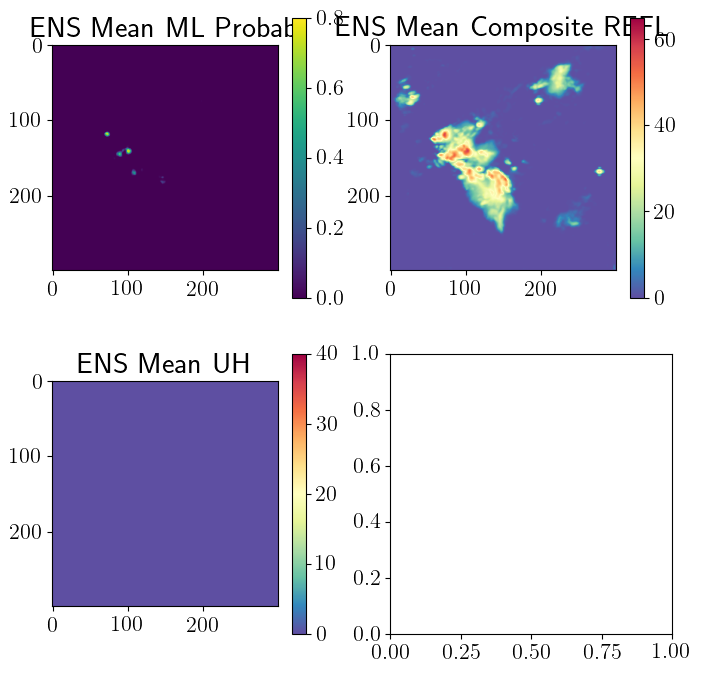

In [99]:
_f, _a = plt.subplots(2, 2, figsize=(8,8))
_a = _a.ravel()

im = _a[0].imshow(_tmp['ens_mean_ML_probability'][0], vmin=0, vmax=.8) #COMPOSITE_REFL ML_probability UH
plt.colorbar(im, ax=_a[0])
_a[0].set(title='ENS Mean ML Probab')

_mn = _tmp['COMPOSITE_REFL'].mean(dim='member')
im = _a[1].imshow(_mn[0], cmap='Spectral_r', vmin=0, vmax=65)
plt.colorbar(im, ax=_a[1])
_a[1].set(title='ENS Mean Composite REFL')

_mn = _tmp['UH'].mean(dim='member')
im = _a[2].imshow(_mn[0], cmap='Spectral_r', vmin=0, vmax=40)
plt.colorbar(im, ax=_a[2])
_a[2].set(title='ENS Mean UH')

In [100]:
import ipywidgets as widgets

In [103]:
#%matplotlib tk

all_frames = _tmp['ens_mean_ML_probability']
nframes = all_frames.shape[0]

def storm_frame(pi):
    im = plt.imshow(all_frames[pi], vmin=0, vmax=.8)
    plt.title(pi)
    plt.colorbar(im)
    #plt.aspect('equal')
    #if invert_yaxis: axs[0].invert_yaxis()

owidget = widgets.interact(storm_frame, pi=widgets.Play(0, min=0, 
                                                        max=(nframes-1), 
                                                        step=1, interval=200))
owidget

interactive(children=(Play(value=0, description='pi', interval=200, max=36), Output()), _dom_classes=('widget-…

<function __main__.storm_frame(pi)>

xr version 2023.8.0
np version 1.24.2
pd version 1.5.3


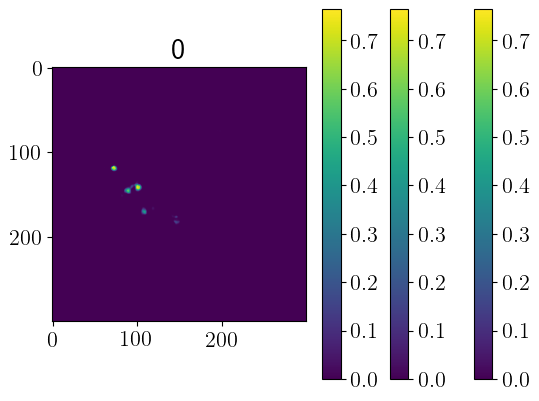

In [ ]:
#%matplotlib inline
# Enable interactive plot
#%matplotlib notebook

all_frames = _tmp['ens_mean_ML_probability']
nframes = 10 #all_frames.shape[0]
invert_yaxis=False
figsize=(8, 5)
interval=200
kwargs={}

#def create_gif(all_frames, invert_yaxis=False, figsize=(20, 10),
#               nframes=None, interval=50, **kwargs):

'''
Create a .gif or movie
https://www.c-sharpcorner.com/article/create-animated-gif-using-python-matplotlib/
https://stackoverflow.com/questions/67364991/python-matplotlib-animation-jupyter-notebook
https://www.youtube.com/watch?v=0bNh3kbONXo
https://stackoverflow.com/questions/62494619/matplotlib-animation-not-working-on-jupyter-notebook
*https://stackoverflow.com/questions/25333732/matplotlib-animation-not-working-in-ipython-notebook-blank-plot
https://stackoverflow.com/questions/35532498/animation-in-ipython-notebook
https://stackoverflow.com/questions/76632075/how-do-i-show-animation-in-jupyter
https://stackoverflow.com/questions/43445103/inline-animations-in-jupyter
https://gist.github.com/iwatake2222/43b1d8bc1dcfd2f0bf19a81486985d59
https://stackoverflow.com/questions/62411273/how-to-use-matplotlib-funcanimation-to-animate-a-heatmap
https://github.com/BindiChen/machine-learning/blob/main/data-visualization/0002-matplotlib-animation-with-regression/matplotlib-linear-regression-animation.ipynb
https://stackoverflow.com/questions/13320262/calculating-the-area-under-a-curve-given-a-set-of-coordinates-without-knowing-t
'''
'''fig = None
axs = None
fig, axs = plt.subplots(2, 2, figsize=figsize)
axs = axs.ravel()'''

im = None
def draw_storm_frame(pi):
    '''
    Draw a patch as a single frame
    @param pi: patch index (aka draw frame index)
    '''
    '''if isinstance(axs, list) or isinstance(axs, np.ndarray):
        for a in axs: a.clear()
    else: axs.clear()'''

    #fig.suptitle(rf'[{ftimes[pi]}] dist $<$ {thres_dist}km, time $<$ {thres_time}min')

    im = plt.imshow(all_frames[pi])
    #if pi == 0: plt.colorbar(im)
    plt.title(pi)
    '''im = axs[0].imshow(all_frames[pi]) #
    axs[0].set_aspect('equal')
    if invert_yaxis: axs[0].invert_yaxis()'''

    '''fig.canvas.draw() # draw the canvas, cache renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    WIDTH, HEIGHT = fig.canvas.get_width_height()
    image = image.reshape(HEIGHT, WIDTH, 3) # 3 for RGB
    return image'''
    return im

#im = draw_storm_frame(0)

fig = plt.figure()
animator = FuncAnimation(fig, draw_storm_frame, frames=nframes, 
                         interval=interval, repeat=True, **kwargs)
plt.colorbar(im)
#plt.show()
    #return fig, animator

#ani = create_gif(all_frames, invert_yaxis=False, figsize=(8, 5),
#                 nframes=nframes, interval=100) #, **kwargs)
animator

# PROCESSED REPORTS

In [ ]:
_2019reports = pd.read_csv('/ourdisk/hpc/ai2es/tornado/stormreports/processed/tornado_reports_2019.csv')
_2019reports.head(12)

start_time_unix_sec  end_time_unix_sec  start_latitude_deg  end_latitude_deg  start_longitude_deg  end_longitude_deg f_or_ef_rating  width_metres
0            1555709460         1555709580             37.6990           37.7200             281.2110           281.2190            EF1     38.100463
1            1555721700         1555722000             38.9302           38.9861             282.6217           282.6485            EF0     30.480371
2            1556306340         1556306580             39.5647           39.5934             283.3897           283.4305            EF1     45.720556
3            1565570820         1565571120             39.6813           39.6950             258.3424           258.3570            EF1     53.340649
4            1555228200         1555228320             30.4754           30.4872             271.4405           271.4529            EF1     15.240185
5            1554686340         1554686520             29.9528           29.9831             269.7631           269.7883            EF0     15.240185
6            1577667000         1577667420             34.7541           34.7946             272.9223           272.9959            EF0     15.240185
7            1558249320         1558249500             31.3732           31.3840             267.0010           267.0168            EF0     24.384297
8            1567688520         1567690260             34.6564           34.7957             282.9476           282.7846            EF2     60.960741
9            1556209320         1556209380             30.3935           30.3935             270.5547           270.5589            EF1      7.620093
10           1567708200         1567708680             35.3502           35.3801             282.8802           282.7848            EF0     22.860278
11           1567717200         1567717260             35.1061           35.1069             282.9620           282.9609            EF0     22.860278

In [ ]:
_2019reports.shape

(1533, 8)

In [ ]:
_2019reports.sort_values(by=['start_time_unix_sec', 'end_time_unix_sec'], inplace=True)
_2019reports.head(8)

start_time_unix_sec  end_time_unix_sec  start_latitude_deg  end_latitude_deg  start_longitude_deg  end_longitude_deg f_or_ef_rating  width_metres
22           1546598280         1546598400             31.6165           31.6169             274.7212           274.7237            EF0     10.668130
21           1546600200         1546600320             31.5976           31.6003             275.0365           275.0389            EF1     27.432334
30           1546804740         1546805040             36.9600           36.9600             237.9600           237.9600            EF0      2.033041
36           1546805940         1546806000             36.9569           36.9569             237.9819           237.9819            EF0      2.033041
34           1546960800         1546961160             41.3226           41.3303             279.1847           279.2715            EF1     22.860278
43           1546964700         1546964880             41.4400           41.4400             279.9400           279.9400            EF1    121.921483
35           1547767200         1547767500             36.8400           36.8403             240.4400           240.4560            EF1      6.096074
32           1547901720         1547901960             32.8759           32.8960             270.4830           270.4806            EF1     76.200927

In [ ]:
_lat_storms = _2019reports['start_latitude_deg']

In [ ]:
_lon_storms = _2019reports['start_longitude_deg']

In [ ]:
_2019reports['start_datetime_utc'] = pd.to_datetime(_2019reports['start_time_unix_sec'], unit='s')
_2019reports['end_datetime_utc'] = pd.to_datetime(_2019reports['end_time_unix_sec'], unit='s')

#_2019reports['start_date'] = pd.to_datetime(_2019reports['start_time_unix_sec'], format='%Y_%d_%m')

_2019reports[['start_datetime_utc', 'end_datetime_utc']].head(12) #'start_date', 

start_datetime_utc    end_datetime_utc
22 2019-01-04 10:38:00 2019-01-04 10:40:00
21 2019-01-04 11:10:00 2019-01-04 11:12:00
30 2019-01-06 19:59:00 2019-01-06 20:04:00
36 2019-01-06 20:19:00 2019-01-06 20:20:00
34 2019-01-08 15:20:00 2019-01-08 15:26:00
43 2019-01-08 16:25:00 2019-01-08 16:28:00
35 2019-01-17 23:20:00 2019-01-17 23:25:00
32 2019-01-19 12:42:00 2019-01-19 12:46:00
38 2019-01-19 13:38:00 2019-01-19 13:41:00
39 2019-01-19 13:44:00 2019-01-19 13:47:00
41 2019-01-19 14:43:00 2019-01-19 14:44:00
59 2019-01-19 15:22:00 2019-01-19 15:22:00

In [ ]:
_2019reports["start_datetime_utc"].dt

In [ ]:
_2019reports_re = _2019reports.set_index('start_datetime_utc')
_2019reports_re.head(8)

start_time_unix_sec  end_time_unix_sec  start_latitude_deg  end_latitude_deg  start_longitude_deg  end_longitude_deg f_or_ef_rating  width_metres    end_datetime_utc
start_datetime_utc                                                                                                                                                                        
2019-01-04 10:38:00           1546598280         1546598400             31.6165           31.6169             274.7212           274.7237            EF0     10.668130 2019-01-04 10:40:00
2019-01-04 11:10:00           1546600200         1546600320             31.5976           31.6003             275.0365           275.0389            EF1     27.432334 2019-01-04 11:12:00
2019-01-06 19:59:00           1546804740         1546805040             36.9600           36.9600             237.9600           237.9600            EF0      2.033041 2019-01-06 20:04:00
2019-01-06 20:19:00           1546805940         1546806000             36.9569           36.9569             237.9819           237.9819            EF0      2.033041 2019-01-06 20:20:00
2019-01-08 15:20:00           1546960800         1546961160             41.3226           41.3303             279.1847           279.2715            EF1     22.860278 2019-01-08 15:26:00
2019-01-08 16:25:00           1546964700         1546964880             41.4400           41.4400             279.9400           279.9400            EF1    121.921483 2019-01-08 16:28:00
2019-01-17 23:20:00           1547767200         1547767500             36.8400           36.8403             240.4400           240.4560            EF1      6.096074 2019-01-17 23:25:00
2019-01-19 12:42:00           1547901720         1547901960             32.8759           32.8960             270.4830           270.4806            EF1     76.200927 2019-01-19 12:46:00

In [ ]:
df = _2019reports_re['2019-04-28':'2019-06-03']
df.reset_index().head(5)

start_datetime_utc  start_time_unix_sec  end_time_unix_sec  start_latitude_deg  end_latitude_deg  start_longitude_deg  end_longitude_deg f_or_ef_rating  width_metres    end_datetime_utc
0 2019-04-29 09:10:00           1556529000         1556529180             38.5032           38.4879             265.1739           265.2066            EF0      4.572056 2019-04-29 09:13:00
1 2019-04-30 16:53:00           1556643180         1556643660             35.8850           35.9170             263.1430           263.1770            EF1      9.144111 2019-04-30 17:01:00
2 2019-04-30 17:13:00           1556644380         1556644440             35.9900           35.9940             263.2540           263.2600            EF1      6.096074 2019-04-30 17:14:00
3 2019-04-30 17:22:00           1556644920         1556644980             34.5040           34.5060             263.1298           263.1316            EF1      9.144111 2019-04-30 17:23:00
4 2019-04-30 17:23:00           1556644980         1556645460             34.5060           34.5257             263.1316           263.1508            EF1      9.144111 2019-04-30 17:31:00

## Storm Report Counts by Day

start_datetime_utc  start_datetime_utc  start_datetime_utc
2019                4                   29                     1
                                        30                    34
                    5                   1                     31
                                        2                     17
                                        3                      9
                                        4                      2
                                        5                      7
                                        6                      8
                                        7                      7
                                        8                     30
                                        9                      6
                                        11                     3
                                        12                     1
                                        13                     2
                               

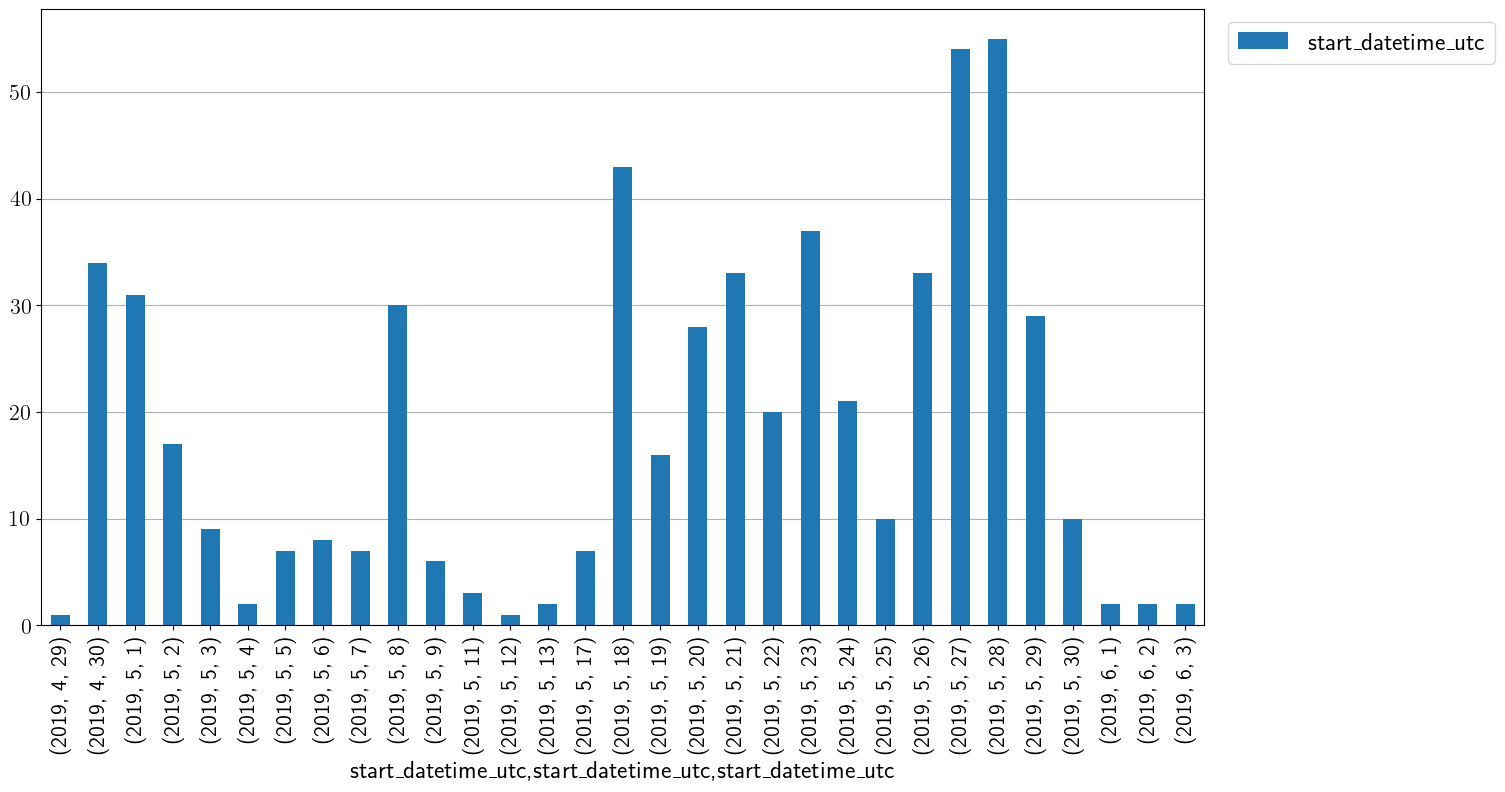

In [ ]:
df = _2019reports_re['2019-04-28':'2019-06-03']
df = df.reset_index()

#df['start_datetime_utc'].dt.day_of_year
by = [df['start_datetime_utc'].dt.year, df['start_datetime_utc'].dt.month, df['start_datetime_utc'].dt.day]
bar_plt = df['start_datetime_utc'].groupby(by).count().plot(kind="bar", x='start_datetime_utc', figsize=(15,8))
#bar_plt = df['start_datetime_utc'].groupby(df['start_datetime_utc'].dt.month).count().plot(kind="bar", x='start_datetime_utc')
#bar_plt = _2019reports["start_datetime_utc"].groupby(_2019reports["start_datetime_utc"].dt.month).plot(kind="bar")
plt.gca().set_axisbelow(True)
#plt.rc('axes', axisbelow=True)
plt.grid(axis='y')
bar_plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
df['start_datetime_utc'].groupby(by).count()

In [ ]:
#pd.date_range(_2019reports_re['start_datetime_utc'], _2019reports_re['end_datetime_utc'], freq='1M')
np.arange(_2019reports_re['start_time_unix_sec'].iloc[0], _2019reports_re['end_time_unix_sec'].iloc[0], 1e2)

array([1.54659828e+09, 1.54659838e+09])

In [ ]:
def new_reports_list(df, dstart, dend):
    df_trim = df[dstart:dend]
    df_copy = df_trim.copy()
    for row in df_trim:
        pass

In [ ]:
_times_storms = np.array([d.to_pydatetime() for d in pd.to_datetime(_2019reports['start_time_unix_sec'].values, unit='s')])
_times_storms

array([datetime.datetime(2019, 1, 4, 10, 38),
       datetime.datetime(2019, 1, 4, 11, 10),
       datetime.datetime(2019, 1, 6, 19, 59), ...,
       datetime.datetime(2019, 12, 29, 22, 32),
       datetime.datetime(2019, 12, 29, 23, 13),
       datetime.datetime(2019, 12, 30, 0, 50)], dtype=object)

In [ ]:
_times_storms_end = np.array([d.to_pydatetime() for d in pd.to_datetime(_2019reports['end_time_unix_sec'].values, unit='s')])
_times_storms_end

array([datetime.datetime(2019, 1, 4, 10, 40),
       datetime.datetime(2019, 1, 4, 11, 12),
       datetime.datetime(2019, 1, 6, 20, 4), ...,
       datetime.datetime(2019, 12, 29, 22, 35),
       datetime.datetime(2019, 12, 29, 23, 18),
       datetime.datetime(2019, 12, 30, 0, 57)], dtype=object)

In [ ]:
df_storm_report.head(8) #['DateTime']

Time            DateTime F_Scale             Location     County State    Lat    Lon                                           Comments
0    6 2019-04-30 00:06:00     UNK     5 WSW BRUSHYKNOB    DOUGLAS    MO  36.93 -92.57  NWS STORM SURVEY CONFIRMED AN EF-1 TORNADO WIT...
1   28 2019-04-30 00:28:00     UNK            2 N OZARK  CHRISTIAN    MO  37.07 -93.20  *** 3 INJ *** AN NWS STORM SURVEY CONFIRMED AN...
2   30 2019-04-30 00:30:00     UNK        4 WSW NORWOOD     WRIGHT    MO  37.10 -92.49  A NWS SURVEY TEAM CONFIRMED AN EF-1 TORNADO WH...
3   38 2019-04-30 00:38:00     UNK          6 NW MILLER   LAWRENCE    MO  37.29 -93.91  AN NWS STORM SURVEY CONFIRMED AN EF1 TORNADO T...
4   40 2019-04-30 00:40:00     UNK          1 SW EUDORA       POLK    MO  37.45 -93.56  AN NWS STORM SURVEY CONFIRMED AN EF1 TORNADO T...
5   58 2019-04-30 00:58:00     UNK  4 SW MOUNTAIN GROVE     WRIGHT    MO  37.09 -92.32  A NWS SURVEY TEAM CONFIRMED AN EF-0 TORNADO WH...
6  115 2019-04-30 01:15:00     UNK         2 NW WILLARD     GREENE    MO  37.33 -93.46  CORRECTS PREVIOUS TORNADO REPORT FROM 2 NW WIL...
7  121 2019-04-30 01:21:00     UNK         4 NE WILLARD     GREENE    MO  37.36 -93.39  AN NWS STORM SURVEY CONFIRMED AN EF1 TORNADO T...

In [ ]:
dtime

cftime.DatetimeGregorian(2019, 4, 30, 19, 40, 0, 0, has_year_zero=False)

In [ ]:
_2019reports_re['2019-04-28':'2019-06-03'].head(8)

start_time_unix_sec  end_time_unix_sec  start_latitude_deg  end_latitude_deg  start_longitude_deg  end_longitude_deg f_or_ef_rating  width_metres    end_datetime_utc
start_datetime_utc                                                                                                                                                                        
2019-04-29 09:10:00           1556529000         1556529180             38.5032           38.4879             265.1739           265.2066            EF0      4.572056 2019-04-29 09:13:00
2019-04-30 16:53:00           1556643180         1556643660             35.8850           35.9170             263.1430           263.1770            EF1      9.144111 2019-04-30 17:01:00
2019-04-30 17:13:00           1556644380         1556644440             35.9900           35.9940             263.2540           263.2600            EF1      6.096074 2019-04-30 17:14:00
2019-04-30 17:22:00           1556644920         1556644980             34.5040           34.5060             263.1298           263.1316            EF1      9.144111 2019-04-30 17:23:00
2019-04-30 17:23:00           1556644980         1556645460             34.5060           34.5257             263.1316           263.1508            EF1      9.144111 2019-04-30 17:31:00
2019-04-30 19:03:00           1556650980         1556651400             35.7058           35.7193             264.1253           264.1665            EF0     30.480371 2019-04-30 19:10:00
2019-04-30 19:14:00           1556651640         1556651760             36.3800           36.3886             263.9489           263.9684            EF0     15.240185 2019-04-30 19:16:00
2019-04-30 19:29:00           1556652540         1556652600             35.8546           35.8566             264.3078           264.3102            EF0     38.100463 2019-04-30 19:30:00

In [ ]:
# TODO: generate report row for each minute within the each start to end range
#
_mask, _sel_storms, _tree = wpe.create_storm_mask(xlats, xlons, datetime(2019, 4, 30, 16, 56), _lat_storms, #dtime
                                               _lon_storms, _times_storms, GRIDSIZE, 
                                               thres_dist=thres_dist, 
                                               thres_time=thres_time, 
                                               kdworkers=-1,
                                               times_storms_end=_times_storms_end)


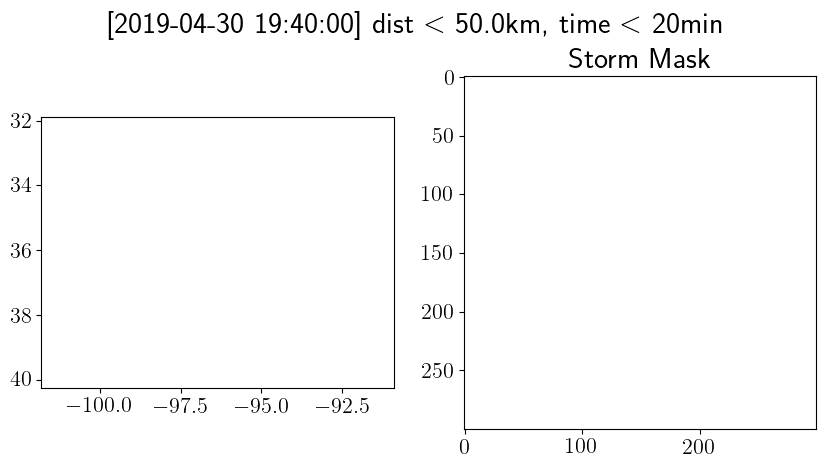

In [ ]:
ylims = np.quantile(xlats, [0, 1])
xlims = np.quantile(xlons, [0, 1])

figax_storms = wpe.plot_storms(_mask, _lon_storms[_sel_storms], _lat_storms[_sel_storms], 
                               figax=None, figsize=(10, 5), xlims=xlims, ylims=ylims, 
                               invert_yaxis=True, 
                               bcmap=mpl.colors.ListedColormap(['w', 'blue']))
figax_storms[0].suptitle(rf'[{dtime}] dist $<$ {thres_dist}km, time $<$ {thres_time}min');

# COMPUTE UH DISTRIBUTION FOR A DAY

In [ ]:
import dask

In [ ]:
ftime = None #'2019-04-30_19:05:00'
sel_files_ftime = select_files(df_all_files, init_time, ftime, emember=None)
print(sel_files_ftime.shape)

concat_dim = 'FILE'
_sel_files = list(sel_files_ftime['filename_path'].iloc[:20])
wofs_day = None
with dask.config.set(**{'array.slicing.split_large_chunks': True}): #file_cache_maxsize
    wofs_day = xr.open_mfdataset(_sel_files, concat_dim=concat_dim, 
                                   chunks='auto', combine='nested', engine="netcdf4",
                                   coords='minimal', decode_times=False) #parallel=True, 
print(wofs_day['Time'])

#getattr(my_instance, method_name)() 'UP_HELI_MAX'
#elif stat == 'mean':
#wofs_cZH[stat] = wofs_preds['COMPOSITE_REFL_10CM'].mean().values
#wofs_prob[stat] = wofs_preds['ML_PREDICTED_TOR'].mean().values
#wofs_uh_mean = wofs_preds['UP_HELI_MAX'].mean().values
#wofs_uh_median = wofs_preds['UP_HELI_MAX'].median().values

(1350, 5)
<xarray.DataArray 'Time' (Time: 19)>
array([578343600, 578343900, 578344200, 578344500, 578344800, 578345100,
       578345400, 578345700, 578346000, 578346300, 578346600, 578346900,
       578347200, 578347500, 578347800, 578348100, 578348400, 578348700,
       578349000])
Coordinates:
  * Time     (Time) int64 578343600 578343900 578344200 ... 578348700 578349000
    XTIME    (Time) float32 dask.array<chunksize=(19,), meta=np.ndarray>


In [142]:
np.nanquantile(wofs_day['UP_HELI_MAX'].values, [0, .9, .95, .99, 1]) #0.0, .033, .016, 5.16, 241.25

NameError: name 'wofs_day' is not defined

In [ ]:
wofs_uh_min = wofs_day['UP_HELI_MAX'].min().values #
wofs_uh_max = wofs_day['UP_HELI_MAX'].max().values
wofs_uh_min.min(), wofs_uh_max.max()

(0.0, 165.8125)

# hagelslag demo

In [78]:
# Create cartopy projection for plots
# https://www.tensorflow.org/api_docs/python/tf/keras/metrics/MeanIoU
# https://stackoverflow.com/questions/49338166/python-intersection-over-union
# https://machinelearningspace.com/intersection-over-union-iou-a-comprehensive-guide/
# https://giou.stanford.edu/
''' (wofs.attrs)
'CEN_LON': -96.35736,
'CEN_LAT': 36.11251,
'TRUELAT1': 30.0,
'TRUELAT2': 60.0,
'''
proj_dict = {'lon_0':-96.35736, 
             'lat_0': 36.11251,
             'lat_1': 30,
             'lat_2': 60,
             'R': 6371229 # earth radius
             }

lcc = ccrs.LambertConformal(central_longitude=proj_dict["lon_0"], 
                            central_latitude=proj_dict["lat_0"], 
                            standard_parallels=(proj_dict["lat_1"], proj_dict["lat_2"]),
                            globe=ccrs.Globe(semimajor_axis=proj_dict["R"], semiminor_axis=proj_dict["R"]))

In [79]:
_DATE = '20190430'
_SDATE = '2019-04-30 19:00:00'
_EDATE = '2019-05-01 04:00:00'

In [80]:
_sel = (df_storm_report['DateTime'] >= _SDATE) & (df_storm_report['DateTime'] <= _EDATE)
df_storm_report[['DateTime', 'Lat', 'Lon']].loc[_sel]

DateTime    Lat     Lon
35 2019-04-30 19:10:00  35.73  -95.85
36 2019-04-30 19:15:00  36.38  -96.05
37 2019-04-30 19:29:00  35.85  -95.69
38 2019-04-30 19:50:00  36.53  -95.77
39 2019-04-30 20:00:00  36.85  -95.64
40 2019-04-30 20:05:00  36.31  -93.01
41 2019-04-30 20:07:00  35.98  -95.39
42 2019-04-30 20:10:00  36.33  -92.99
43 2019-04-30 20:20:00  36.38  -92.94
44 2019-04-30 20:22:00  37.21  -93.84
45 2019-04-30 20:30:00  37.21  -93.84
46 2019-04-30 20:42:00  36.71  -94.17
47 2019-04-30 20:43:00  36.76  -94.19
48 2019-04-30 20:46:00  36.74  -94.07
49 2019-04-30 20:49:00  36.53  -95.77
50 2019-04-30 20:50:00  36.54  -92.78
51 2019-04-30 20:51:00  36.27  -95.15
52 2019-04-30 20:51:00  34.27  -98.81
53 2019-04-30 20:52:00  39.05  -89.47
54 2019-04-30 20:56:00  36.76  -94.06
55 2019-04-30 21:11:00  36.71  -92.65
56 2019-04-30 21:18:00  36.83  -95.05
57 2019-04-30 21:25:00  36.85  -93.85
58 2019-04-30 21:27:00  32.88 -101.14
59 2019-04-30 21:32:00  36.87  -94.84
60 2019-04-30 21:34:00  33.99  -98.40
61 2019-04-30 22:15:00  36.66  -93.26
62 2019-04-30 22:38:00  36.66  -94.92
63 2019-04-30 23:15:00  36.90  -92.89
64 2019-04-30 23:25:00  33.08  -97.28
65 2019-04-30 23:44:00  36.86  -92.62
66 2019-04-30 23:48:00  36.65  -93.88
67 2019-04-30 23:56:00  33.23  -97.14
68 2019-05-01 01:25:00  31.53  -97.87
69 2019-05-01 01:49:00  37.61  -92.89

### files list

In [81]:
_df_files = wpe.generate_ensemble_files_list_all(_dir, date=_DATE, 
                                                          itime=init_time, 
                                                          ens_names=[], 
                                                          save_path=None, 
                                                          df_index=False, 
                                                          **extr_args)
print(_df_files.shape)
_df_files.head()

(1350, 5)


run_date init_time ensemble_member        forecast_time                                      filename_path
0  20190430      1900       ENS_MEM_1  2019-04-30_19:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
1  20190430      1900       ENS_MEM_1  2019-04-30_19:00:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
2  20190430      1900       ENS_MEM_1  2019-04-30_19:05:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
3  20190430      1900       ENS_MEM_1  2019-04-30_19:10:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...
4  20190430      1900       ENS_MEM_1  2019-04-30_19:15:00  /ourdisk/hpc/ai2es/momoshog/Tornado/tornado_jt...

In [82]:
summary_files = []
_forecast_times = np.sort(np.unique(_df_files['forecast_time']))
for ft in _forecast_times:
    _fn = f'/ourdisk/hpc/ai2es/nsnook/WoFS_summary_data_2019/summary_data_{ft}.netcdf'
    if os.path.exists(_fn):
        summary_files.append(_fn)

print(len(summary_files))
summary_files[:5]

13


['/ourdisk/hpc/ai2es/nsnook/WoFS_summary_data_2019/summary_data_2019-04-30_19:00:00.netcdf',
 '/ourdisk/hpc/ai2es/nsnook/WoFS_summary_data_2019/summary_data_2019-04-30_19:30:00.netcdf',
 '/ourdisk/hpc/ai2es/nsnook/WoFS_summary_data_2019/summary_data_2019-04-30_20:00:00.netcdf',
 '/ourdisk/hpc/ai2es/nsnook/WoFS_summary_data_2019/summary_data_2019-04-30_20:30:00.netcdf',
 '/ourdisk/hpc/ai2es/nsnook/WoFS_summary_data_2019/summary_data_2019-04-30_21:00:00.netcdf']

### load files

In [83]:
wofs_hag = xr.open_mfdataset(summary_files, concat_dim='t_fcst', 
                             combine='nested', coords='minimal')
print(wofs_hag.coords)
wofs_hag

Coordinates:
    latitude   (y, x) float32 dask.array<chunksize=(300, 300), meta=np.ndarray>
    longitude  (y, x) float32 dask.array<chunksize=(300, 300), meta=np.ndarray>


<xarray.Dataset>
Dimensions:                          (member: 18, t_fcst: 481, y: 300, x: 300)
Coordinates:
    latitude                         (y, x) float32 dask.array<chunksize=(300, 300), meta=np.ndarray>
    longitude                        (y, x) float32 dask.array<chunksize=(300, 300), meta=np.ndarray>
Dimensions without coordinates: member, t_fcst, y, x
Data variables:
    ML_probability                   (member, t_fcst, y, x) float32 dask.array<chunksize=(18, 37, 300, 300), meta=np.ndarray>
    UH                               (member, t_fcst, y, x) float32 dask.array<chunksize=(18, 37, 300, 300), meta=np.ndarray>
    COMPOSITE_REFL                   (member, t_fcst, y, x) float32 dask.array<chunksize=(18, 37, 300, 300), meta=np.ndarray>
    ens_mean_ML_probability          (t_fcst, y, x) float32 dask.array<chunksize=(37, 300, 300), meta=np.ndarray>
    ens_mean_UH                      (t_fcst, y, x) float32 dask.array<chunksize=(37, 300, 300), meta=np.ndarray>
    ens_median_ML_probability        (t_fcst, y, x) float32 dask.array<chunksize=(37, 300, 300), meta=np.ndarray>
    ens_median_UH                    (t_fcst, y, x) float32 dask.array<chunksize=(37, 300, 300), meta=np.ndarray>
    ens_percentile90_ML_probability  (t_fcst, y, x) float32 dask.array<chunksize=(37, 300, 300), meta=np.ndarray>
    ens_percentile90_UH              (t_fcst, y, x) float32 dask.array<chunksize=(37, 300, 300), meta=np.ndarray>
Attributes:
    description:  WoFS ML tornado forecast summary file
    valid_time:   2019-04-30_19:00:00

In [84]:
_storm_lats = df_storm_report['Lat'].loc[_sel].values
_storm_lons = df_storm_report['Lon'].loc[_sel].values
_storm_times = np.array([d.to_pydatetime() for d in pd.to_datetime(df_storm_report['DateTime'].loc[_sel].values)])

_wofs_lat = wofs_hag.latitude.values
_wofs_lon = wofs_hag.longitude.values

_storm_mask, sel_storms, tree = wpe.create_storm_mask(_wofs_lat, _wofs_lon, None, 
                                                      _storm_lats, _storm_lons, 
                                                      _storm_times, GRIDSIZE, 
                                                      thres_dist=thres_dist, 
                                                      thres_time=thres_time, 
                                                      kdworkers=-1)

WoFS Lats Range [31.890625 40.25    ]
WoFS Lons Range [-101.8125  -90.9375]
Storm Lats Range [31.53 39.05]
Storm Lons Range [-101.14  -89.47]


((35,), (35,))

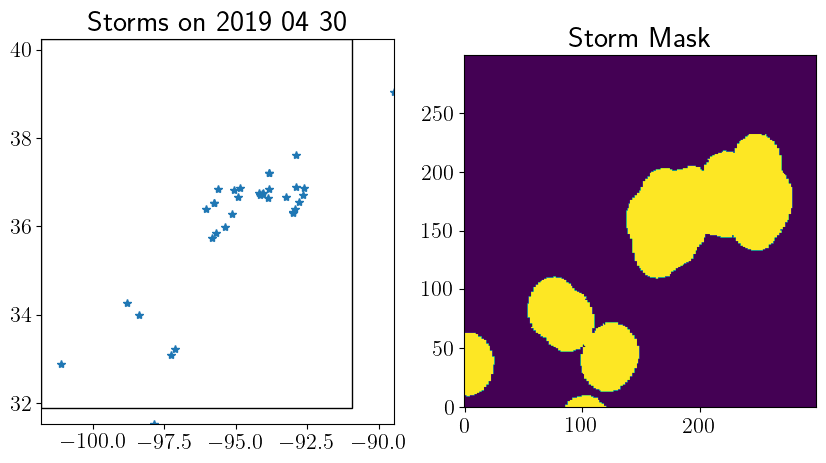

In [85]:
_xlat_range = np.quantile(_wofs_lat, [0,1])
_xlon_range = np.quantile(_wofs_lon, [0,1])
print("WoFS Lats Range", _xlat_range)
print("WoFS Lons Range", _xlon_range)

_storm_xrange = np.quantile(_storm_lons, [0,1])
_storm_yrange = np.quantile(_storm_lats, [0,1])
print("Storm Lats Range", _storm_yrange)
print("Storm Lons Range", _storm_xrange)

_f, _axs = plt.subplots(1, 2, figsize=(10,5))

xlim = [min(_xlon_range[0], _storm_xrange[0]), max(_xlon_range[1], _storm_xrange[1])]
ylim = [min(_xlat_range[0], _storm_yrange[0]), max(_xlat_range[1], _storm_yrange[1])]

width = np.diff(_xlon_range)[0]
height = np.diff(_xlat_range)[0]

rect = Rectangle((_xlon_range[0], _xlat_range[0]), width, height, 
                 facecolor='none', edgecolor='k')
_axs[0].add_patch(rect)

_axs[0].plot(_storm_lons, _storm_lats, '*')
_axs[0].set(xlim=xlim, ylim=ylim)
_axs[0].set_title('Storms on 2019 04 30')

#https://scitools.org.uk/cartopy/docs/latest/tutorials/understanding_transform.html
_axs[1].imshow(_storm_mask)
_axs[1].invert_yaxis()
_axs[1].set_title('Storm Mask')

_storm_lats.shape, _storm_lons.shape

(481, 300, 300) (300, 300) (300, 300) (300, 300)


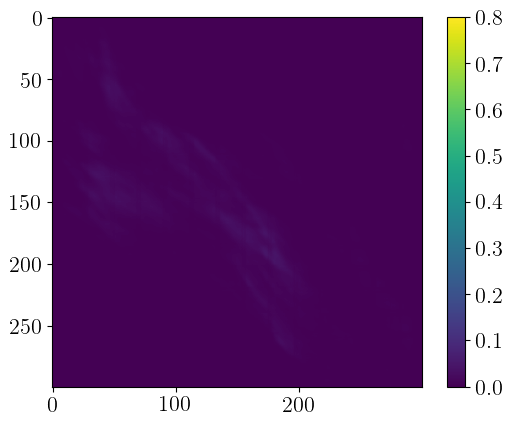

In [86]:
ml_preds = wofs_hag['ens_mean_ML_probability'].values
# Swap x and y axes
ml_preds = np.transpose(ml_preds, (0, 2, 1))

xlats = wofs_hag['latitude'].values.T
xlons = wofs_hag['longitude'].values.T

_mean = ml_preds.mean(axis=0)
_f, _a =  plt.subplots(1, 1)
#TODO: ax.set_extent(extent)
#_f, _a = wpe._add_cartopy(figaxs=None, ax_projection=lcc, lake_alpha=.4, 
#                          figsize=(5,4), dpi=160)
im = _a.imshow(_mean, vmin=0, vmax=.8) #, alpha=.3
#_a.invert_yaxis()
_f.colorbar(im, ax=_a)

print(ml_preds.shape, xlats.shape, xlons.shape, _mean.shape)

In [87]:
# data loads
# modelouptut optional. load into numpy array and coordinate info. convert km 
# tracker inprocessing 
#   pass in ml probab field as single time or multiple times 
# I picked min and max thresholds based on hand tuning. Setting too high a max_intensity can cause jets to drop segments.

# Setting too low a min_intensity 
min_intensity = .04 # Any pixel above this value adjacent is added to the initial set of objects based on proximity.
max_intensity = .2 # Objects must contain at least 1 pixel exceeding this value.
min_area = 10 # objects with fewer than this number of pixels are dropped.
gaussian_sd = 1 # standard deviation of gaussian smoother in number of grid cells. Can smooth out small-scale features, like storms.
max_nonoverlap = .99 # Range: 0 to 1. provides tolerance for proportion of non-overlapping pixels that's too many for a match
max_centroid = .25

# times=forecast_hours: List or array of time values, preferably as integers
ntimes = ml_preds.shape[0]
forecast_hours = np.linspace(0, ntimes - 1, ntimes, dtype=int) #wofs_test.Time.values
#dx: grid spacing in same units as x_grid and y_grid.
#dt: period elapsed between times

jet_outlines = tracker.label_storm_objects(ml_preds, "ws", min_intensity, max_intensity,
                                           min_area=min_area, gaussian_sd=gaussian_sd)
jet_obj_list = tracker.extract_storm_objects(jet_outlines, ml_preds, xlons, xlats, 
                                             forecast_hours, dx=1, dt=1, buffer_radius=0)

# TRACKING
tracked_jets = tracker.track_storms(jet_obj_list, forecast_hours, [nonoverlap], 
                                    np.array([max_nonoverlap]), np.array([1.0]))
#tracked_jets = tracker.track_storms(jet_obj_list, forecast_hours, [nonoverlap], np.array([max_nonoverlap]), np.array([1.0]))

tracked_jets_centroids = tracker.track_storms(jet_obj_list, forecast_hours, 
                                              [centroid_distance], 
                                              np.array([max_centroid]), 
                                              np.array([1.0]))

#make_forecast_track_data
#STOBJECT to extract details 
#extract_torm_objects

Found 19 storm objects.


In [88]:
def create_storm_mask_track(tracked_storm, tracked_datetimes, storm_lats, storm_lons):
        '''
        '''
        com = np.array([tracked_storm.center_of_mass(t) for t in tracked_storm.times])
        xmin, xmax = np.quantile(com[:,0], [0,1])
        ymin, ymax = np.quantile(com[:,1], [0,1])
        _mask = np.zeros((xmax-xmin, ymax-ymin), int)
        #y_preds = grey_dilation(y_preds, footprint=footprint)

        for dtime in tracked_datetimes:
                mask, sel_storms, tree = wpe.create_storm_mask(_wofs_lat, _wofs_lon, dtime, 
                                                      storm_lats, storm_lons, 
                                                      _storm_times, GRIDSIZE, 
                                                      thres_dist=thres_dist, 
                                                      thres_time=thres_time, 
                                                      kdworkers=-1)

In [94]:
tracked_jets[0].times #tracked_jets_centroids[0].times

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20])

In [95]:
#tracked_jets[0].center_of_mass(578343900)
print(tracked_jets[0].center_of_mass(0))
tracked_jets_centroids[0].center_of_mass(0)

(-98.46024652513658, 36.498988659152204)


(-98.46024652513658, 36.498988659152204)

In [96]:
tracked_jets[0].trajectory()

array([[-98.46024653, -98.37864623, -98.31821285, -98.27358252,
        -98.2279734 , -98.17636313, -98.12526191, -98.06915742,
        -98.01062096, -97.94990475, -97.90167361, -97.85207286,
        -97.80286014, -97.74718378, -97.69657293, -97.63125389,
        -97.58011617, -97.52282991, -97.46271782, -97.40970947,
        -97.36517695],
       [ 36.49898866,  36.53442238,  36.58509929,  36.6430886 ,
         36.6946531 ,  36.74390396,  36.80155951,  36.8639158 ,
         36.92777382,  36.98778258,  37.05235602,  37.1089726 ,
         37.16462215,  37.21793531,  37.1992798 ,  37.19048331,
         37.20662774,  37.24679985,  37.25993054,  37.27950018,
         37.30041155]])

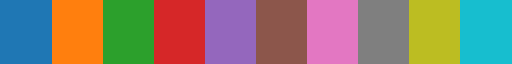

In [97]:
mpl.cm.tab10

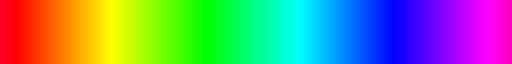

In [98]:
mpl.colormaps['gist_rainbow']

In [99]:
mpl.colormaps['gist_rainbow'](np.linspace(0,1, 5))

array([[1.        , 0.        , 0.16      , 1.        ],
       [0.80551139, 1.        , 0.        , 1.        ],
       [0.        , 1.        , 0.54817626, 1.        ],
       [0.        , 0.092711  , 1.        , 1.        ],
       [1.        , 0.        , 0.75      , 1.        ]])

# objects 481


(<Figure size 2000x800 with 1 Axes>, <GeoAxes: title={'center': 'nonoverlap'}>)

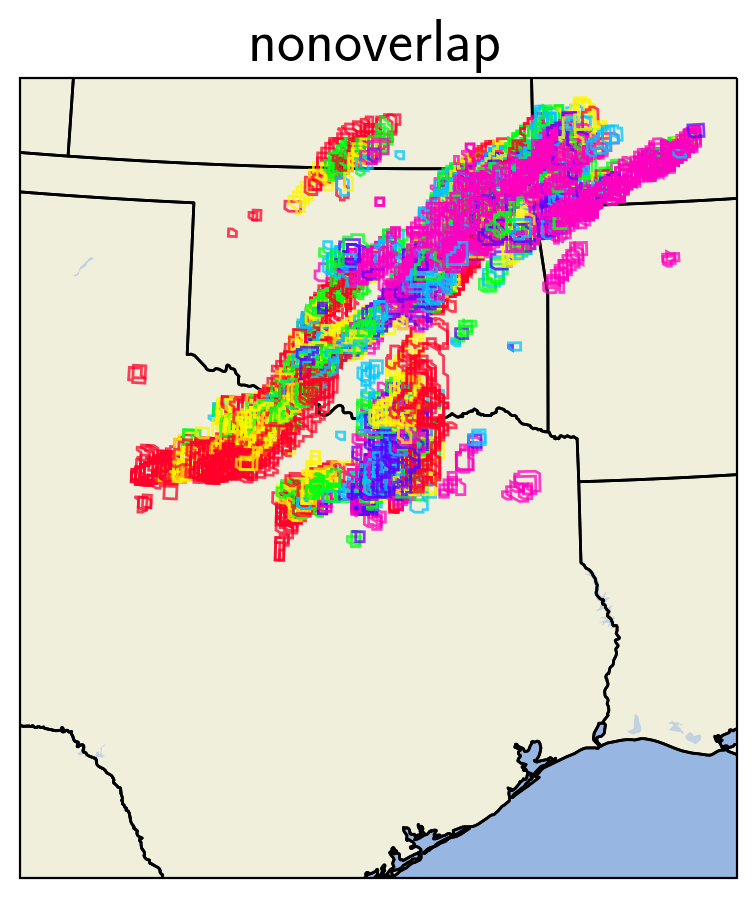

In [100]:
def plot_storm_objects(jet_obj_list, cfeature, title, fig_ax=None, extent=None, 
                       colors=mpl.cm.tab20.colors, figsize=(10,4), dpi=200, 
                       save=False, fnpath='storm_objects.png', DB=False):
    '''
    Plot storm objects
    Parameters
    -----------
    jet_obj_list: list of STObjects
    cfeature: cartopy
    title: figure title
    '''
    fig = None 
    ax = None 
    if fig_ax is None:
        fig = plt.figure(figsize=figsize, dpi=dpi)
        ax = fig.add_axes([1, 1, 1, 1], projection=lcc)
    else:
        fig, ax = fig_ax

    ax.set_facecolor(cfeature.COLORS['water'])
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle='--')
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.STATES)
    if extent:
        ax.set_extent(extent) #(-102, -92, 28, 38)) #-105, -90, 25, 40

    for t, jet_objs_t in enumerate(jet_obj_list):
        for o, jet_o in enumerate(jet_objs_t):
            p_coords = jet_o.boundary_contour(jet_o.times[0]).T
            if DB: print(t, o, p_coords.shape)
            ax.fill(p_coords[:, 0], p_coords[:, 1], edgecolor=colors[o], 
                    facecolor="none", alpha=.75, #(o+1)/25, #t/24, 
                    zorder=20, transform=ccrs.PlateCarree())

    ax.set_title(title)

    if save: plt.savefig(fnpath, bbox_inches="tight", dpi=dpi)

    return fig, ax

nobjs = len(jet_obj_list)
print("# objects", nobjs)
colors = mpl.colormaps['gist_rainbow'](np.linspace(0,100, nobjs))
#list(mpl.colors.CSS4_COLORS.keys()) #mpl.cm.tab20.colors
extent = (-102, -92, 28, 38)
plot_storm_objects(jet_obj_list, cfeature, title='nonoverlap', colors=colors,
                   fig_ax=None, figsize=(10,4), extent=extent, dpi=200)

### tracks

# tracks 432


'\nlat[31.53 39.05]\nlon[-101.14  -89.47]\n\nTODO: \n - plot max probab as func of time instead of translation speed \n - similar plots for uh with similar number of objects\n'

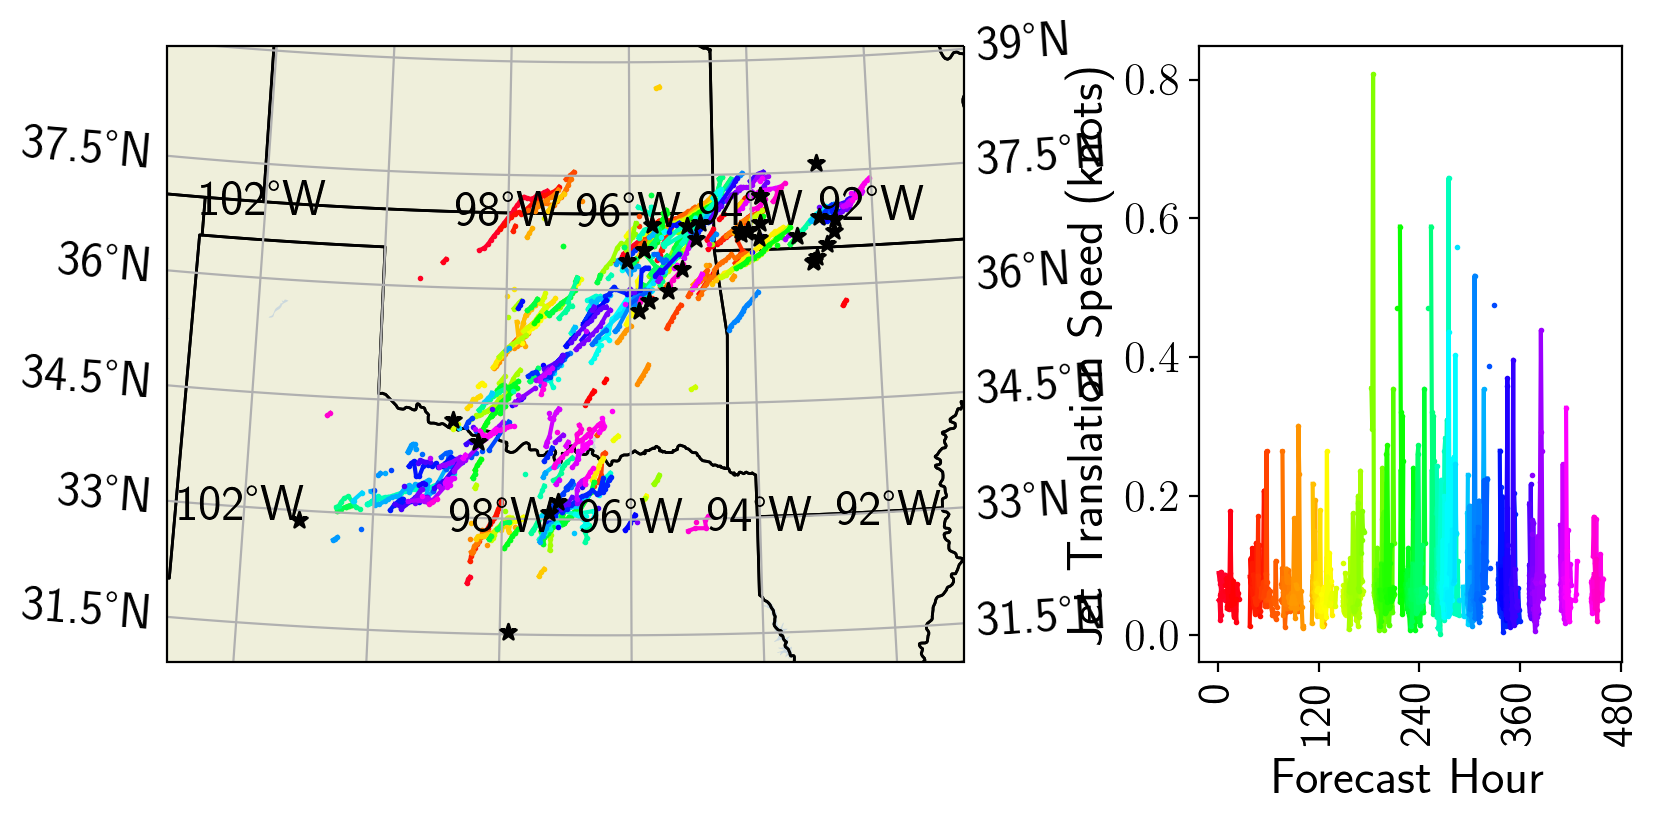

In [101]:
def plot_storm_tracks(tracked_jets, cfeature, title, track_colors, 
                      fig_ax_gs=None, figsize=(12,4), extent=None, dpi=300, 
                      save=False, fnpath='storm_tracks.png', DB=False):
    '''
    '''
    fig = None 
    ax = None 
    gs = None
    if fig_ax_gs is None:
        fig = plt.figure(figsize=figsize, dpi=dpi)
        gs = mpl.gridspec.GridSpec(1, 2, width_ratios=[0.7, 0.3])
        ax = fig.add_subplot(gs[0], projection=lcc)
    else:
        fig, ax, gs = fig_ax_gs

    ax.set_facecolor(cfeature.COLORS['water'])
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle='--')
    ax.add_feature(cfeature.LAKES, alpha=0.4)
    ax.add_feature(cfeature.STATES)
    if extent: ax.set_extent(extent) #(-125, -70, 22, 52))
    ax2 = fig.add_subplot(gs[1])

    for j, jet in enumerate(tracked_jets):
        if DB: print(j)
        # Time series plot
        com = np.array([jet.center_of_mass(t) for t in jet.times])
        if com.shape[0] > 1:
            speed = np.sqrt(np.sum((com[1:] - com[:-1]) ** 2, axis=1))#/ 3600 * 1.944
            ax2.plot(jet.times[1:], speed, color=track_colors[j], marker='o', ms=1)
        else:
            speed = [0]

        ax.plot(com[:, 0], com[:, 1], marker='o', ms=1, color=track_colors[j], 
                transform=ccrs.PlateCarree())
        
        '''for c in range(1, com.shape[0]):
            ax.text(com[c, 0], com[c, 1], f"{speed[c-1]:0.0f}", fontsize=5, 
                    ha='center', va='center', transform=ccrs.PlateCarree())'''

    #ax2.plot(np.arange(12, 37), np.ones(25) * 40, 'k--')
    ax2.set_ylabel("Jet Translation Speed (knots)")
    ax2.set_xlabel("Forecast Hour")
    n = len(forecast_hours)
    _sel = np.linspace(0, n-1, 5, dtype=int)
    ax2.set_xticks(forecast_hours[_sel])
    ax2.set_xticklabels(forecast_hours[_sel], rotation=90)
    #ax.set_title(run_date.strftime("%Y-%m-%d %H:%M UTC HRRR ") + "500 mb Jet Streak Trajectories")
    if save: plt.savefig(fnpath, bbox_inches="tight", dpi=dpi)

    return fig, [ax, ax2]

nobjs = len(tracked_jets)
print("# tracks", nobjs)
track_colors = mpl.colormaps['gist_rainbow'](np.linspace(0,1, nobjs))
#mpl.colors.ListedColormap(list(mpl.colors.CSS4_COLORS.keys()))
extent_tracks = (-103, -91, 31, 39) #extent #(-125, -70, 22, 52) # (west,east, south,north)
_f, _a = plot_storm_tracks(tracked_jets, cfeature, 'nonoverlap', track_colors, 
                  fig_ax_gs=None, figsize=(10,4), extent=extent_tracks, dpi=200, 
                  save=False, fnpath='storm_tracks.png')

glines = _a[0].gridlines(draw_labels=True)
glines.xformatter = LONGITUDE_FORMATTER
glines.yformatter = LATITUDE_FORMATTER
#_a[0].plot([-102], [31.5], marker='*', zorder=200, color='b', transform=ccrs.PlateCarree())
_a[0].scatter(_storm_lons, _storm_lats, marker='*', zorder=200, color='k', 
              transform=ccrs.PlateCarree()); #, edgecolor='k', facecolor='none');
'''
lat[31.53 39.05]
lon[-101.14  -89.47]

TODO: 
 - plot max probab as func of time instead of translation speed 
 - similar plots for uh with similar number of objects
'''

# tracks 761


(<Figure size 2000x800 with 2 Axes>,
 [<GeoAxes: >,
  <Axes: xlabel='Forecast Hour', ylabel='Jet Translation Speed (knots)'>])

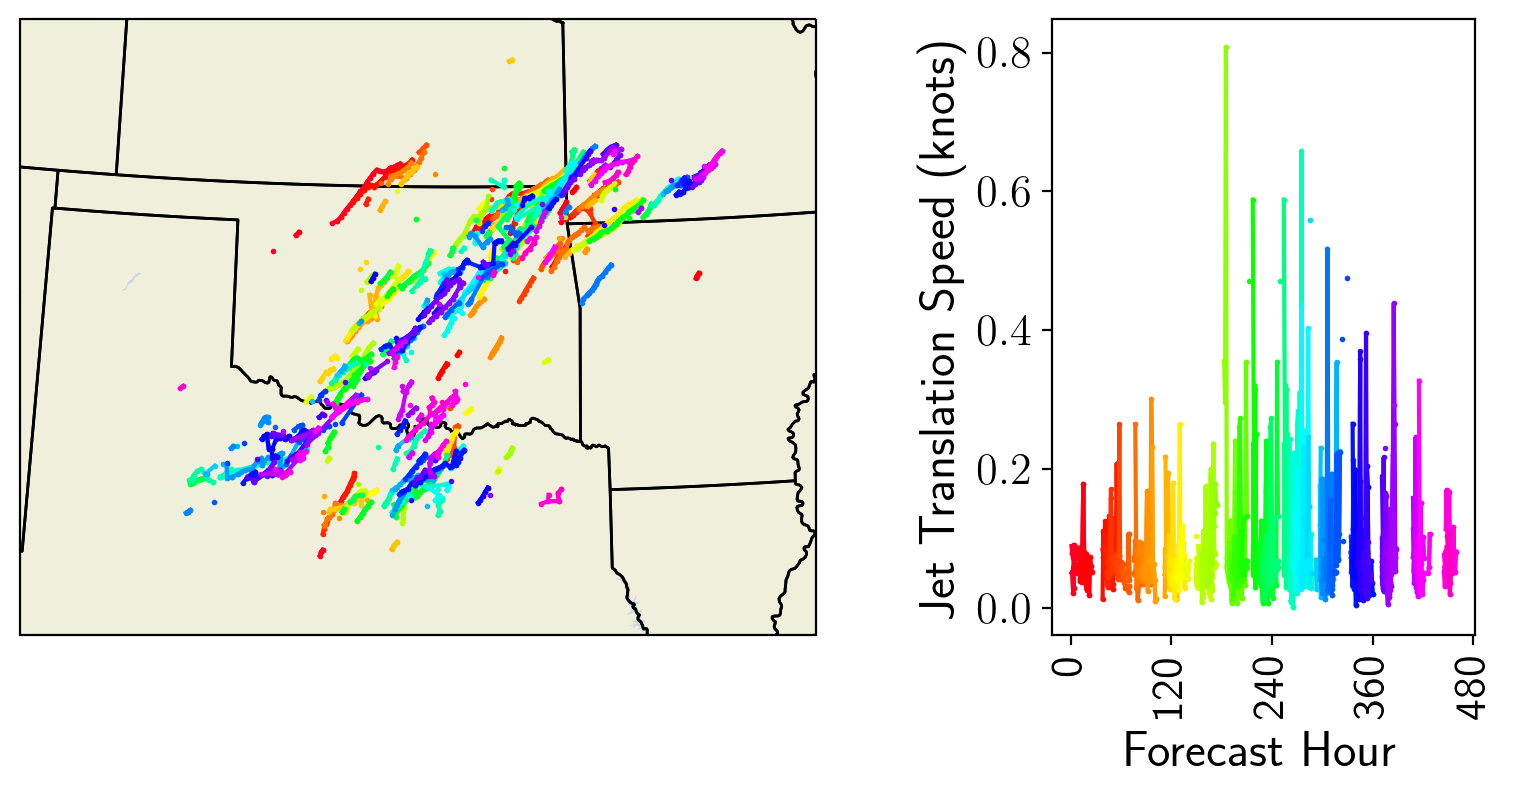

In [102]:
nobjs = len(tracked_jets_centroids)
print("# tracks", nobjs)
track_colors = mpl.colormaps['gist_rainbow'](np.linspace(0,1, nobjs))
plot_storm_tracks(tracked_jets_centroids, cfeature, 'centroids', track_colors, 
                  fig_ax_gs=None, figsize=(10,4), extent=extent_tracks, dpi=200, 
                  save=False, fnpath='storm_tracks_centroids.png')

nframe = 18


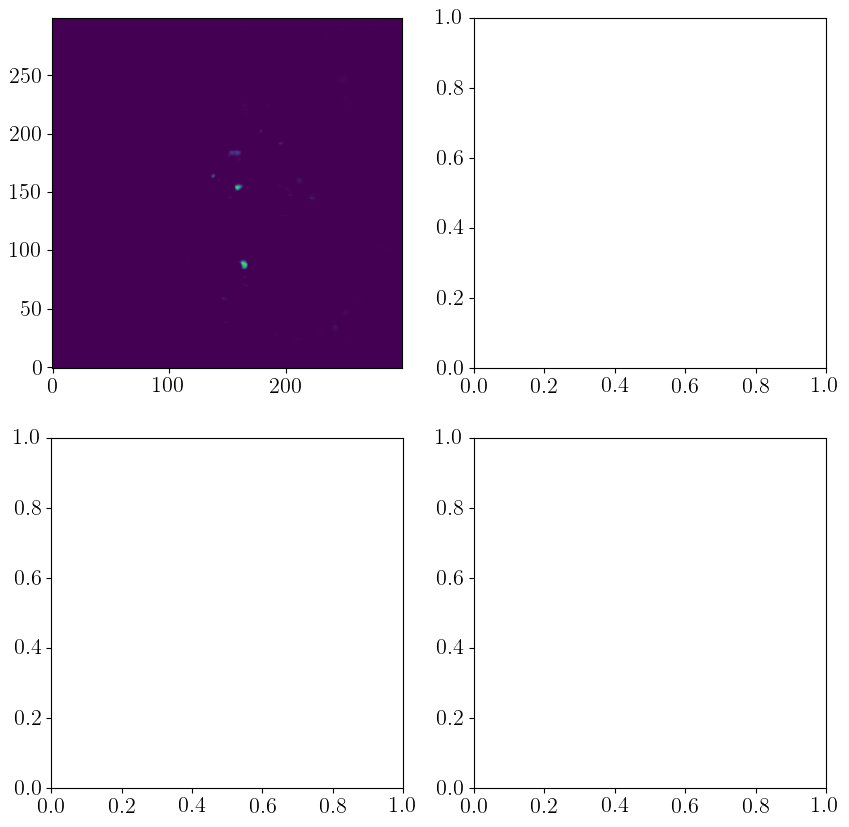

In [103]:
def _storm_gif(data_list, df_storm_reports, frames=None, fig_ax=None, 
               figsize=(10, 12), vmin=0, vmax=.8, invert_yaxis=False, 
               interval=250):
    '''
    frames: int or list of ints with the frame indicies 

    '''
    p0 = 0
    if frames is None:
        frames = len(data_list)   
    elif isinstance(frames, (list, tuple, np.ndarray)): 
        p0 = frames[0]
        print("# Frames", len(frames))
    print(f"nframe = {frames}")

    # Storm Reports
    lats_storm = df_storm_reports['Lat'].values 
    lons_storm = df_storm_reports['Lon'].values
    times_storms = np.array([d.to_pydatetime() for d in pd.to_datetime(df_storm_reports['DateTime'].values)])

    #itime = '1900'

    fig = None
    axs = None
    if fig_ax:
        fig, axs = fig_ax
    else:
        fig, axs = plt.subplots(2, 2, figsize=figsize)
        axs = axs.ravel()
        
    figax = (fig, axs[:2])

    def draw_storm_frame(pi):
        '''
        Draw a frame
        @param pi: index (aka frame index)
        '''
        axs[0].clear()

        im = axs[0].imshow(data_list[pi], vmin=vmin, vmax=vmax)
        #axs[0].set_title(val['title'])
        if invert_yaxis: axs[0].invert_yaxis()
        
        '''xlats = _wofs_stat['xlat']
        xlons = _wofs_stat['xlon']
        dtime = _wofs_stat['datetime']

        # Storm reports
        mask, sel_storms, tree = wpe.create_storm_mask(xlats, xlons, dtime, lats_storm, 
                                                    lons_storm, times_storms, 
                                                    **storm_mask_args, kdworkers=-1)
        # WoFS Domain box
        xlat_range = np.quantile(xlats, [0, 1])
        xlon_range = np.quantile(xlons, [0, 1])
        width = np.diff(xlon_range)[0]
        height = np.diff(xlat_range)[0]

        all_lats = np.append(xlats.ravel(), df_storm_reports['Lat'].ravel()) #lats_storm
        all_lons = np.append(xlons.ravel(), df_storm_reports['Lon'].ravel()) #lons_storm
        ylims = np.quantile(all_lats, [0, 1]) + [-2, 2]
        xlims = np.quantile(all_lons, [0, 1]) + [-2, 2]

        rect = Rectangle((xlon_range[0], xlat_range[0]), width, height, 
                        facecolor='none', edgecolor='k')
        axs[0].add_patch(rect)
        axs[0].text(xlon_range[0], xlat_range[0]-1.5, 'WoFS Domain')
        axs[0].set(xlim=xlims, ylim=ylims, title=f'[{dtime}] Storms')
        axs[0].set_aspect("equal")

        # Storm reports
        wpe.plot_storms(mask, lons_storm[sel_storms], lats_storm[sel_storms], 
                        figax=figax, figsize=figsize, xlims=xlims, ylims=ylims, 
                        invert_yaxis=invert_yaxis, 
                        bcmap=mpl.colors.ListedColormap(['w', 'blue']))
        figax[0].suptitle(rf'[{dtime}] dist $<$ {thres_dist}km, time $<$ {thres_time}min')
        '''


    animator = FuncAnimation(fig, draw_storm_frame, frames=frames,
                             interval=interval, repeat=True) #, **kwargs)

    animator

    return animator


sel_files, sel_mask = select_files(df_all_rundate_files, itime=None, ftime=None, #df_all_files
                                   emember=None, rdate='20190430', return_mask=True)
frames = 18 #np.where(sel_mask)[0][:37] #[:(74*5):74] #np.arange(5, 10)
_storm_gif(ml_preds, df_storm_report, frames=frames, fig_ax=None, 
           figsize=(10, 10), invert_yaxis=True, interval=250)

# EXAMPLE KDTree

In [104]:
x, y = np.mgrid[0:4, 0:4]
x

array([[0, 0, 0, 0],
       [1, 1, 1, 1],
       [2, 2, 2, 2],
       [3, 3, 3, 3]])

In [105]:
y

array([[0, 1, 2, 3],
       [0, 1, 2, 3],
       [0, 1, 2, 3],
       [0, 1, 2, 3]])

In [106]:
points = np.c_[x.ravel(), y.ravel()]
points

array([[0, 0],
       [0, 1],
       [0, 2],
       [0, 3],
       [1, 0],
       [1, 1],
       [1, 2],
       [1, 3],
       [2, 0],
       [2, 1],
       [2, 2],
       [2, 3],
       [3, 0],
       [3, 1],
       [3, 2],
       [3, 3]])

In [107]:
tree = spatial.cKDTree(points)
tree.query_ball_point([2, 0], 1)

[4, 8, 9, 12]

In [108]:
tree.query_ball_point(([1.5, .1], [3, 3]), 2)

array([list([0, 1, 4, 5, 6, 8, 9, 10, 12, 13]),
       list([7, 10, 11, 13, 14, 15])], dtype=object)

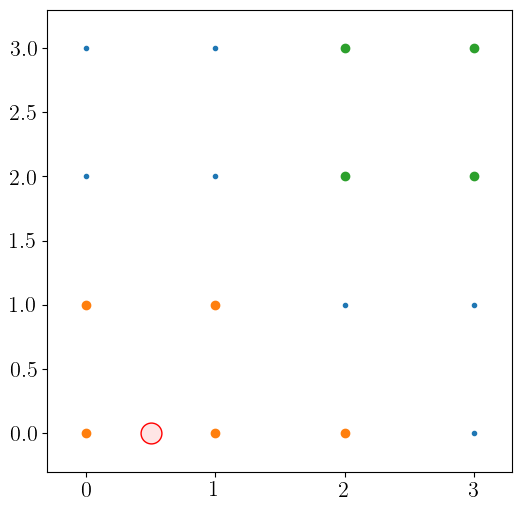

In [109]:
f_, a_ = plt.subplots(1, 1, figsize=(6, 6))
points = np.asarray(points)
a_.plot(points[:,0], points[:,1], '.')

for results in tree.query_ball_point(([.5, 0], [3, 3]), 1.5):
    nearby_points = points[results]
    a_.plot(nearby_points[:,0], nearby_points[:,1], 'o')

a_.plot(.5, 0, 'ro', ms=15, markeredgecolor=(1, 0, 0, 1), 
        markerfacecolor=(1, 0, 0, 0.1))

a_.margins(0.1, 0.1)